In [1]:
import scanpy as sc
from anndata import AnnData

from grnndata import GRNAnnData, from_embeddings
from grnndata import utils

from scdataloader import Preprocessor as myPreprocessor
from bengrn import BenGRN, get_sroy_gt, get_perturb_gt

import os
import warnings
import sys
import numpy as np

sys.path.insert(0, "../")
from scgpt_helper import prepare_model, prepare_dataset, generate_embedding, generate_grn
import scgpt as scg
from scgpt.tasks import GeneEmbedding
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.utils import set_seed
from scgpt.tokenizer import tokenize_and_pad_batch
import torch
import gc

os.environ["KMP_WARNINGS"] = "off"
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

print(torch.cuda.is_available())
set_seed(42)


💡 connected lamindb: jkobject/scprint


/pasteur/appa/homes/jkalfon/scGPT/mytests/../scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/pasteur/appa/homes/jkalfon/scGPT/mytests/../scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")


True


## Step 1: Load fine-tuned model and dataset


### 1.1 Load fine-tuned model

We are going to load a fine-tuned model for the gene interaction analysis on
Adamson dataset. The fine-tuned model can be downloaded via this
[link](https://drive.google.com/drive/folders/1HsPrwYGPXm867_u_Ye0W4Ch8AFSneXAn).
The dataset will be loaded in the next step 1.2.

To reproduce the provided fine-tuned model. Please followw the integration
fin-tuning pipeline to fine-tune the pre-trained blood model on the Adamson
perturbation dataset. Note that in the fine-tuning stage, we did not perform
highly vairable gene selection but trained on the 5000+ genes present in the
Adamson dataset. This is to provide flexbility in the inference stage to
investigate changes in attention maps across different perturbation conditions.


In [2]:
model, vocab = prepare_model(model_dir="../save/scGPT_human")

Resume model from ../save/scGPT_human/best_model.pt, the model args will override the config ../save/scGPT_human/args.json.


In [3]:
mpreprocessor = myPreprocessor(is_symbol=True, force_preprocess=True, skip_validate=True,
                            do_postp=False, min_valid_genes_id=5000, min_dataset_size=64)

genes = torch.load(
#    '../../scPRINT/data/temp/vbd8bavn/epoch=17-step=90000.ckpt'
    '/pasteur/zeus/projets/p02/ml4ig_hot/Users/jkalfon/scprint_scale/o2uniqsx/checkpoints/epoch=18-step=133000.ckpt'
)['hyper_parameters']['genes']

In [4]:
CELLTYPES = [
"retinal rod cell",
"Mueller cell",
"amacrine cell",
"ON-bipolar cell",
"rod bipolar cell",
"retinal cone cell",
"retina horizontal cell",
"retinal ganglion cell",
"astrocyte",
"microglial cell",
]

MAXCELLS = 1024
NUM_GENES = 5000

In [5]:
#adata = sc.read_h5ad('/home/ml4ig1/scprint/.lamindb/gNNpgpo6gATjuxTE7CCp.h5ad')
adata = sc.read_h5ad('../../scPRINT/data/gNNpgpo6gATjuxTE7CCp.h5ad')
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(utils.TF), "isTF"] = True
adata

AnnData object with n_obs × n_vars = 51370 × 70116
    obs: 'biosample_id', 'donor_id', 'cell_type_ontology_term_id', 'organism_ontology_term_id', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'cell_type__custom', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'is_primary_data', 'age', 'self_reported_ethnicity_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'cell_culture', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'uid', 'symbol', 'ncbi_gene_ids', 'biotype', 'desc

scGPT - INFO - Filtering genes by counts ...


scGPT - INFO - Normalizing total counts ...


scGPT - INFO - Log1p transforming ...


scGPT - INFO - Binning data ...



  0%|          | 0/205 [00:00<?, ?it/s]


  0%|          | 1/205 [00:00<02:40,  1.27it/s]


  3%|▎         | 6/205 [00:00<00:22,  8.70it/s]


  5%|▌         | 11/205 [00:00<00:12, 15.96it/s]


  8%|▊         | 16/205 [00:01<00:08, 22.63it/s]


 10%|█         | 21/205 [00:01<00:06, 28.45it/s]


 13%|█▎        | 26/205 [00:01<00:05, 33.25it/s]


 15%|█▌        | 31/205 [00:01<00:04, 37.17it/s]


 18%|█▊        | 36/205 [00:01<00:04, 40.04it/s]


 20%|██        | 41/205 [00:01<00:03, 42.24it/s]


 22%|██▏       | 46/205 [00:01<00:03, 43.84it/s]


 25%|██▍       | 51/205 [00:01<00:03, 44.94it/s]


 27%|██▋       | 56/205 [00:01<00:03, 45.82it/s]


 30%|██▉       | 61/205 [00:02<00:03, 46.43it/s]


 32%|███▏      | 66/205 [00:02<00:02, 46.88it/s]


 35%|███▍      | 71/205 [00:02<00:02, 47.17it/s]


 37%|███▋      | 76/205 [00:02<00:02, 47.40it/s]


 40%|███▉      | 81/205 [00:02<00:02, 47.55it/s]


 42%|████▏     | 86/205 [00:02<00:02, 47.68it/s]


 44%|████▍     | 91/205 [00:02<00:02, 47.77it/s]


 47%|████▋     | 96/205 [00:02<00:02, 47.76it/s]


 49%|████▉     | 101/205 [00:02<00:02, 47.80it/s]


 52%|█████▏    | 106/205 [00:02<00:02, 47.85it/s]


 54%|█████▍    | 111/205 [00:03<00:01, 47.90it/s]


 57%|█████▋    | 116/205 [00:03<00:01, 47.94it/s]


 59%|█████▉    | 121/205 [00:03<00:01, 47.73it/s]


 61%|██████▏   | 126/205 [00:03<00:01, 47.62it/s]


 64%|██████▍   | 131/205 [00:03<00:01, 47.67it/s]


 66%|██████▋   | 136/205 [00:03<00:01, 47.71it/s]


 69%|██████▉   | 141/205 [00:03<00:01, 47.75it/s]


 71%|███████   | 146/205 [00:03<00:01, 47.77it/s]


 74%|███████▎  | 151/205 [00:03<00:01, 47.83it/s]


 76%|███████▌  | 156/205 [00:04<00:01, 47.85it/s]


 79%|███████▊  | 161/205 [00:04<00:00, 47.85it/s]


 81%|████████  | 166/205 [00:04<00:00, 47.89it/s]


 83%|████████▎ | 171/205 [00:04<00:00, 47.91it/s]


 86%|████████▌ | 176/205 [00:04<00:00, 47.89it/s]


 88%|████████▊ | 181/205 [00:04<00:00, 47.92it/s]


 91%|█████████ | 186/205 [00:04<00:00, 47.93it/s]


 93%|█████████▎| 191/205 [00:04<00:00, 47.93it/s]


 96%|█████████▌| 196/205 [00:04<00:00, 47.92it/s]


 98%|█████████▊| 201/205 [00:04<00:00, 47.93it/s]


100%|██████████| 205/205 [00:05<00:00, 40.64it/s]

base enrichment


Top central genes: []
The DataFrame contains only the same values.


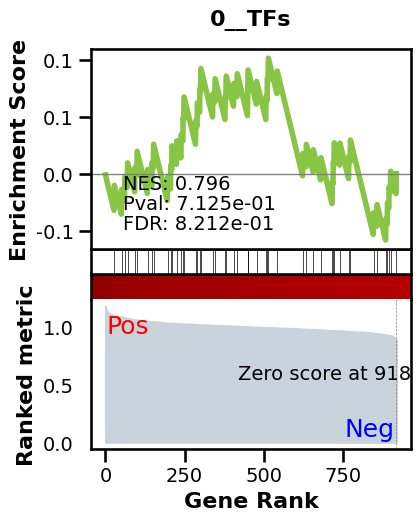

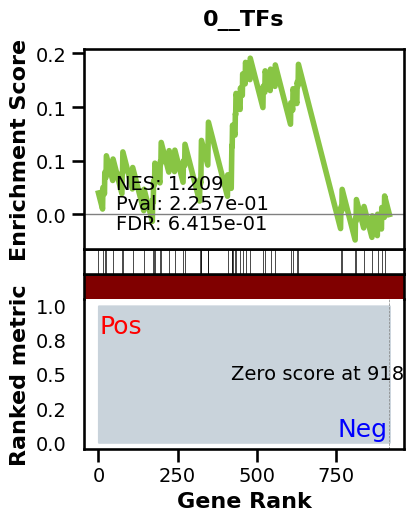

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 587 genes
intersection pct: 0.6387377584330794
precision:  0.0007864897886925406 
recall:  1.0 
random precision: 0.0007878319214377497



  0%|          | 0/128 [00:00<?, ?it/s]


100%|██████████| 128/128 [00:00<00:00, 2524.29it/s]

Average Precision (AP):  0.0010480997366085684
Area Under Precision-Recall Curve (AUPRC):  0.0010305593982646356
EPR: 0.0


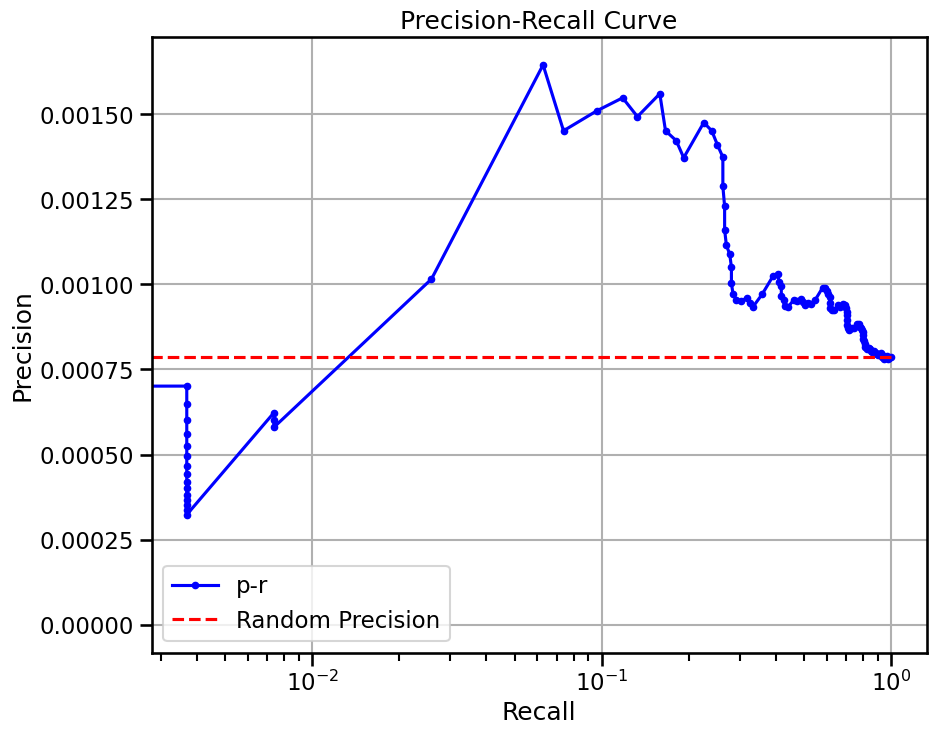

base enrichment


Top central genes: []


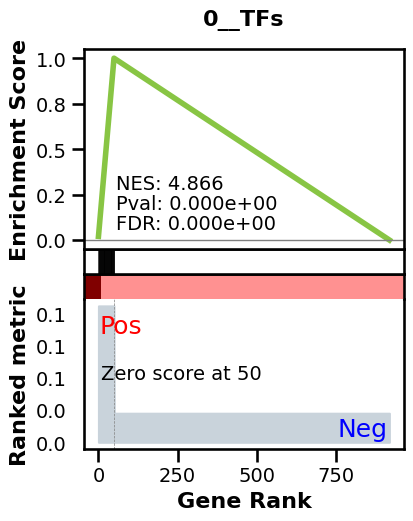

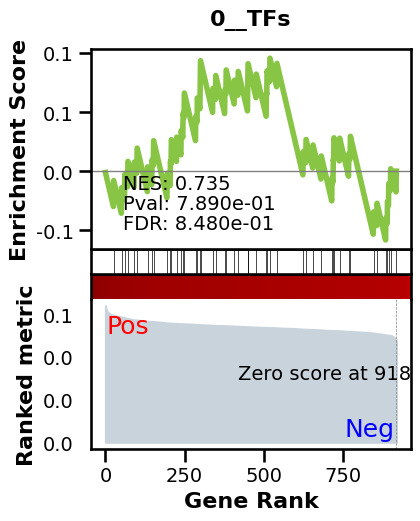

2024-07-16 09:21:56,229 [ERROR] No gene sets passed through filtering condition !!! 
Hint 1: Try to lower min_size or increase max_size !
Hint 2: Check gene symbols are identifiable to your gmt input.
Hint 3: Gene symbols curated in Enrichr web services are all upcases.



2024-07-16 09:21:56,230 [ERROR] The first entry of your gene_sets (gmt) look like this : { 0__TFs: [AC008770, AC023509, AC092835, AC138696, ADNP, ADNP2, AEBP1, AEBP2, AHCTF1, AHDC1, AHR, AHRR, AIRE, AKAP8, AKAP8L, AKNA, ALX1, ALX3, ALX4, ANHX, ANKZF1, AR, ARGFX, ARHGAP35, ARID2, ARID3A, ARID3B, ARID3C, ARID5A, ARID5B, ARNT, ARNT2, ARNTL, ARNTL2, ARX, ASCL1, ASCL2, ASCL3, ASCL4, ASCL5, ASH1L, ATF1, ATF2, ATF3, ATF4, ATF5, ATF6, ATF6B, ATF7, ATMIN, ATOH1, ATOH7, ATOH8, BACH1, BACH2, BARHL1, BARHL2, BARX1, BARX2, BATF, BATF2, BATF3, BAZ2A, BAZ2B, BBX, BCL11A, BCL11B, BCL6, BCL6B, BHLHA15, BHLHA9, BHLHE22, BHLHE23, BHLHE40, BHLHE41, BNC1, BNC2, BORCS8-MEF2B, BPTF, BRF2, BSX, C11orf95, CAMTA1, CAMTA2, CARF, CASZ1, CBX2, CC2D1A, CCDC169-SOHLH2, CCDC17, CDC5L, CDX1, CDX2, CDX4, CEBPA, CEBPB, CEBPD, CEBPE, CEBPG, CEBPZ, CENPA, CENPB, CENPBD1, CENPS, CENPT, CENPX, CGGBP1, CHAMP1, CHCHD3, CIC, CLOCK, CPEB1, CPXCR1, CREB1, CREB3, CREB3L1, CREB3L2, CREB3L3, CREB3L4, CREB5, CREBL2, CREBZF, CREM, CR

2024-07-16 09:21:56,230 [ERROR] The first 5 genes look like this : [ HEYL, ELF3, IRF7, MEOX2, RAG1 ]


raised a lookup error
_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 587 genes
intersection pct: 0.6387377584330794
precision:  0.005719153078607934 
recall:  0.5202952029520295 
random precision: 0.0007878319214377497



  0%|          | 0/128 [00:00<?, ?it/s]


100%|██████████| 128/128 [00:00<00:00, 2481.45it/s]

Average Precision (AP):  0.005584191097343096
Area Under Precision-Recall Curve (AUPRC):  0.005335114997087407
EPR: 9.492461408769918


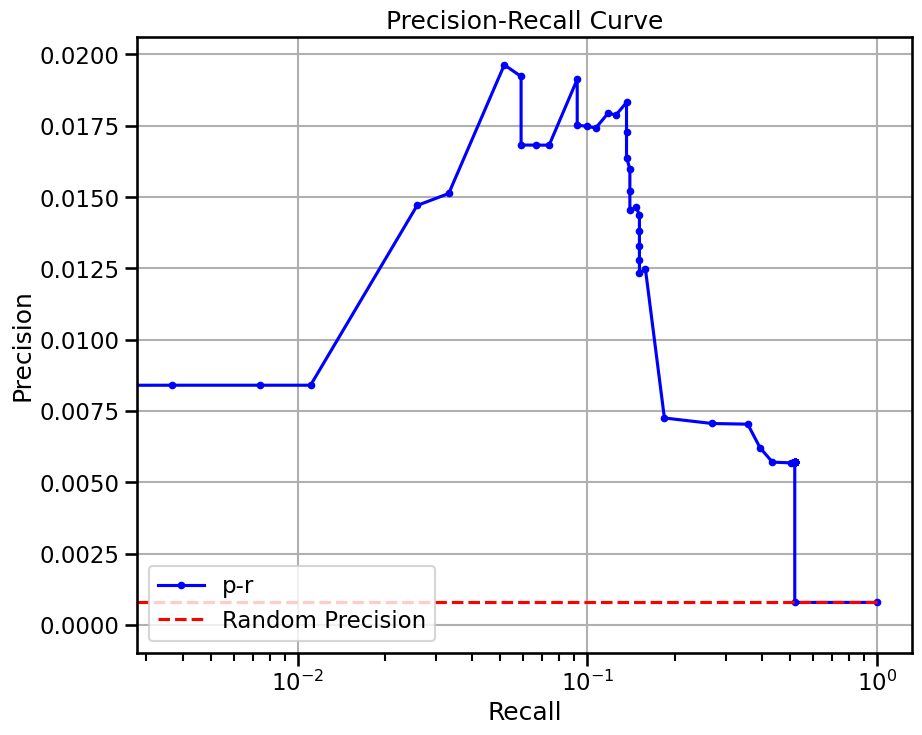


  0%|          | 0/205 [00:00<?, ?it/s]


  0%|          | 1/205 [00:00<01:13,  2.78it/s]


  1%|          | 2/205 [00:00<01:13,  2.75it/s]


  1%|▏         | 3/205 [00:01<01:13,  2.74it/s]


  2%|▏         | 4/205 [00:01<01:13,  2.73it/s]


  2%|▏         | 5/205 [00:01<01:13,  2.73it/s]


  3%|▎         | 6/205 [00:02<01:12,  2.73it/s]


  3%|▎         | 7/205 [00:02<01:12,  2.73it/s]


  4%|▍         | 8/205 [00:02<01:12,  2.73it/s]


  4%|▍         | 9/205 [00:03<01:11,  2.73it/s]


  5%|▍         | 10/205 [00:03<01:11,  2.73it/s]


  5%|▌         | 11/205 [00:04<01:11,  2.73it/s]


  6%|▌         | 12/205 [00:04<01:10,  2.72it/s]


  6%|▋         | 13/205 [00:04<01:10,  2.72it/s]


  7%|▋         | 14/205 [00:05<01:10,  2.72it/s]


  7%|▋         | 15/205 [00:05<01:09,  2.72it/s]


  8%|▊         | 16/205 [00:05<01:09,  2.72it/s]


  8%|▊         | 17/205 [00:06<01:09,  2.72it/s]


  9%|▉         | 18/205 [00:06<01:08,  2.72it/s]


  9%|▉         | 19/205 [00:06<01:08,  2.72it/s]


 10%|▉         | 20/205 [00:07<01:08,  2.72it/s]


 10%|█         | 21/205 [00:07<01:07,  2.71it/s]


 11%|█         | 22/205 [00:08<01:07,  2.71it/s]


 11%|█         | 23/205 [00:08<01:06,  2.72it/s]


 12%|█▏        | 24/205 [00:08<01:06,  2.72it/s]


 12%|█▏        | 25/205 [00:09<01:06,  2.72it/s]


 13%|█▎        | 26/205 [00:09<01:05,  2.71it/s]


 13%|█▎        | 27/205 [00:09<01:05,  2.72it/s]


 14%|█▎        | 28/205 [00:10<01:05,  2.71it/s]


 14%|█▍        | 29/205 [00:10<01:04,  2.72it/s]


 15%|█▍        | 30/205 [00:11<01:04,  2.72it/s]


 15%|█▌        | 31/205 [00:11<01:04,  2.72it/s]


 16%|█▌        | 32/205 [00:11<01:03,  2.72it/s]


 16%|█▌        | 33/205 [00:12<01:03,  2.72it/s]


 17%|█▋        | 34/205 [00:12<01:02,  2.72it/s]


 17%|█▋        | 35/205 [00:12<01:02,  2.72it/s]


 18%|█▊        | 36/205 [00:13<01:02,  2.72it/s]


 18%|█▊        | 37/205 [00:13<01:01,  2.72it/s]


 19%|█▊        | 38/205 [00:13<01:01,  2.72it/s]


 19%|█▉        | 39/205 [00:14<01:01,  2.72it/s]


 20%|█▉        | 40/205 [00:14<01:00,  2.72it/s]


 20%|██        | 41/205 [00:15<01:00,  2.72it/s]


 20%|██        | 42/205 [00:15<00:59,  2.72it/s]


 21%|██        | 43/205 [00:15<00:59,  2.72it/s]


 21%|██▏       | 44/205 [00:16<00:59,  2.72it/s]


 22%|██▏       | 45/205 [00:16<00:58,  2.72it/s]


 22%|██▏       | 46/205 [00:16<00:58,  2.72it/s]


 23%|██▎       | 47/205 [00:17<00:58,  2.72it/s]


 23%|██▎       | 48/205 [00:17<00:57,  2.72it/s]


 24%|██▍       | 49/205 [00:18<00:57,  2.72it/s]


 24%|██▍       | 50/205 [00:18<00:57,  2.72it/s]


 25%|██▍       | 51/205 [00:18<00:56,  2.72it/s]


 25%|██▌       | 52/205 [00:19<00:56,  2.72it/s]


 26%|██▌       | 53/205 [00:19<00:55,  2.72it/s]


 26%|██▋       | 54/205 [00:19<00:55,  2.72it/s]


 27%|██▋       | 55/205 [00:20<00:55,  2.72it/s]


 27%|██▋       | 56/205 [00:20<00:54,  2.72it/s]


 28%|██▊       | 57/205 [00:20<00:54,  2.72it/s]


 28%|██▊       | 58/205 [00:21<00:54,  2.72it/s]


 29%|██▉       | 59/205 [00:21<00:53,  2.72it/s]


 29%|██▉       | 60/205 [00:22<00:53,  2.72it/s]


 30%|██▉       | 61/205 [00:22<00:53,  2.72it/s]


 30%|███       | 62/205 [00:22<00:52,  2.71it/s]


 31%|███       | 63/205 [00:23<00:52,  2.72it/s]


 31%|███       | 64/205 [00:23<00:51,  2.72it/s]


 32%|███▏      | 65/205 [00:23<00:51,  2.72it/s]


 32%|███▏      | 66/205 [00:24<00:51,  2.72it/s]


 33%|███▎      | 67/205 [00:24<00:50,  2.72it/s]


 33%|███▎      | 68/205 [00:25<00:50,  2.72it/s]


 34%|███▎      | 69/205 [00:25<00:49,  2.73it/s]


 34%|███▍      | 70/205 [00:25<00:49,  2.72it/s]


 35%|███▍      | 71/205 [00:26<00:49,  2.72it/s]


 35%|███▌      | 72/205 [00:26<00:48,  2.72it/s]


 36%|███▌      | 73/205 [00:26<00:48,  2.73it/s]


 36%|███▌      | 74/205 [00:27<00:48,  2.72it/s]


 37%|███▋      | 75/205 [00:27<00:47,  2.73it/s]


 37%|███▋      | 76/205 [00:27<00:47,  2.72it/s]


 38%|███▊      | 77/205 [00:28<00:46,  2.73it/s]


 38%|███▊      | 78/205 [00:28<00:46,  2.72it/s]


 39%|███▊      | 79/205 [00:29<00:46,  2.73it/s]


 39%|███▉      | 80/205 [00:29<00:45,  2.73it/s]


 40%|███▉      | 81/205 [00:29<00:45,  2.73it/s]


 40%|████      | 82/205 [00:30<00:45,  2.72it/s]


 40%|████      | 83/205 [00:30<00:44,  2.73it/s]


 41%|████      | 84/205 [00:30<00:44,  2.73it/s]


 41%|████▏     | 85/205 [00:31<00:44,  2.73it/s]


 42%|████▏     | 86/205 [00:31<00:43,  2.72it/s]


 42%|████▏     | 87/205 [00:31<00:43,  2.72it/s]


 43%|████▎     | 88/205 [00:32<00:42,  2.72it/s]


 43%|████▎     | 89/205 [00:32<00:42,  2.73it/s]


 44%|████▍     | 90/205 [00:33<00:42,  2.72it/s]


 44%|████▍     | 91/205 [00:33<00:41,  2.73it/s]


 45%|████▍     | 92/205 [00:33<00:41,  2.72it/s]


 45%|████▌     | 93/205 [00:34<00:43,  2.58it/s]


 46%|████▌     | 94/205 [00:34<00:42,  2.62it/s]


 46%|████▋     | 95/205 [00:34<00:41,  2.65it/s]


 47%|████▋     | 96/205 [00:35<00:40,  2.67it/s]


 47%|████▋     | 97/205 [00:35<00:40,  2.69it/s]


 48%|████▊     | 98/205 [00:36<00:39,  2.70it/s]


 48%|████▊     | 99/205 [00:36<00:39,  2.71it/s]


 49%|████▉     | 100/205 [00:36<00:38,  2.71it/s]


 49%|████▉     | 101/205 [00:37<00:38,  2.72it/s]


 50%|████▉     | 102/205 [00:37<00:37,  2.72it/s]


 50%|█████     | 103/205 [00:37<00:37,  2.72it/s]


 51%|█████     | 104/205 [00:38<00:37,  2.72it/s]


 51%|█████     | 105/205 [00:38<00:36,  2.72it/s]


 52%|█████▏    | 106/205 [00:39<00:36,  2.72it/s]


 52%|█████▏    | 107/205 [00:39<00:35,  2.73it/s]


 53%|█████▎    | 108/205 [00:39<00:35,  2.72it/s]


 53%|█████▎    | 109/205 [00:40<00:35,  2.72it/s]


 54%|█████▎    | 110/205 [00:40<00:34,  2.72it/s]


 54%|█████▍    | 111/205 [00:40<00:34,  2.72it/s]


 55%|█████▍    | 112/205 [00:41<00:34,  2.72it/s]


 55%|█████▌    | 113/205 [00:41<00:33,  2.72it/s]


 56%|█████▌    | 114/205 [00:41<00:33,  2.72it/s]


 56%|█████▌    | 115/205 [00:42<00:33,  2.72it/s]


 57%|█████▋    | 116/205 [00:42<00:32,  2.72it/s]


 57%|█████▋    | 117/205 [00:43<00:32,  2.72it/s]


 58%|█████▊    | 118/205 [00:43<00:31,  2.72it/s]


 58%|█████▊    | 119/205 [00:43<00:31,  2.73it/s]


 59%|█████▊    | 120/205 [00:44<00:31,  2.73it/s]


 59%|█████▉    | 121/205 [00:44<00:30,  2.73it/s]


 60%|█████▉    | 122/205 [00:44<00:30,  2.72it/s]


 60%|██████    | 123/205 [00:45<00:30,  2.72it/s]


 60%|██████    | 124/205 [00:45<00:29,  2.72it/s]


 61%|██████    | 125/205 [00:45<00:29,  2.72it/s]


 61%|██████▏   | 126/205 [00:46<00:29,  2.72it/s]


 62%|██████▏   | 127/205 [00:46<00:28,  2.72it/s]


 62%|██████▏   | 128/205 [00:47<00:28,  2.72it/s]


 63%|██████▎   | 129/205 [00:47<00:27,  2.72it/s]


 63%|██████▎   | 130/205 [00:47<00:27,  2.72it/s]


 64%|██████▍   | 131/205 [00:48<00:27,  2.72it/s]


 64%|██████▍   | 132/205 [00:48<00:26,  2.72it/s]


 65%|██████▍   | 133/205 [00:48<00:26,  2.72it/s]


 65%|██████▌   | 134/205 [00:49<00:26,  2.71it/s]


 66%|██████▌   | 135/205 [00:49<00:25,  2.71it/s]


 66%|██████▋   | 136/205 [00:50<00:25,  2.71it/s]


 67%|██████▋   | 137/205 [00:50<00:25,  2.72it/s]


 67%|██████▋   | 138/205 [00:50<00:24,  2.71it/s]


 68%|██████▊   | 139/205 [00:51<00:24,  2.72it/s]


 68%|██████▊   | 140/205 [00:51<00:23,  2.71it/s]


 69%|██████▉   | 141/205 [00:51<00:23,  2.72it/s]


 69%|██████▉   | 142/205 [00:52<00:23,  2.71it/s]


 70%|██████▉   | 143/205 [00:52<00:22,  2.72it/s]


 70%|███████   | 144/205 [00:52<00:22,  2.71it/s]


 71%|███████   | 145/205 [00:53<00:22,  2.72it/s]


 71%|███████   | 146/205 [00:53<00:21,  2.72it/s]


 72%|███████▏  | 147/205 [00:54<00:21,  2.72it/s]


 72%|███████▏  | 148/205 [00:54<00:20,  2.72it/s]


 73%|███████▎  | 149/205 [00:54<00:20,  2.72it/s]


 73%|███████▎  | 150/205 [00:55<00:20,  2.72it/s]


 74%|███████▎  | 151/205 [00:55<00:19,  2.72it/s]


 74%|███████▍  | 152/205 [00:55<00:19,  2.72it/s]


 75%|███████▍  | 153/205 [00:56<00:19,  2.72it/s]


 75%|███████▌  | 154/205 [00:56<00:18,  2.72it/s]


 76%|███████▌  | 155/205 [00:57<00:18,  2.72it/s]


 76%|███████▌  | 156/205 [00:57<00:18,  2.72it/s]


 77%|███████▋  | 157/205 [00:57<00:17,  2.72it/s]


 77%|███████▋  | 158/205 [00:58<00:17,  2.72it/s]


 78%|███████▊  | 159/205 [00:58<00:16,  2.72it/s]


 78%|███████▊  | 160/205 [00:58<00:16,  2.72it/s]


 79%|███████▊  | 161/205 [00:59<00:16,  2.72it/s]


 79%|███████▉  | 162/205 [00:59<00:15,  2.72it/s]


 80%|███████▉  | 163/205 [00:59<00:15,  2.73it/s]


 80%|████████  | 164/205 [01:00<00:15,  2.72it/s]


 80%|████████  | 165/205 [01:00<00:14,  2.72it/s]


 81%|████████  | 166/205 [01:01<00:14,  2.72it/s]


 81%|████████▏ | 167/205 [01:01<00:13,  2.72it/s]


 82%|████████▏ | 168/205 [01:01<00:13,  2.72it/s]


 82%|████████▏ | 169/205 [01:02<00:13,  2.72it/s]


 83%|████████▎ | 170/205 [01:02<00:12,  2.72it/s]


 83%|████████▎ | 171/205 [01:02<00:12,  2.72it/s]


 84%|████████▍ | 172/205 [01:03<00:12,  2.72it/s]


 84%|████████▍ | 173/205 [01:03<00:11,  2.72it/s]


 85%|████████▍ | 174/205 [01:04<00:11,  2.72it/s]


 85%|████████▌ | 175/205 [01:04<00:11,  2.72it/s]


 86%|████████▌ | 176/205 [01:04<00:10,  2.72it/s]


 86%|████████▋ | 177/205 [01:05<00:10,  2.72it/s]


 87%|████████▋ | 178/205 [01:05<00:09,  2.72it/s]


 87%|████████▋ | 179/205 [01:05<00:09,  2.73it/s]


 88%|████████▊ | 180/205 [01:06<00:09,  2.72it/s]


 88%|████████▊ | 181/205 [01:06<00:08,  2.72it/s]


 89%|████████▉ | 182/205 [01:06<00:08,  2.72it/s]


 89%|████████▉ | 183/205 [01:07<00:08,  2.73it/s]


 90%|████████▉ | 184/205 [01:07<00:07,  2.72it/s]


 90%|█████████ | 185/205 [01:08<00:07,  2.72it/s]


 91%|█████████ | 186/205 [01:08<00:06,  2.72it/s]


 91%|█████████ | 187/205 [01:08<00:06,  2.72it/s]


 92%|█████████▏| 188/205 [01:09<00:06,  2.72it/s]


 92%|█████████▏| 189/205 [01:09<00:05,  2.72it/s]


 93%|█████████▎| 190/205 [01:09<00:05,  2.72it/s]


 93%|█████████▎| 191/205 [01:10<00:05,  2.72it/s]


 94%|█████████▎| 192/205 [01:10<00:04,  2.72it/s]


 94%|█████████▍| 193/205 [01:10<00:04,  2.72it/s]


 95%|█████████▍| 194/205 [01:11<00:04,  2.72it/s]


 95%|█████████▌| 195/205 [01:11<00:03,  2.72it/s]


 96%|█████████▌| 196/205 [01:12<00:03,  2.72it/s]


 96%|█████████▌| 197/205 [01:12<00:02,  2.72it/s]


 97%|█████████▋| 198/205 [01:12<00:02,  2.72it/s]


 97%|█████████▋| 199/205 [01:13<00:02,  2.72it/s]


 98%|█████████▊| 200/205 [01:13<00:01,  2.72it/s]


 98%|█████████▊| 201/205 [01:13<00:01,  2.72it/s]


 99%|█████████▊| 202/205 [01:14<00:01,  2.72it/s]


 99%|█████████▉| 203/205 [01:14<00:00,  2.72it/s]


100%|█████████▉| 204/205 [01:15<00:00,  2.72it/s]


100%|██████████| 205/205 [01:15<00:00,  2.88it/s]


100%|██████████| 205/205 [01:15<00:00,  2.72it/s]

base enrichment


Top central genes: []
The DataFrame contains only the same values.


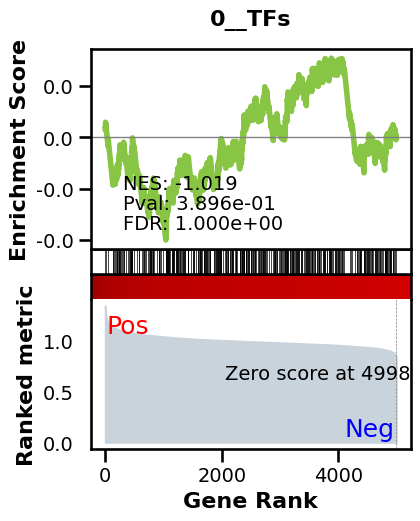

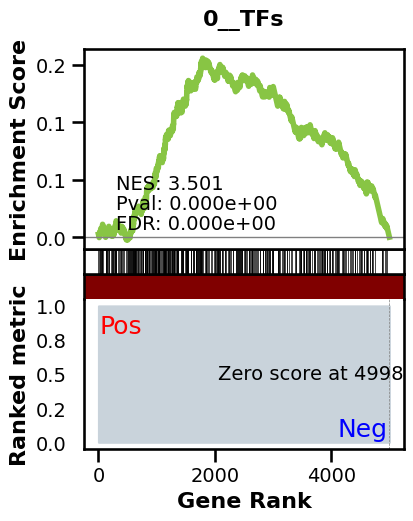

_________________________________________
TF specific enrichment


found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3633 genes
intersection pct: 0.7267453490698139
precision:  0.0013746819854608288 
recall:  1.0 
random precision: 0.0013750604771969137



  0%|          | 0/128 [00:00<?, ?it/s]


  5%|▍         | 6/128 [00:00<00:02, 52.44it/s]


  9%|▉         | 12/128 [00:00<00:02, 52.35it/s]


 14%|█▍        | 18/128 [00:00<00:02, 52.38it/s]


 19%|█▉        | 24/128 [00:00<00:01, 52.26it/s]


 23%|██▎       | 30/128 [00:00<00:01, 52.28it/s]


 28%|██▊       | 36/128 [00:00<00:01, 52.29it/s]


 33%|███▎      | 42/128 [00:00<00:01, 52.36it/s]


 38%|███▊      | 48/128 [00:01<00:01, 42.55it/s]


 42%|████▏     | 54/128 [00:01<00:01, 44.95it/s]


 47%|████▋     | 60/128 [00:01<00:01, 46.74it/s]


 52%|█████▏    | 66/128 [00:01<00:01, 48.06it/s]


 56%|█████▋    | 72/128 [00:01<00:01, 49.04it/s]


 61%|██████    | 78/128 [00:01<00:01, 49.68it/s]


 66%|██████▌   | 84/128 [00:01<00:00, 50.15it/s]


 70%|███████   | 90/128 [00:01<00:00, 50.81it/s]


 75%|███████▌  | 96/128 [00:01<00:00, 51.22it/s]


 80%|███████▉  | 102/128 [00:02<00:00, 51.43it/s]


 84%|████████▍ | 108/128 [00:02<00:00, 51.36it/s]


 89%|████████▉ | 114/128 [00:02<00:00, 51.34it/s]


 94%|█████████▍| 120/128 [00:02<00:00, 51.33it/s]


 98%|█████████▊| 126/128 [00:02<00:00, 51.36it/s]


100%|██████████| 128/128 [00:02<00:00, 50.11it/s]

Average Precision (AP):  0.0015389174032197162
Area Under Precision-Recall Curve (AUPRC):  0.0015359224318999875


EPR: 1.2433608048510763


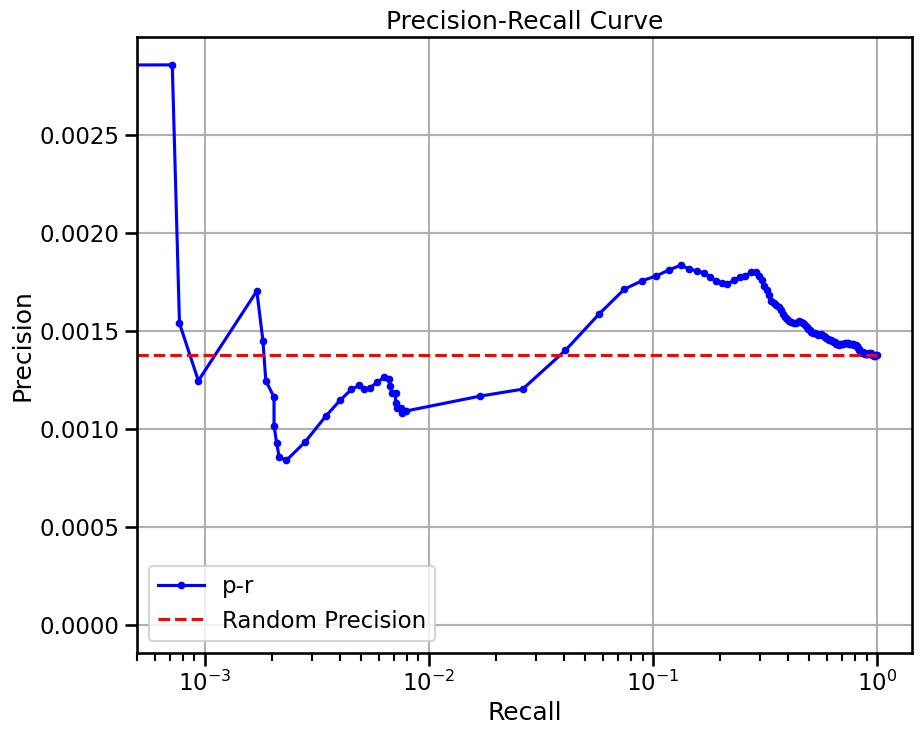

base enrichment


Top central genes: []


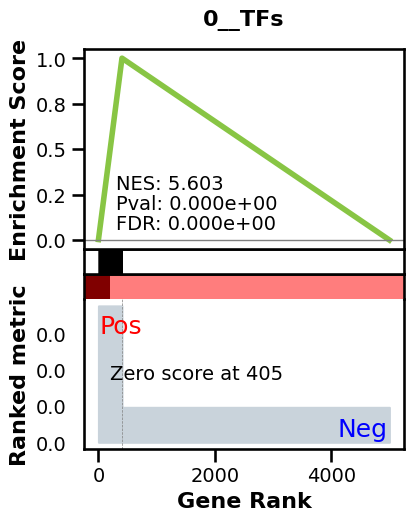

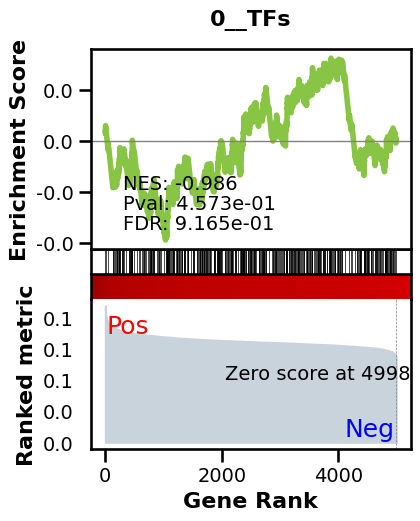

_________________________________________
TF specific enrichment


found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3633 genes
intersection pct: 0.7267453490698139
precision:  0.0060602667637055805 
recall:  0.42956349206349204 
random precision: 0.0013750604771969137



  0%|          | 0/128 [00:00<?, ?it/s]


  5%|▍         | 6/128 [00:00<00:02, 52.28it/s]


  9%|▉         | 12/128 [00:00<00:02, 52.22it/s]


 14%|█▍        | 18/128 [00:00<00:02, 52.17it/s]


 19%|█▉        | 24/128 [00:00<00:01, 52.14it/s]


 23%|██▎       | 30/128 [00:00<00:01, 52.08it/s]


 28%|██▊       | 36/128 [00:00<00:01, 52.15it/s]


 33%|███▎      | 42/128 [00:00<00:01, 52.11it/s]


 38%|███▊      | 48/128 [00:00<00:01, 52.14it/s]


 42%|████▏     | 54/128 [00:01<00:01, 52.10it/s]


 47%|████▋     | 60/128 [00:01<00:01, 51.93it/s]


 52%|█████▏    | 66/128 [00:01<00:01, 51.99it/s]


 56%|█████▋    | 72/128 [00:01<00:01, 51.97it/s]


 61%|██████    | 78/128 [00:01<00:00, 51.97it/s]


 66%|██████▌   | 84/128 [00:01<00:00, 52.03it/s]


 70%|███████   | 90/128 [00:01<00:00, 51.99it/s]


 75%|███████▌  | 96/128 [00:01<00:00, 51.90it/s]


 80%|███████▉  | 102/128 [00:01<00:00, 51.39it/s]


 84%|████████▍ | 108/128 [00:02<00:00, 51.29it/s]


 89%|████████▉ | 114/128 [00:02<00:00, 51.53it/s]


 94%|█████████▍| 120/128 [00:02<00:00, 51.67it/s]


 98%|█████████▊| 126/128 [00:02<00:00, 51.84it/s]


100%|██████████| 128/128 [00:02<00:00, 51.90it/s]

Average Precision (AP):  0.004449330089700045
Area Under Precision-Recall Curve (AUPRC):  0.0039773849050964
EPR: 5.395051665861319


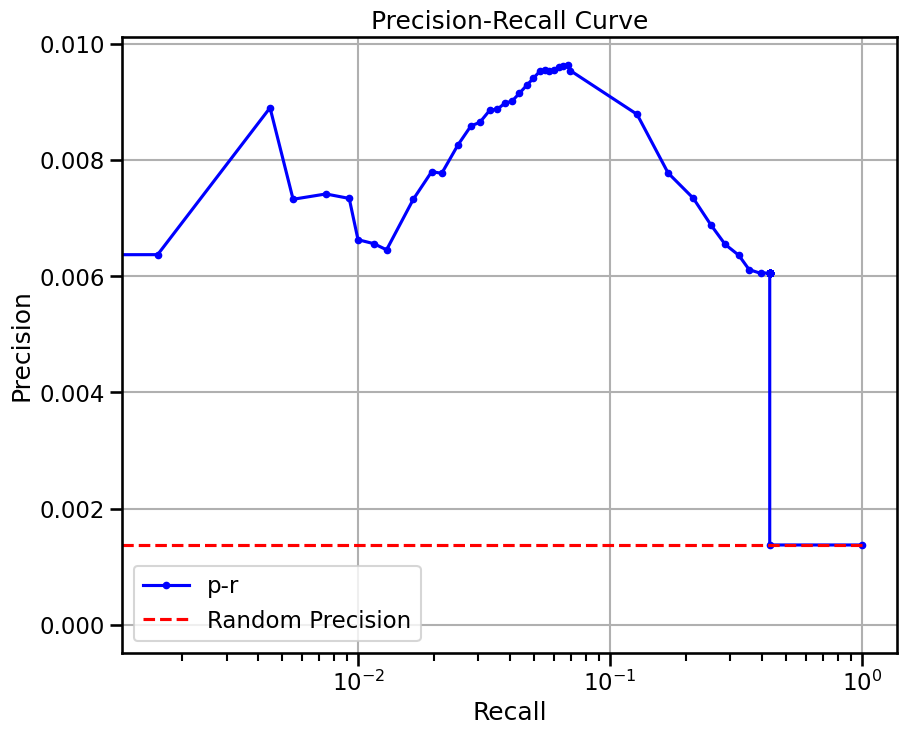


  0%|          | 0/205 [00:00<?, ?it/s]


  0%|          | 1/205 [00:00<02:37,  1.29it/s]


  1%|          | 2/205 [00:01<02:24,  1.41it/s]


  1%|▏         | 3/205 [00:02<02:23,  1.41it/s]


  2%|▏         | 4/205 [00:02<02:19,  1.44it/s]


  2%|▏         | 5/205 [00:03<02:17,  1.46it/s]


  3%|▎         | 6/205 [00:04<02:15,  1.47it/s]


  3%|▎         | 7/205 [00:04<02:13,  1.48it/s]


  4%|▍         | 8/205 [00:05<02:12,  1.48it/s]


  4%|▍         | 9/205 [00:06<02:12,  1.48it/s]


  5%|▍         | 10/205 [00:06<02:11,  1.49it/s]


  5%|▌         | 11/205 [00:07<02:10,  1.49it/s]


  6%|▌         | 12/205 [00:08<02:09,  1.49it/s]


  6%|▋         | 13/205 [00:08<02:08,  1.49it/s]


  7%|▋         | 14/205 [00:09<02:08,  1.49it/s]


  7%|▋         | 15/205 [00:10<02:07,  1.49it/s]


  8%|▊         | 16/205 [00:10<02:07,  1.49it/s]


  8%|▊         | 17/205 [00:11<02:06,  1.49it/s]


  9%|▉         | 18/205 [00:12<02:05,  1.49it/s]


  9%|▉         | 19/205 [00:12<02:05,  1.49it/s]


 10%|▉         | 20/205 [00:13<02:05,  1.48it/s]


 10%|█         | 21/205 [00:14<02:03,  1.48it/s]


 11%|█         | 22/205 [00:14<02:03,  1.49it/s]


 11%|█         | 23/205 [00:15<02:02,  1.49it/s]


 12%|█▏        | 24/205 [00:16<02:02,  1.48it/s]


 12%|█▏        | 25/205 [00:16<02:01,  1.48it/s]


 13%|█▎        | 26/205 [00:17<02:00,  1.49it/s]


 13%|█▎        | 27/205 [00:18<01:59,  1.49it/s]


 14%|█▎        | 28/205 [00:18<01:58,  1.49it/s]


 14%|█▍        | 29/205 [00:19<01:58,  1.49it/s]


 15%|█▍        | 30/205 [00:20<01:57,  1.49it/s]


 15%|█▌        | 31/205 [00:20<01:57,  1.48it/s]


 16%|█▌        | 32/205 [00:21<01:56,  1.48it/s]


 16%|█▌        | 33/205 [00:22<01:56,  1.48it/s]


 17%|█▋        | 34/205 [00:22<01:55,  1.48it/s]


 17%|█▋        | 35/205 [00:23<01:54,  1.48it/s]


 18%|█▊        | 36/205 [00:24<01:53,  1.49it/s]


 18%|█▊        | 37/205 [00:25<01:53,  1.49it/s]


 19%|█▊        | 38/205 [00:25<01:52,  1.49it/s]


 19%|█▉        | 39/205 [00:26<01:51,  1.49it/s]


 20%|█▉        | 40/205 [00:27<01:50,  1.49it/s]


 20%|██        | 41/205 [00:27<01:50,  1.49it/s]


 20%|██        | 42/205 [00:28<01:49,  1.49it/s]


 21%|██        | 43/205 [00:29<01:49,  1.48it/s]


 21%|██▏       | 44/205 [00:29<01:48,  1.49it/s]


 22%|██▏       | 45/205 [00:30<01:47,  1.48it/s]


 22%|██▏       | 46/205 [00:31<01:47,  1.48it/s]


 23%|██▎       | 47/205 [00:31<01:46,  1.48it/s]


 23%|██▎       | 48/205 [00:32<01:45,  1.48it/s]


 24%|██▍       | 49/205 [00:33<01:45,  1.48it/s]


 24%|██▍       | 50/205 [00:33<01:44,  1.48it/s]


 25%|██▍       | 51/205 [00:34<01:44,  1.48it/s]


 25%|██▌       | 52/205 [00:35<01:43,  1.48it/s]


 26%|██▌       | 53/205 [00:35<01:42,  1.48it/s]


 26%|██▋       | 54/205 [00:36<01:42,  1.48it/s]


 27%|██▋       | 55/205 [00:37<01:41,  1.48it/s]


 27%|██▋       | 56/205 [00:37<01:40,  1.48it/s]


 28%|██▊       | 57/205 [00:38<01:40,  1.48it/s]


 28%|██▊       | 58/205 [00:39<01:39,  1.48it/s]


 29%|██▉       | 59/205 [00:39<01:38,  1.48it/s]


 29%|██▉       | 60/205 [00:40<01:38,  1.48it/s]


 30%|██▉       | 61/205 [00:41<01:37,  1.48it/s]


 30%|███       | 62/205 [00:41<01:36,  1.48it/s]


 31%|███       | 63/205 [00:42<01:35,  1.48it/s]


 31%|███       | 64/205 [00:43<01:35,  1.48it/s]


 32%|███▏      | 65/205 [00:43<01:34,  1.48it/s]


 32%|███▏      | 66/205 [00:44<01:33,  1.48it/s]


 33%|███▎      | 67/205 [00:45<01:33,  1.48it/s]


 33%|███▎      | 68/205 [00:45<01:32,  1.48it/s]


 34%|███▎      | 69/205 [00:46<01:31,  1.48it/s]


 34%|███▍      | 70/205 [00:47<01:31,  1.48it/s]


 35%|███▍      | 71/205 [00:47<01:30,  1.48it/s]


 35%|███▌      | 72/205 [00:48<01:29,  1.48it/s]


 36%|███▌      | 73/205 [00:49<01:29,  1.48it/s]


 36%|███▌      | 74/205 [00:50<01:28,  1.48it/s]


 37%|███▋      | 75/205 [00:50<01:27,  1.48it/s]


 37%|███▋      | 76/205 [00:51<01:27,  1.48it/s]


 38%|███▊      | 77/205 [00:52<01:26,  1.48it/s]


 38%|███▊      | 78/205 [00:52<01:25,  1.48it/s]


 39%|███▊      | 79/205 [00:53<01:25,  1.48it/s]


 39%|███▉      | 80/205 [00:54<01:24,  1.48it/s]


 40%|███▉      | 81/205 [00:54<01:23,  1.48it/s]


 40%|████      | 82/205 [00:55<01:23,  1.48it/s]


 40%|████      | 83/205 [00:56<01:24,  1.45it/s]


 41%|████      | 84/205 [00:56<01:22,  1.46it/s]


 41%|████▏     | 85/205 [00:57<01:23,  1.44it/s]


 42%|████▏     | 86/205 [00:58<01:21,  1.45it/s]


 42%|████▏     | 87/205 [00:58<01:22,  1.43it/s]


 43%|████▎     | 88/205 [00:59<01:20,  1.45it/s]


 43%|████▎     | 89/205 [01:00<01:21,  1.43it/s]


 44%|████▍     | 90/205 [01:00<01:19,  1.44it/s]


 44%|████▍     | 91/205 [01:01<01:18,  1.45it/s]


 45%|████▍     | 92/205 [01:02<01:17,  1.46it/s]


 45%|████▌     | 93/205 [01:03<01:16,  1.47it/s]


 46%|████▌     | 94/205 [01:03<01:15,  1.47it/s]


 46%|████▋     | 95/205 [01:04<01:14,  1.47it/s]


 47%|████▋     | 96/205 [01:05<01:14,  1.47it/s]


 47%|████▋     | 97/205 [01:05<01:13,  1.47it/s]


 48%|████▊     | 98/205 [01:06<01:12,  1.47it/s]


 48%|████▊     | 99/205 [01:07<01:12,  1.47it/s]


 49%|████▉     | 100/205 [01:07<01:11,  1.47it/s]


 49%|████▉     | 101/205 [01:08<01:10,  1.47it/s]


 50%|████▉     | 102/205 [01:09<01:09,  1.47it/s]


 50%|█████     | 103/205 [01:09<01:09,  1.47it/s]


 51%|█████     | 104/205 [01:10<01:08,  1.47it/s]


 51%|█████     | 105/205 [01:11<01:08,  1.47it/s]


 52%|█████▏    | 106/205 [01:11<01:07,  1.46it/s]


 52%|█████▏    | 107/205 [01:12<01:06,  1.46it/s]


 53%|█████▎    | 108/205 [01:13<01:06,  1.47it/s]


 53%|█████▎    | 109/205 [01:13<01:05,  1.47it/s]


 54%|█████▎    | 110/205 [01:14<01:04,  1.47it/s]


 54%|█████▍    | 111/205 [01:15<01:04,  1.46it/s]


 55%|█████▍    | 112/205 [01:15<01:03,  1.46it/s]


 55%|█████▌    | 113/205 [01:16<01:02,  1.46it/s]


 56%|█████▌    | 114/205 [01:17<01:02,  1.46it/s]


 56%|█████▌    | 115/205 [01:18<01:01,  1.46it/s]


 57%|█████▋    | 116/205 [01:18<01:01,  1.46it/s]


 57%|█████▋    | 117/205 [01:19<01:00,  1.46it/s]


 58%|█████▊    | 118/205 [01:20<00:59,  1.46it/s]


 58%|█████▊    | 119/205 [01:20<00:58,  1.47it/s]


 59%|█████▊    | 120/205 [01:21<00:57,  1.47it/s]


 59%|█████▉    | 121/205 [01:22<00:57,  1.47it/s]


 60%|█████▉    | 122/205 [01:22<00:56,  1.47it/s]


 60%|██████    | 123/205 [01:23<00:55,  1.47it/s]


 60%|██████    | 124/205 [01:24<00:54,  1.48it/s]


 61%|██████    | 125/205 [01:24<00:54,  1.48it/s]


 61%|██████▏   | 126/205 [01:25<00:53,  1.48it/s]


 62%|██████▏   | 127/205 [01:26<00:53,  1.47it/s]


 62%|██████▏   | 128/205 [01:26<00:52,  1.47it/s]


 63%|██████▎   | 129/205 [01:27<00:51,  1.47it/s]


 63%|██████▎   | 130/205 [01:28<00:50,  1.47it/s]


 64%|██████▍   | 131/205 [01:28<00:50,  1.47it/s]


 64%|██████▍   | 132/205 [01:29<00:49,  1.48it/s]


 65%|██████▍   | 133/205 [01:30<00:48,  1.48it/s]


 65%|██████▌   | 134/205 [01:30<00:48,  1.47it/s]


 66%|██████▌   | 135/205 [01:31<00:47,  1.47it/s]


 66%|██████▋   | 136/205 [01:32<00:46,  1.47it/s]


 67%|██████▋   | 137/205 [01:32<00:46,  1.47it/s]


 67%|██████▋   | 138/205 [01:33<00:45,  1.46it/s]


 68%|██████▊   | 139/205 [01:34<00:45,  1.47it/s]


 68%|██████▊   | 140/205 [01:35<00:44,  1.47it/s]


 69%|██████▉   | 141/205 [01:35<00:43,  1.47it/s]


 69%|██████▉   | 142/205 [01:36<00:42,  1.47it/s]


 70%|██████▉   | 143/205 [01:37<00:42,  1.47it/s]


 70%|███████   | 144/205 [01:37<00:41,  1.47it/s]


 71%|███████   | 145/205 [01:38<00:40,  1.47it/s]


 71%|███████   | 146/205 [01:39<00:40,  1.47it/s]


 72%|███████▏  | 147/205 [01:39<00:39,  1.48it/s]


 72%|███████▏  | 148/205 [01:40<00:38,  1.47it/s]


 73%|███████▎  | 149/205 [01:41<00:37,  1.48it/s]


 73%|███████▎  | 150/205 [01:41<00:37,  1.48it/s]


 74%|███████▎  | 151/205 [01:42<00:36,  1.48it/s]


 74%|███████▍  | 152/205 [01:43<00:35,  1.47it/s]


 75%|███████▍  | 153/205 [01:43<00:35,  1.47it/s]


 75%|███████▌  | 154/205 [01:44<00:34,  1.47it/s]


 76%|███████▌  | 155/205 [01:45<00:33,  1.47it/s]


 76%|███████▌  | 156/205 [01:45<00:33,  1.47it/s]


 77%|███████▋  | 157/205 [01:46<00:32,  1.47it/s]


 77%|███████▋  | 158/205 [01:47<00:31,  1.47it/s]


 78%|███████▊  | 159/205 [01:47<00:31,  1.47it/s]


 78%|███████▊  | 160/205 [01:48<00:30,  1.47it/s]


 79%|███████▊  | 161/205 [01:49<00:29,  1.47it/s]


 79%|███████▉  | 162/205 [01:49<00:29,  1.47it/s]


 80%|███████▉  | 163/205 [01:50<00:28,  1.47it/s]


 80%|████████  | 164/205 [01:51<00:27,  1.47it/s]


 80%|████████  | 165/205 [01:51<00:27,  1.47it/s]


 81%|████████  | 166/205 [01:52<00:26,  1.47it/s]


 81%|████████▏ | 167/205 [01:53<00:25,  1.47it/s]


 82%|████████▏ | 168/205 [01:54<00:25,  1.47it/s]


 82%|████████▏ | 169/205 [01:54<00:24,  1.47it/s]


 83%|████████▎ | 170/205 [01:55<00:23,  1.47it/s]


 83%|████████▎ | 171/205 [01:56<00:23,  1.47it/s]


 84%|████████▍ | 172/205 [01:56<00:22,  1.48it/s]


 84%|████████▍ | 173/205 [01:57<00:21,  1.47it/s]


 85%|████████▍ | 174/205 [01:58<00:21,  1.47it/s]


 85%|████████▌ | 175/205 [01:58<00:20,  1.47it/s]


 86%|████████▌ | 176/205 [01:59<00:19,  1.47it/s]


 86%|████████▋ | 177/205 [02:00<00:18,  1.47it/s]


 87%|████████▋ | 178/205 [02:00<00:18,  1.47it/s]


 87%|████████▋ | 179/205 [02:01<00:17,  1.47it/s]


 88%|████████▊ | 180/205 [02:02<00:17,  1.47it/s]


 88%|████████▊ | 181/205 [02:02<00:16,  1.46it/s]


 89%|████████▉ | 182/205 [02:03<00:15,  1.47it/s]


 89%|████████▉ | 183/205 [02:04<00:14,  1.47it/s]


 90%|████████▉ | 184/205 [02:04<00:14,  1.47it/s]


 90%|█████████ | 185/205 [02:05<00:13,  1.47it/s]


 91%|█████████ | 186/205 [02:06<00:12,  1.46it/s]


 91%|█████████ | 187/205 [02:06<00:12,  1.46it/s]


 92%|█████████▏| 188/205 [02:07<00:11,  1.46it/s]


 92%|█████████▏| 189/205 [02:08<00:10,  1.46it/s]


 93%|█████████▎| 190/205 [02:09<00:10,  1.46it/s]


 93%|█████████▎| 191/205 [02:09<00:09,  1.46it/s]


 94%|█████████▎| 192/205 [02:10<00:08,  1.46it/s]


 94%|█████████▍| 193/205 [02:11<00:08,  1.46it/s]


 95%|█████████▍| 194/205 [02:11<00:07,  1.46it/s]


 95%|█████████▌| 195/205 [02:12<00:06,  1.46it/s]


 96%|█████████▌| 196/205 [02:13<00:06,  1.47it/s]


 96%|█████████▌| 197/205 [02:13<00:05,  1.46it/s]


 97%|█████████▋| 198/205 [02:14<00:04,  1.46it/s]


 97%|█████████▋| 199/205 [02:15<00:04,  1.46it/s]


 98%|█████████▊| 200/205 [02:15<00:03,  1.46it/s]


 98%|█████████▊| 201/205 [02:16<00:02,  1.47it/s]


 99%|█████████▊| 202/205 [02:17<00:02,  1.47it/s]


 99%|█████████▉| 203/205 [02:17<00:01,  1.47it/s]


100%|█████████▉| 204/205 [02:18<00:00,  1.47it/s]


100%|██████████| 205/205 [02:19<00:00,  1.57it/s]


100%|██████████| 205/205 [02:19<00:00,  1.47it/s]

base enrichment


Top central genes: []
The DataFrame contains only the same values.


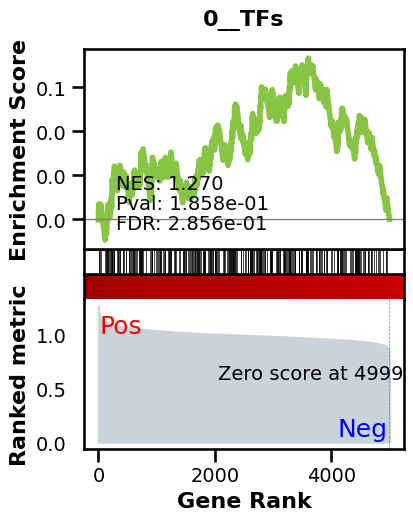

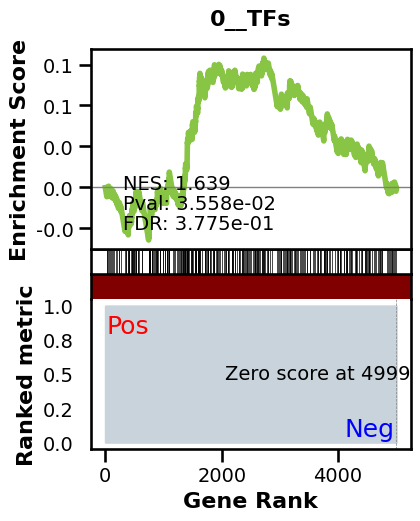

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3599 genes
intersection pct: 0.7198
precision:  0.0008199770844931533 
recall:  1.0 
random precision: 0.0008202049825155249



  0%|          | 0/128 [00:00<?, ?it/s]


  5%|▍         | 6/128 [00:00<00:04, 28.95it/s]


  9%|▉         | 12/128 [00:00<00:02, 39.71it/s]


 14%|█▍        | 18/128 [00:00<00:02, 45.08it/s]


 19%|█▉        | 24/128 [00:00<00:02, 48.13it/s]


 23%|██▎       | 30/128 [00:00<00:01, 49.90it/s]


 28%|██▊       | 36/128 [00:00<00:01, 51.07it/s]


 33%|███▎      | 42/128 [00:00<00:01, 51.86it/s]


 38%|███▊      | 48/128 [00:00<00:01, 52.40it/s]


 42%|████▏     | 54/128 [00:01<00:01, 52.77it/s]


 47%|████▋     | 60/128 [00:01<00:01, 52.90it/s]


 52%|█████▏    | 66/128 [00:01<00:01, 53.11it/s]


 56%|█████▋    | 72/128 [00:01<00:01, 53.33it/s]


 61%|██████    | 78/128 [00:01<00:00, 53.41it/s]


 66%|██████▌   | 84/128 [00:01<00:00, 53.46it/s]


 70%|███████   | 90/128 [00:01<00:00, 53.60it/s]


 75%|███████▌  | 96/128 [00:01<00:00, 53.58it/s]


 80%|███████▉  | 102/128 [00:01<00:00, 53.65it/s]


 84%|████████▍ | 108/128 [00:02<00:00, 53.71it/s]


 89%|████████▉ | 114/128 [00:02<00:00, 53.75it/s]


 94%|█████████▍| 120/128 [00:02<00:00, 53.77it/s]


 98%|█████████▊| 126/128 [00:02<00:00, 53.82it/s]


100%|██████████| 128/128 [00:02<00:00, 51.58it/s]

Average Precision (AP):  0.0009330191493622652
Area Under Precision-Recall Curve (AUPRC):  0.0009328476373872425
EPR: 1.378360281338002


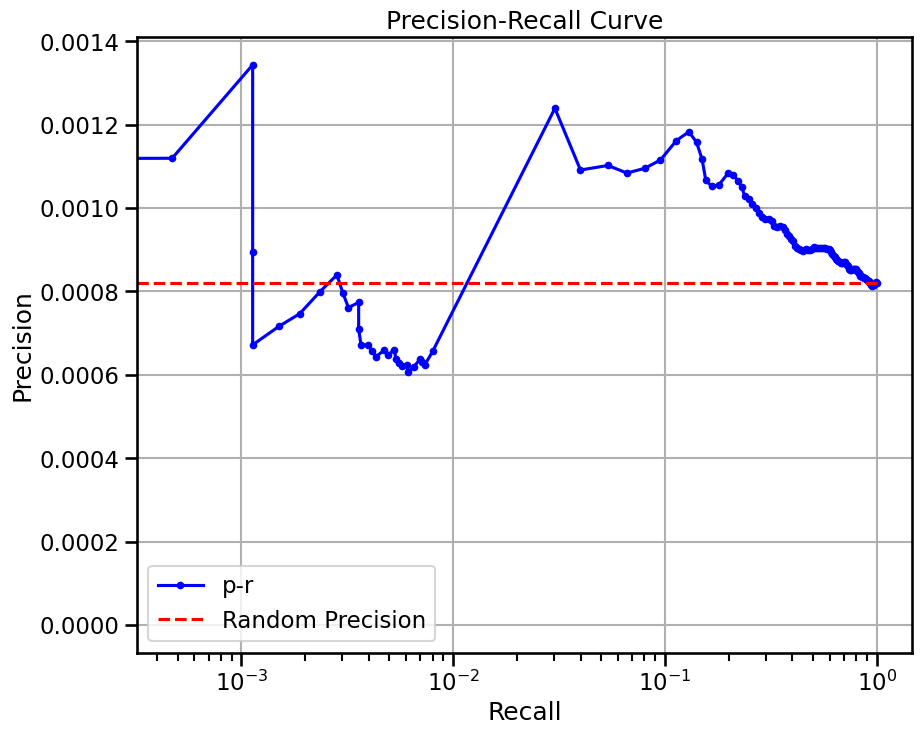

base enrichment


Top central genes: []


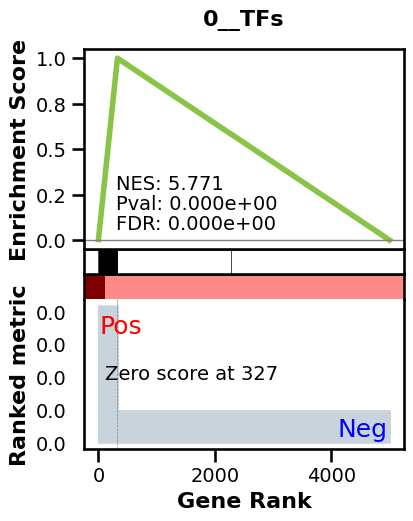

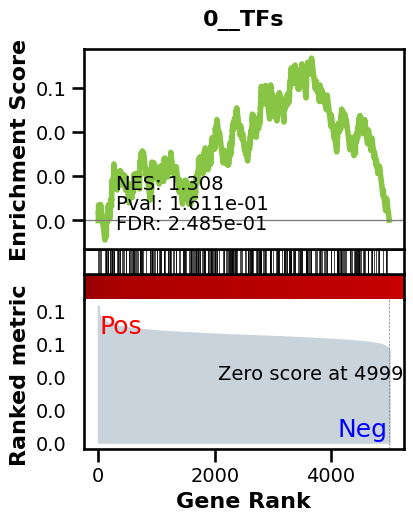

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3599 genes
intersection pct: 0.7198
precision:  0.0028948151476276903 
recall:  0.2766217870257038 
random precision: 0.0008202049825155249



  0%|          | 0/128 [00:00<?, ?it/s]


  5%|▍         | 6/128 [00:00<00:02, 53.94it/s]


  9%|▉         | 12/128 [00:00<00:02, 54.00it/s]


 14%|█▍        | 18/128 [00:00<00:02, 53.97it/s]


 19%|█▉        | 24/128 [00:00<00:01, 53.95it/s]


 23%|██▎       | 30/128 [00:00<00:01, 53.76it/s]


 28%|██▊       | 36/128 [00:00<00:01, 54.22it/s]


 33%|███▎      | 42/128 [00:00<00:01, 54.47it/s]


 38%|███▊      | 48/128 [00:00<00:01, 54.70it/s]


 42%|████▏     | 54/128 [00:00<00:01, 54.71it/s]


 47%|████▋     | 60/128 [00:01<00:01, 54.64it/s]


 52%|█████▏    | 66/128 [00:01<00:01, 54.77it/s]


 56%|█████▋    | 72/128 [00:01<00:01, 54.76it/s]


 61%|██████    | 78/128 [00:01<00:00, 54.83it/s]


 66%|██████▌   | 84/128 [00:01<00:00, 54.84it/s]


 70%|███████   | 90/128 [00:01<00:00, 54.81it/s]


 75%|███████▌  | 96/128 [00:01<00:00, 54.89it/s]


 80%|███████▉  | 102/128 [00:01<00:00, 54.98it/s]


 84%|████████▍ | 108/128 [00:01<00:00, 55.07it/s]


 89%|████████▉ | 114/128 [00:02<00:00, 54.61it/s]


 94%|█████████▍| 120/128 [00:02<00:00, 54.72it/s]


 98%|█████████▊| 126/128 [00:02<00:00, 54.60it/s]


100%|██████████| 128/128 [00:02<00:00, 54.59it/s]

Average Precision (AP):  0.0017331076496322822
Area Under Precision-Recall Curve (AUPRC):  0.0015064534496368313
EPR: 4.502569264854277


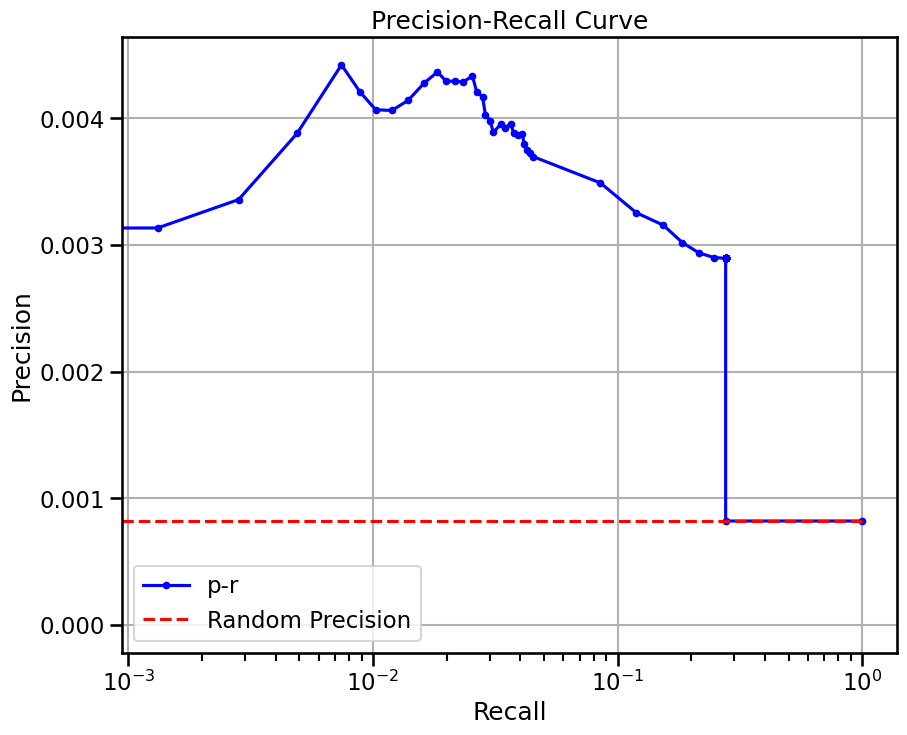


  0%|          | 0/205 [00:00<?, ?it/s]


  0%|          | 1/205 [00:00<01:11,  2.86it/s]


  1%|          | 2/205 [00:00<01:11,  2.84it/s]


  1%|▏         | 3/205 [00:01<01:10,  2.87it/s]


  2%|▏         | 4/205 [00:01<01:09,  2.89it/s]


  2%|▏         | 5/205 [00:01<01:09,  2.86it/s]


  3%|▎         | 6/205 [00:02<01:09,  2.85it/s]


  3%|▎         | 7/205 [00:02<01:08,  2.87it/s]


  4%|▍         | 8/205 [00:02<01:08,  2.88it/s]


  4%|▍         | 9/205 [00:03<01:07,  2.89it/s]


  5%|▍         | 10/205 [00:03<01:07,  2.88it/s]


  5%|▌         | 11/205 [00:03<01:07,  2.89it/s]


  6%|▌         | 12/205 [00:04<01:06,  2.90it/s]


  6%|▋         | 13/205 [00:04<01:06,  2.90it/s]


  7%|▋         | 14/205 [00:04<01:06,  2.89it/s]


  7%|▋         | 15/205 [00:05<01:05,  2.90it/s]


  8%|▊         | 16/205 [00:05<01:05,  2.88it/s]


  8%|▊         | 17/205 [00:05<01:05,  2.88it/s]


  9%|▉         | 18/205 [00:06<01:04,  2.89it/s]


  9%|▉         | 19/205 [00:06<01:04,  2.90it/s]


 10%|▉         | 20/205 [00:06<01:03,  2.90it/s]


 10%|█         | 21/205 [00:07<01:03,  2.90it/s]


 11%|█         | 22/205 [00:07<01:03,  2.90it/s]


 11%|█         | 23/205 [00:07<01:02,  2.90it/s]


 12%|█▏        | 24/205 [00:08<01:02,  2.91it/s]


 12%|█▏        | 25/205 [00:08<01:02,  2.90it/s]


 13%|█▎        | 26/205 [00:08<01:01,  2.91it/s]


 13%|█▎        | 27/205 [00:09<01:01,  2.90it/s]


 14%|█▎        | 28/205 [00:09<01:01,  2.89it/s]


 14%|█▍        | 29/205 [00:10<01:00,  2.90it/s]


 15%|█▍        | 30/205 [00:10<01:00,  2.90it/s]


 15%|█▌        | 31/205 [00:10<00:59,  2.91it/s]


 16%|█▌        | 32/205 [00:11<00:59,  2.91it/s]


 16%|█▌        | 33/205 [00:11<00:59,  2.90it/s]


 17%|█▋        | 34/205 [00:11<00:59,  2.89it/s]


 17%|█▋        | 35/205 [00:12<00:58,  2.90it/s]


 18%|█▊        | 36/205 [00:12<00:58,  2.91it/s]


 18%|█▊        | 37/205 [00:12<00:57,  2.91it/s]


 19%|█▊        | 38/205 [00:13<00:57,  2.92it/s]


 19%|█▉        | 39/205 [00:13<00:56,  2.92it/s]


 20%|█▉        | 40/205 [00:13<00:56,  2.90it/s]


 20%|██        | 41/205 [00:14<00:56,  2.91it/s]


 20%|██        | 42/205 [00:14<00:55,  2.92it/s]


 21%|██        | 43/205 [00:14<00:55,  2.92it/s]


 21%|██▏       | 44/205 [00:15<00:55,  2.92it/s]


 22%|██▏       | 45/205 [00:15<00:54,  2.92it/s]


 22%|██▏       | 46/205 [00:15<00:54,  2.91it/s]


 23%|██▎       | 47/205 [00:16<00:54,  2.89it/s]


 23%|██▎       | 48/205 [00:16<00:54,  2.89it/s]


 24%|██▍       | 49/205 [00:16<00:53,  2.90it/s]


 24%|██▍       | 50/205 [00:17<00:53,  2.89it/s]


 25%|██▍       | 51/205 [00:17<00:53,  2.90it/s]


 25%|██▌       | 52/205 [00:17<00:52,  2.91it/s]


 26%|██▌       | 53/205 [00:18<00:52,  2.91it/s]


 26%|██▋       | 54/205 [00:18<00:51,  2.92it/s]


 27%|██▋       | 55/205 [00:18<00:51,  2.92it/s]


 27%|██▋       | 56/205 [00:19<00:51,  2.90it/s]


 28%|██▊       | 57/205 [00:19<00:50,  2.91it/s]


 28%|██▊       | 58/205 [00:20<00:50,  2.91it/s]


 29%|██▉       | 59/205 [00:20<00:50,  2.91it/s]


 29%|██▉       | 60/205 [00:20<00:49,  2.92it/s]


 30%|██▉       | 61/205 [00:21<00:49,  2.90it/s]


 30%|███       | 62/205 [00:21<00:49,  2.89it/s]


 31%|███       | 63/205 [00:21<00:48,  2.90it/s]


 31%|███       | 64/205 [00:22<00:48,  2.91it/s]


 32%|███▏      | 65/205 [00:22<00:48,  2.89it/s]


 32%|███▏      | 66/205 [00:22<00:48,  2.89it/s]


 33%|███▎      | 67/205 [00:23<00:47,  2.88it/s]


 33%|███▎      | 68/205 [00:23<00:47,  2.89it/s]


 34%|███▎      | 69/205 [00:23<00:47,  2.89it/s]


 34%|███▍      | 70/205 [00:24<00:46,  2.90it/s]


 35%|███▍      | 71/205 [00:24<00:46,  2.89it/s]


 35%|███▌      | 72/205 [00:24<00:46,  2.88it/s]


 36%|███▌      | 73/205 [00:25<00:45,  2.89it/s]


 36%|███▌      | 74/205 [00:25<00:45,  2.90it/s]


 37%|███▋      | 75/205 [00:25<00:44,  2.89it/s]


 37%|███▋      | 76/205 [00:26<00:44,  2.90it/s]


 38%|███▊      | 77/205 [00:26<00:44,  2.89it/s]


 38%|███▊      | 78/205 [00:26<00:44,  2.88it/s]


 39%|███▊      | 79/205 [00:27<00:43,  2.88it/s]


 39%|███▉      | 80/205 [00:27<00:43,  2.87it/s]


 40%|███▉      | 81/205 [00:27<00:42,  2.89it/s]


 40%|████      | 82/205 [00:28<00:42,  2.90it/s]


 40%|████      | 83/205 [00:28<00:42,  2.90it/s]


 41%|████      | 84/205 [00:28<00:41,  2.91it/s]


 41%|████▏     | 85/205 [00:29<00:41,  2.91it/s]


 42%|████▏     | 86/205 [00:29<00:40,  2.92it/s]


 42%|████▏     | 87/205 [00:30<00:40,  2.90it/s]


 43%|████▎     | 88/205 [00:30<00:40,  2.91it/s]


 43%|████▎     | 89/205 [00:30<00:39,  2.91it/s]


 44%|████▍     | 90/205 [00:31<00:39,  2.90it/s]


 44%|████▍     | 91/205 [00:31<00:39,  2.89it/s]


 45%|████▍     | 92/205 [00:31<00:38,  2.90it/s]


 45%|████▌     | 93/205 [00:32<00:38,  2.91it/s]


 46%|████▌     | 94/205 [00:32<00:38,  2.91it/s]


 46%|████▋     | 95/205 [00:32<00:37,  2.91it/s]


 47%|████▋     | 96/205 [00:33<00:37,  2.91it/s]


 47%|████▋     | 97/205 [00:33<00:37,  2.91it/s]


 48%|████▊     | 98/205 [00:33<00:36,  2.91it/s]


 48%|████▊     | 99/205 [00:34<00:36,  2.91it/s]


 49%|████▉     | 100/205 [00:34<00:36,  2.91it/s]


 49%|████▉     | 101/205 [00:34<00:35,  2.89it/s]


 50%|████▉     | 102/205 [00:35<00:35,  2.88it/s]


 50%|█████     | 103/205 [00:35<00:35,  2.89it/s]


 51%|█████     | 104/205 [00:35<00:34,  2.90it/s]


 51%|█████     | 105/205 [00:36<00:34,  2.90it/s]


 52%|█████▏    | 106/205 [00:36<00:34,  2.90it/s]


 52%|█████▏    | 107/205 [00:36<00:33,  2.90it/s]


 53%|█████▎    | 108/205 [00:37<00:33,  2.89it/s]


 53%|█████▎    | 109/205 [00:37<00:33,  2.87it/s]


 54%|█████▎    | 110/205 [00:37<00:32,  2.88it/s]


 54%|█████▍    | 111/205 [00:38<00:32,  2.88it/s]


 55%|█████▍    | 112/205 [00:38<00:32,  2.89it/s]


 55%|█████▌    | 113/205 [00:38<00:31,  2.89it/s]


 56%|█████▌    | 114/205 [00:39<00:31,  2.90it/s]


 56%|█████▌    | 115/205 [00:39<00:31,  2.90it/s]


 57%|█████▋    | 116/205 [00:40<00:30,  2.90it/s]


 57%|█████▋    | 117/205 [00:40<00:30,  2.89it/s]


 58%|█████▊    | 118/205 [00:40<00:30,  2.89it/s]


 58%|█████▊    | 119/205 [00:41<00:29,  2.88it/s]


 59%|█████▊    | 120/205 [00:41<00:29,  2.89it/s]


 59%|█████▉    | 121/205 [00:41<00:29,  2.86it/s]


 60%|█████▉    | 122/205 [00:42<00:28,  2.87it/s]


 60%|██████    | 123/205 [00:42<00:28,  2.88it/s]


 60%|██████    | 124/205 [00:42<00:28,  2.89it/s]


 61%|██████    | 125/205 [00:43<00:27,  2.88it/s]


 61%|██████▏   | 126/205 [00:43<00:27,  2.89it/s]


 62%|██████▏   | 127/205 [00:43<00:27,  2.88it/s]


 62%|██████▏   | 128/205 [00:44<00:26,  2.89it/s]


 63%|██████▎   | 129/205 [00:44<00:26,  2.90it/s]


 63%|██████▎   | 130/205 [00:44<00:25,  2.91it/s]


 64%|██████▍   | 131/205 [00:45<00:25,  2.90it/s]


 64%|██████▍   | 132/205 [00:45<00:25,  2.89it/s]


 65%|██████▍   | 133/205 [00:45<00:25,  2.87it/s]


 65%|██████▌   | 134/205 [00:46<00:24,  2.88it/s]


 66%|██████▌   | 135/205 [00:46<00:24,  2.89it/s]


 66%|██████▋   | 136/205 [00:46<00:23,  2.90it/s]


 67%|██████▋   | 137/205 [00:47<00:23,  2.87it/s]


 67%|██████▋   | 138/205 [00:47<00:23,  2.89it/s]


 68%|██████▊   | 139/205 [00:47<00:22,  2.90it/s]


 68%|██████▊   | 140/205 [00:48<00:22,  2.90it/s]


 69%|██████▉   | 141/205 [00:48<00:22,  2.91it/s]


 69%|██████▉   | 142/205 [00:49<00:21,  2.89it/s]


 70%|██████▉   | 143/205 [00:49<00:21,  2.88it/s]


 70%|███████   | 144/205 [00:49<00:21,  2.88it/s]


 71%|███████   | 145/205 [00:50<00:20,  2.87it/s]


 71%|███████   | 146/205 [00:50<00:20,  2.89it/s]


 72%|███████▏  | 147/205 [00:50<00:20,  2.89it/s]


 72%|███████▏  | 148/205 [00:51<00:19,  2.90it/s]


 73%|███████▎  | 149/205 [00:51<00:19,  2.91it/s]


 73%|███████▎  | 150/205 [00:51<00:18,  2.91it/s]


 74%|███████▎  | 151/205 [00:52<00:18,  2.90it/s]


 74%|███████▍  | 152/205 [00:52<00:18,  2.90it/s]


 75%|███████▍  | 153/205 [00:52<00:17,  2.91it/s]


 75%|███████▌  | 154/205 [00:53<00:17,  2.91it/s]


 76%|███████▌  | 155/205 [00:53<00:17,  2.91it/s]


 76%|███████▌  | 156/205 [00:53<00:16,  2.92it/s]


 77%|███████▋  | 157/205 [00:54<00:16,  2.92it/s]


 77%|███████▋  | 158/205 [00:54<00:16,  2.90it/s]


 78%|███████▊  | 159/205 [00:54<00:15,  2.91it/s]


 78%|███████▊  | 160/205 [00:55<00:15,  2.91it/s]


 79%|███████▊  | 161/205 [00:55<00:15,  2.91it/s]


 79%|███████▉  | 162/205 [00:55<00:14,  2.90it/s]


 80%|███████▉  | 163/205 [00:56<00:14,  2.89it/s]


 80%|████████  | 164/205 [00:56<00:14,  2.90it/s]


 80%|████████  | 165/205 [00:56<00:13,  2.90it/s]


 81%|████████  | 166/205 [00:57<00:13,  2.91it/s]


 81%|████████▏ | 167/205 [00:57<00:13,  2.89it/s]


 82%|████████▏ | 168/205 [00:57<00:12,  2.90it/s]


 82%|████████▏ | 169/205 [00:58<00:12,  2.89it/s]


 83%|████████▎ | 170/205 [00:58<00:12,  2.90it/s]


 83%|████████▎ | 171/205 [00:59<00:11,  2.91it/s]


 84%|████████▍ | 172/205 [00:59<00:11,  2.91it/s]


 84%|████████▍ | 173/205 [00:59<00:11,  2.89it/s]


 85%|████████▍ | 174/205 [01:00<00:10,  2.88it/s]


 85%|████████▌ | 175/205 [01:00<00:10,  2.90it/s]


 86%|████████▌ | 176/205 [01:00<00:09,  2.90it/s]


 86%|████████▋ | 177/205 [01:01<00:09,  2.89it/s]


 87%|████████▋ | 178/205 [01:01<00:09,  2.90it/s]


 87%|████████▋ | 179/205 [01:01<00:08,  2.91it/s]


 88%|████████▊ | 180/205 [01:02<00:08,  2.89it/s]


 88%|████████▊ | 181/205 [01:02<00:08,  2.90it/s]


 89%|████████▉ | 182/205 [01:02<00:07,  2.91it/s]


 89%|████████▉ | 183/205 [01:03<00:07,  2.89it/s]


 90%|████████▉ | 184/205 [01:03<00:07,  2.90it/s]


 90%|█████████ | 185/205 [01:03<00:06,  2.90it/s]


 91%|█████████ | 186/205 [01:04<00:06,  2.90it/s]


 91%|█████████ | 187/205 [01:04<00:06,  2.91it/s]


 92%|█████████▏| 188/205 [01:04<00:05,  2.89it/s]


 92%|█████████▏| 189/205 [01:05<00:05,  2.90it/s]


 93%|█████████▎| 190/205 [01:05<00:05,  2.88it/s]


 93%|█████████▎| 191/205 [01:05<00:04,  2.87it/s]


 94%|█████████▎| 192/205 [01:06<00:04,  2.87it/s]


 94%|█████████▍| 193/205 [01:06<00:04,  2.86it/s]


 95%|█████████▍| 194/205 [01:06<00:03,  2.86it/s]


 95%|█████████▌| 195/205 [01:07<00:03,  2.87it/s]


 96%|█████████▌| 196/205 [01:07<00:03,  2.88it/s]


 96%|█████████▌| 197/205 [01:08<00:02,  2.87it/s]


 97%|█████████▋| 198/205 [01:08<00:02,  2.88it/s]


 97%|█████████▋| 199/205 [01:08<00:02,  2.89it/s]


 98%|█████████▊| 200/205 [01:09<00:01,  2.89it/s]


 98%|█████████▊| 201/205 [01:09<00:01,  2.88it/s]


 99%|█████████▊| 202/205 [01:09<00:01,  2.89it/s]


 99%|█████████▉| 203/205 [01:10<00:00,  2.88it/s]


100%|█████████▉| 204/205 [01:10<00:00,  2.87it/s]


100%|██████████| 205/205 [01:10<00:00,  3.02it/s]


100%|██████████| 205/205 [01:10<00:00,  2.90it/s]

base enrichment


Top central genes: []
The DataFrame contains only the same values.


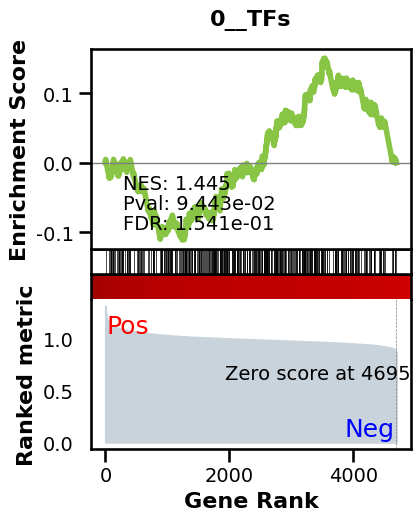

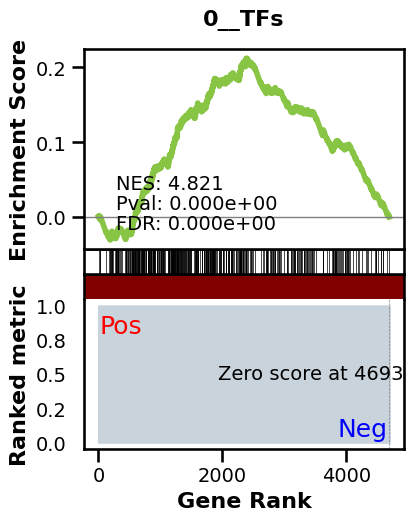

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3190 genes
intersection pct: 0.6793015332197615
precision:  0.0006976149998525958 
recall:  1.0 
random precision: 0.0006978337565160805



  0%|          | 0/128 [00:00<?, ?it/s]


  6%|▋         | 8/128 [00:00<00:01, 72.55it/s]


 12%|█▎        | 16/128 [00:00<00:01, 71.59it/s]


 19%|█▉        | 24/128 [00:00<00:01, 72.03it/s]


 25%|██▌       | 32/128 [00:00<00:01, 72.26it/s]


 31%|███▏      | 40/128 [00:00<00:01, 72.02it/s]


 38%|███▊      | 48/128 [00:00<00:01, 72.07it/s]


 44%|████▍     | 56/128 [00:00<00:01, 71.73it/s]


 50%|█████     | 64/128 [00:00<00:00, 71.59it/s]


 56%|█████▋    | 72/128 [00:01<00:00, 71.90it/s]


 62%|██████▎   | 80/128 [00:01<00:00, 71.88it/s]


 69%|██████▉   | 88/128 [00:01<00:00, 71.84it/s]


 75%|███████▌  | 96/128 [00:01<00:00, 72.06it/s]


 81%|████████▏ | 104/128 [00:01<00:00, 72.15it/s]


 88%|████████▊ | 112/128 [00:01<00:00, 72.09it/s]


 94%|█████████▍| 120/128 [00:01<00:00, 72.03it/s]


100%|██████████| 128/128 [00:01<00:00, 72.11it/s]


100%|██████████| 128/128 [00:01<00:00, 71.97it/s]

Average Precision (AP):  0.000785494502182548
Area Under Precision-Recall Curve (AUPRC):  0.0007773020049428632
EPR: 3.0365011050741906


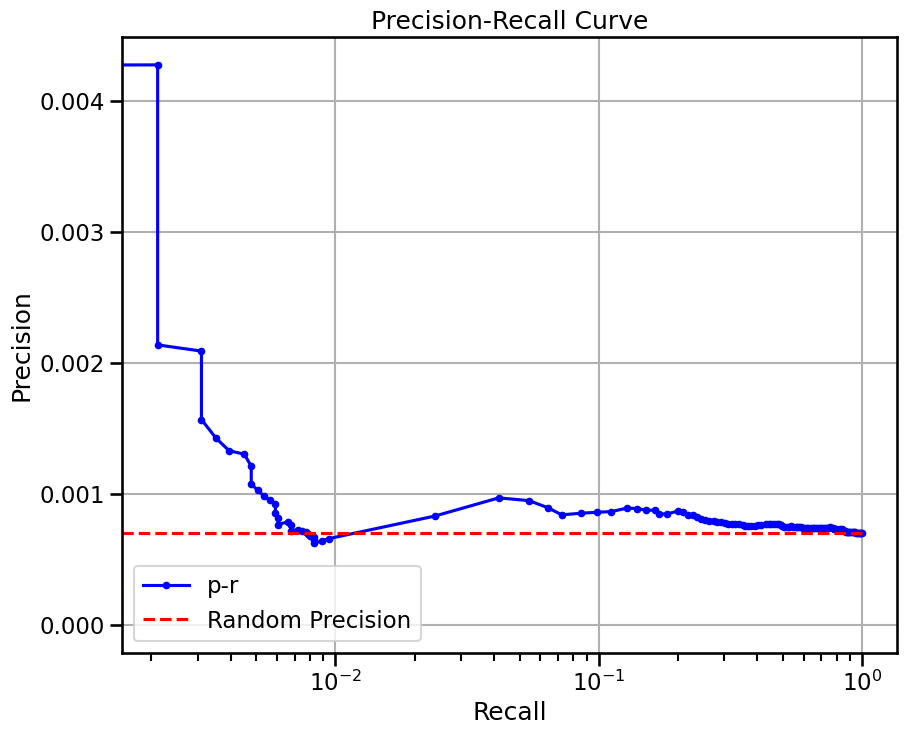

base enrichment


Top central genes: []


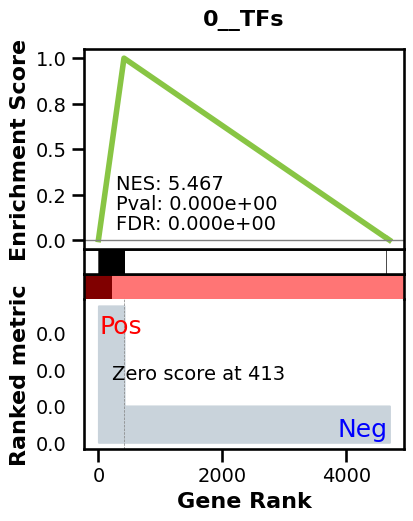

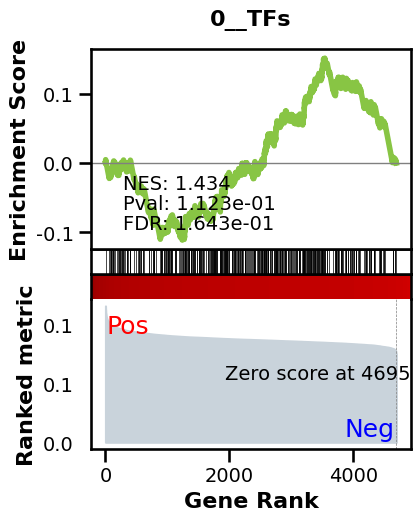

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3190 genes
intersection pct: 0.6793015332197615
precision:  0.0018386612893084586 
recall:  0.28835047189745033 
random precision: 0.0006978337565160805



  0%|          | 0/128 [00:00<?, ?it/s]


  6%|▋         | 8/128 [00:00<00:01, 72.96it/s]


 12%|█▎        | 16/128 [00:00<00:01, 72.50it/s]


 19%|█▉        | 24/128 [00:00<00:01, 72.65it/s]


 25%|██▌       | 32/128 [00:00<00:01, 72.76it/s]


 31%|███▏      | 40/128 [00:00<00:01, 72.76it/s]


 38%|███▊      | 48/128 [00:00<00:01, 72.77it/s]


 44%|████▍     | 56/128 [00:00<00:00, 72.13it/s]


 50%|█████     | 64/128 [00:00<00:00, 71.95it/s]


 56%|█████▋    | 72/128 [00:00<00:00, 71.84it/s]


 62%|██████▎   | 80/128 [00:01<00:00, 71.79it/s]


 69%|██████▉   | 88/128 [00:01<00:00, 71.73it/s]


 75%|███████▌  | 96/128 [00:01<00:00, 71.69it/s]


 81%|████████▏ | 104/128 [00:01<00:00, 71.74it/s]


 88%|████████▊ | 112/128 [00:01<00:00, 71.88it/s]


 94%|█████████▍| 120/128 [00:01<00:00, 71.72it/s]


100%|██████████| 128/128 [00:01<00:00, 71.58it/s]


100%|██████████| 128/128 [00:01<00:00, 71.97it/s]

Average Precision (AP):  0.0013619241682363708
Area Under Precision-Recall Curve (AUPRC):  0.0011410552177721326
EPR: 4.666505897689656


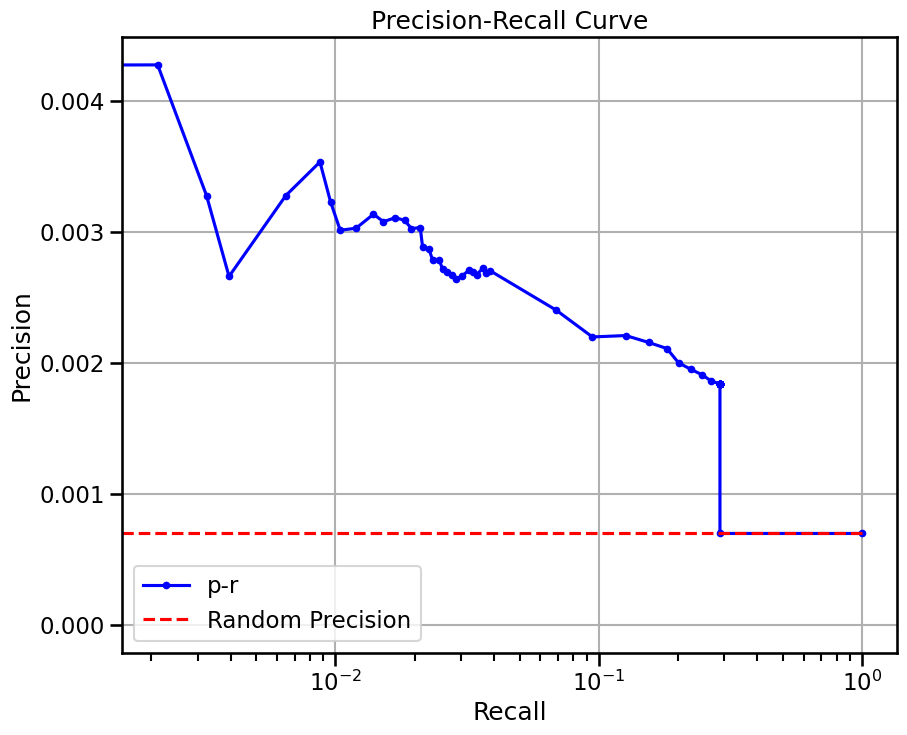


  0%|          | 0/205 [00:00<?, ?it/s]


  0%|          | 1/205 [00:00<01:12,  2.82it/s]


  1%|          | 2/205 [00:00<01:13,  2.75it/s]


  1%|▏         | 3/205 [00:01<01:12,  2.77it/s]


  2%|▏         | 4/205 [00:01<01:13,  2.74it/s]


  2%|▏         | 5/205 [00:01<01:13,  2.73it/s]


  3%|▎         | 6/205 [00:02<01:12,  2.75it/s]


  3%|▎         | 7/205 [00:02<01:12,  2.74it/s]


  4%|▍         | 8/205 [00:02<01:11,  2.75it/s]


  4%|▍         | 9/205 [00:03<01:11,  2.74it/s]


  5%|▍         | 10/205 [00:03<01:10,  2.75it/s]


  5%|▌         | 11/205 [00:04<01:10,  2.74it/s]


  6%|▌         | 12/205 [00:04<01:10,  2.73it/s]


  6%|▋         | 13/205 [00:04<01:09,  2.74it/s]


  7%|▋         | 14/205 [00:05<01:09,  2.76it/s]


  7%|▋         | 15/205 [00:05<01:10,  2.71it/s]


  8%|▊         | 16/205 [00:05<01:13,  2.57it/s]


  8%|▊         | 17/205 [00:06<01:12,  2.61it/s]


  9%|▉         | 18/205 [00:06<01:10,  2.64it/s]


  9%|▉         | 19/205 [00:07<01:09,  2.66it/s]


 10%|▉         | 20/205 [00:07<01:09,  2.67it/s]


 10%|█         | 21/205 [00:07<01:08,  2.68it/s]


 11%|█         | 22/205 [00:08<01:08,  2.69it/s]


 11%|█         | 23/205 [00:08<01:07,  2.68it/s]


 12%|█▏        | 24/205 [00:08<01:07,  2.69it/s]


 12%|█▏        | 25/205 [00:09<01:06,  2.69it/s]


 13%|█▎        | 26/205 [00:09<01:06,  2.71it/s]


 13%|█▎        | 27/205 [00:09<01:05,  2.71it/s]


 14%|█▎        | 28/205 [00:10<01:04,  2.73it/s]


 14%|█▍        | 29/205 [00:10<01:04,  2.74it/s]


 15%|█▍        | 30/205 [00:11<01:03,  2.75it/s]


 15%|█▌        | 31/205 [00:11<01:03,  2.74it/s]


 16%|█▌        | 32/205 [00:11<01:02,  2.75it/s]


 16%|█▌        | 33/205 [00:12<01:02,  2.74it/s]


 17%|█▋        | 34/205 [00:12<01:02,  2.75it/s]


 17%|█▋        | 35/205 [00:12<01:02,  2.74it/s]


 18%|█▊        | 36/205 [00:13<01:01,  2.74it/s]


 18%|█▊        | 37/205 [00:13<01:01,  2.75it/s]


 19%|█▊        | 38/205 [00:13<01:00,  2.76it/s]


 19%|█▉        | 39/205 [00:14<01:00,  2.75it/s]


 20%|█▉        | 40/205 [00:14<00:59,  2.75it/s]


 20%|██        | 41/205 [00:15<00:59,  2.76it/s]


 20%|██        | 42/205 [00:15<00:59,  2.74it/s]


 21%|██        | 43/205 [00:15<00:59,  2.74it/s]


 21%|██▏       | 44/205 [00:16<00:59,  2.73it/s]


 22%|██▏       | 45/205 [00:16<00:58,  2.72it/s]


 22%|██▏       | 46/205 [00:16<00:58,  2.74it/s]


 23%|██▎       | 47/205 [00:17<00:57,  2.73it/s]


 23%|██▎       | 48/205 [00:17<00:57,  2.74it/s]


 24%|██▍       | 49/205 [00:17<00:56,  2.75it/s]


 24%|██▍       | 50/205 [00:18<00:56,  2.74it/s]


 25%|██▍       | 51/205 [00:18<00:56,  2.73it/s]


 25%|██▌       | 52/205 [00:19<00:56,  2.72it/s]


 26%|██▌       | 53/205 [00:19<00:55,  2.74it/s]


 26%|██▋       | 54/205 [00:19<00:55,  2.73it/s]


 27%|██▋       | 55/205 [00:20<00:54,  2.74it/s]


 27%|██▋       | 56/205 [00:20<00:54,  2.75it/s]


 28%|██▊       | 57/205 [00:20<00:53,  2.74it/s]


 28%|██▊       | 58/205 [00:21<00:53,  2.75it/s]


 29%|██▉       | 59/205 [00:21<00:53,  2.74it/s]


 29%|██▉       | 60/205 [00:22<00:52,  2.75it/s]


 30%|██▉       | 61/205 [00:22<00:52,  2.74it/s]


 30%|███       | 62/205 [00:22<00:51,  2.75it/s]


 31%|███       | 63/205 [00:23<00:51,  2.74it/s]


 31%|███       | 64/205 [00:23<00:51,  2.73it/s]


 32%|███▏      | 65/205 [00:23<00:51,  2.74it/s]


 32%|███▏      | 66/205 [00:24<00:50,  2.75it/s]


 33%|███▎      | 67/205 [00:24<00:50,  2.74it/s]


 33%|███▎      | 68/205 [00:24<00:50,  2.73it/s]


 34%|███▎      | 69/205 [00:25<00:49,  2.72it/s]


 34%|███▍      | 70/205 [00:25<00:49,  2.72it/s]


 35%|███▍      | 71/205 [00:26<00:48,  2.74it/s]


 35%|███▌      | 72/205 [00:26<00:48,  2.75it/s]


 36%|███▌      | 73/205 [00:26<00:48,  2.73it/s]


 36%|███▌      | 74/205 [00:27<00:48,  2.73it/s]


 37%|███▋      | 75/205 [00:27<00:47,  2.72it/s]


 37%|███▋      | 76/205 [00:27<00:47,  2.72it/s]


 38%|███▊      | 77/205 [00:28<00:47,  2.71it/s]


 38%|███▊      | 78/205 [00:28<00:46,  2.73it/s]


 39%|███▊      | 79/205 [00:28<00:45,  2.75it/s]


 39%|███▉      | 80/205 [00:29<00:45,  2.73it/s]


 40%|███▉      | 81/205 [00:29<00:45,  2.73it/s]


 40%|████      | 82/205 [00:30<00:45,  2.72it/s]


 40%|████      | 83/205 [00:30<00:44,  2.74it/s]


 41%|████      | 84/205 [00:30<00:44,  2.75it/s]


 41%|████▏     | 85/205 [00:31<00:43,  2.74it/s]


 42%|████▏     | 86/205 [00:31<00:43,  2.75it/s]


 42%|████▏     | 87/205 [00:31<00:43,  2.74it/s]


 43%|████▎     | 88/205 [00:32<00:42,  2.75it/s]


 43%|████▎     | 89/205 [00:32<00:42,  2.74it/s]


 44%|████▍     | 90/205 [00:32<00:41,  2.75it/s]


 44%|████▍     | 91/205 [00:33<00:41,  2.74it/s]


 45%|████▍     | 92/205 [00:33<00:41,  2.75it/s]


 45%|████▌     | 93/205 [00:34<00:40,  2.76it/s]


 46%|████▌     | 94/205 [00:34<00:40,  2.77it/s]


 46%|████▋     | 95/205 [00:34<00:39,  2.75it/s]


 47%|████▋     | 96/205 [00:35<00:39,  2.74it/s]


 47%|████▋     | 97/205 [00:35<00:39,  2.76it/s]


 48%|████▊     | 98/205 [00:35<00:38,  2.76it/s]


 48%|████▊     | 99/205 [00:36<00:38,  2.75it/s]


 49%|████▉     | 100/205 [00:36<00:38,  2.74it/s]


 49%|████▉     | 101/205 [00:36<00:38,  2.73it/s]


 50%|████▉     | 102/205 [00:37<00:37,  2.75it/s]


 50%|█████     | 103/205 [00:37<00:36,  2.76it/s]


 51%|█████     | 104/205 [00:38<00:36,  2.74it/s]


 51%|█████     | 105/205 [00:38<00:36,  2.74it/s]


 52%|█████▏    | 106/205 [00:38<00:36,  2.73it/s]


 52%|█████▏    | 107/205 [00:39<00:35,  2.74it/s]


 53%|█████▎    | 108/205 [00:39<00:35,  2.75it/s]


 53%|█████▎    | 109/205 [00:39<00:34,  2.74it/s]


 54%|█████▎    | 110/205 [00:40<00:34,  2.75it/s]


 54%|█████▍    | 111/205 [00:40<00:34,  2.76it/s]


 55%|█████▍    | 112/205 [00:40<00:33,  2.75it/s]


 55%|█████▌    | 113/205 [00:41<00:33,  2.76it/s]


 56%|█████▌    | 114/205 [00:41<00:33,  2.75it/s]


 56%|█████▌    | 115/205 [00:42<00:32,  2.76it/s]


 57%|█████▋    | 116/205 [00:42<00:32,  2.74it/s]


 57%|█████▋    | 117/205 [00:42<00:32,  2.73it/s]


 58%|█████▊    | 118/205 [00:43<00:31,  2.75it/s]


 58%|█████▊    | 119/205 [00:43<00:31,  2.73it/s]


 59%|█████▊    | 120/205 [00:43<00:30,  2.75it/s]


 59%|█████▉    | 121/205 [00:44<00:30,  2.76it/s]


 60%|█████▉    | 122/205 [00:44<00:30,  2.74it/s]


 60%|██████    | 123/205 [00:44<00:30,  2.73it/s]


 60%|██████    | 124/205 [00:45<00:29,  2.72it/s]


 61%|██████    | 125/205 [00:45<00:29,  2.74it/s]


 61%|██████▏   | 126/205 [00:46<00:28,  2.75it/s]


 62%|██████▏   | 127/205 [00:46<00:28,  2.74it/s]


 62%|██████▏   | 128/205 [00:46<00:28,  2.73it/s]


 63%|██████▎   | 129/205 [00:47<00:27,  2.74it/s]


 63%|██████▎   | 130/205 [00:47<00:27,  2.73it/s]


 64%|██████▍   | 131/205 [00:47<00:27,  2.73it/s]


 64%|██████▍   | 132/205 [00:48<00:26,  2.72it/s]


 65%|██████▍   | 133/205 [00:48<00:26,  2.74it/s]


 65%|██████▌   | 134/205 [00:48<00:25,  2.75it/s]


 66%|██████▌   | 135/205 [00:49<00:25,  2.74it/s]


 66%|██████▋   | 136/205 [00:49<00:25,  2.73it/s]


 67%|██████▋   | 137/205 [00:50<00:24,  2.73it/s]


 67%|██████▋   | 138/205 [00:50<00:24,  2.72it/s]


 68%|██████▊   | 139/205 [00:50<00:24,  2.72it/s]


 68%|██████▊   | 140/205 [00:51<00:23,  2.71it/s]


 69%|██████▉   | 141/205 [00:51<00:23,  2.71it/s]


 69%|██████▉   | 142/205 [00:51<00:23,  2.71it/s]


 70%|██████▉   | 143/205 [00:52<00:22,  2.73it/s]


 70%|███████   | 144/205 [00:52<00:22,  2.72it/s]


 71%|███████   | 145/205 [00:53<00:21,  2.74it/s]


 71%|███████   | 146/205 [00:53<00:21,  2.75it/s]


 72%|███████▏  | 147/205 [00:53<00:21,  2.74it/s]


 72%|███████▏  | 148/205 [00:54<00:20,  2.73it/s]


 73%|███████▎  | 149/205 [00:54<00:20,  2.72it/s]


 73%|███████▎  | 150/205 [00:54<00:20,  2.72it/s]


 74%|███████▎  | 151/205 [00:55<00:19,  2.72it/s]


 74%|███████▍  | 152/205 [00:55<00:19,  2.72it/s]


 75%|███████▍  | 153/205 [00:55<00:18,  2.74it/s]


 75%|███████▌  | 154/205 [00:56<00:18,  2.75it/s]


 76%|███████▌  | 155/205 [00:56<00:18,  2.74it/s]


 76%|███████▌  | 156/205 [00:57<00:17,  2.75it/s]


 77%|███████▋  | 157/205 [00:57<00:17,  2.74it/s]


 77%|███████▋  | 158/205 [00:57<00:17,  2.75it/s]


 78%|███████▊  | 159/205 [00:58<00:16,  2.76it/s]


 78%|███████▊  | 160/205 [00:58<00:16,  2.74it/s]


 79%|███████▊  | 161/205 [00:58<00:16,  2.73it/s]


 79%|███████▉  | 162/205 [00:59<00:15,  2.74it/s]


 80%|███████▉  | 163/205 [00:59<00:15,  2.73it/s]


 80%|████████  | 164/205 [00:59<00:14,  2.74it/s]


 80%|████████  | 165/205 [01:00<00:14,  2.73it/s]


 81%|████████  | 166/205 [01:00<00:14,  2.72it/s]


 81%|████████▏ | 167/205 [01:01<00:13,  2.74it/s]


 82%|████████▏ | 168/205 [01:01<00:13,  2.75it/s]


 82%|████████▏ | 169/205 [01:01<00:13,  2.74it/s]


 83%|████████▎ | 170/205 [01:02<00:12,  2.75it/s]


 83%|████████▎ | 171/205 [01:02<00:12,  2.73it/s]


 84%|████████▍ | 172/205 [01:02<00:12,  2.75it/s]


 84%|████████▍ | 173/205 [01:03<00:11,  2.75it/s]


 85%|████████▍ | 174/205 [01:03<00:11,  2.75it/s]


 85%|████████▌ | 175/205 [01:03<00:10,  2.74it/s]


 86%|████████▌ | 176/205 [01:04<00:10,  2.75it/s]


 86%|████████▋ | 177/205 [01:04<00:10,  2.76it/s]


 87%|████████▋ | 178/205 [01:05<00:09,  2.76it/s]


 87%|████████▋ | 179/205 [01:05<00:09,  2.75it/s]


 88%|████████▊ | 180/205 [01:05<00:09,  2.73it/s]


 88%|████████▊ | 181/205 [01:06<00:08,  2.70it/s]


 89%|████████▉ | 182/205 [01:06<00:08,  2.72it/s]


 89%|████████▉ | 183/205 [01:06<00:08,  2.72it/s]


 90%|████████▉ | 184/205 [01:07<00:07,  2.73it/s]


 90%|█████████ | 185/205 [01:07<00:07,  2.73it/s]


 91%|█████████ | 186/205 [01:08<00:06,  2.74it/s]


 91%|█████████ | 187/205 [01:08<00:06,  2.73it/s]


 92%|█████████▏| 188/205 [01:08<00:06,  2.72it/s]


 92%|█████████▏| 189/205 [01:09<00:05,  2.72it/s]


 93%|█████████▎| 190/205 [01:09<00:05,  2.71it/s]


 93%|█████████▎| 191/205 [01:09<00:05,  2.71it/s]


 94%|█████████▎| 192/205 [01:10<00:04,  2.71it/s]


 94%|█████████▍| 193/205 [01:10<00:04,  2.71it/s]


 95%|█████████▍| 194/205 [01:10<00:04,  2.71it/s]


 95%|█████████▌| 195/205 [01:11<00:03,  2.73it/s]


 96%|█████████▌| 196/205 [01:11<00:03,  2.74it/s]


 96%|█████████▌| 197/205 [01:12<00:02,  2.74it/s]


 97%|█████████▋| 198/205 [01:12<00:02,  2.73it/s]


 97%|█████████▋| 199/205 [01:12<00:02,  2.73it/s]


 98%|█████████▊| 200/205 [01:13<00:01,  2.72it/s]


 98%|█████████▊| 201/205 [01:13<00:01,  2.74it/s]


 99%|█████████▊| 202/205 [01:13<00:01,  2.75it/s]


 99%|█████████▉| 203/205 [01:14<00:00,  2.74it/s]


100%|█████████▉| 204/205 [01:14<00:00,  2.73it/s]


100%|██████████| 205/205 [01:14<00:00,  2.89it/s]


100%|██████████| 205/205 [01:14<00:00,  2.74it/s]

base enrichment


Top central genes: []
The DataFrame contains only the same values.


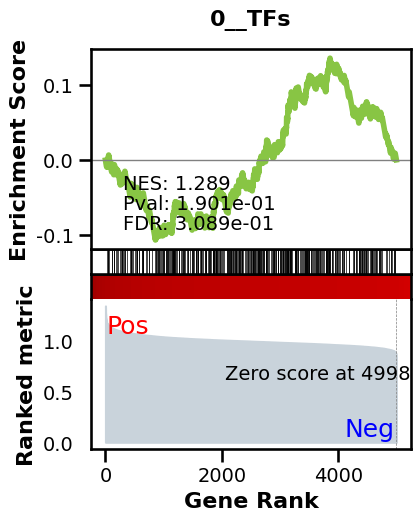

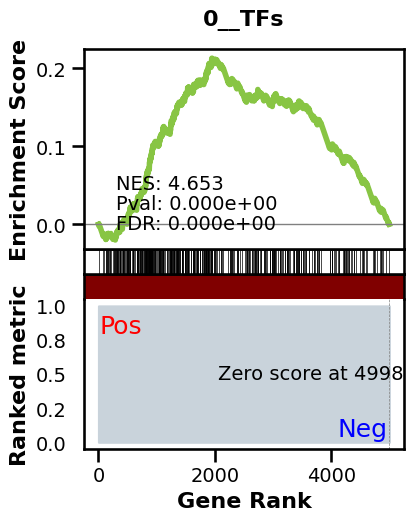

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3520 genes
intersection pct: 0.7041408281656332
precision:  0.0006723753873966942 
recall:  1.0 
random precision: 0.0006725664574130047



  0%|          | 0/128 [00:00<?, ?it/s]


  5%|▍         | 6/128 [00:00<00:02, 57.17it/s]


  9%|▉         | 12/128 [00:00<00:02, 56.96it/s]


 14%|█▍        | 18/128 [00:00<00:01, 56.99it/s]


 19%|█▉        | 24/128 [00:00<00:01, 56.59it/s]


 23%|██▎       | 30/128 [00:00<00:01, 56.86it/s]


 28%|██▊       | 36/128 [00:00<00:01, 56.91it/s]


 33%|███▎      | 42/128 [00:00<00:01, 56.79it/s]


 38%|███▊      | 48/128 [00:00<00:01, 56.15it/s]


 42%|████▏     | 54/128 [00:00<00:01, 55.68it/s]


 47%|████▋     | 60/128 [00:01<00:01, 56.28it/s]


 52%|█████▏    | 66/128 [00:01<00:01, 56.44it/s]


 56%|█████▋    | 72/128 [00:01<00:00, 56.67it/s]


 61%|██████    | 78/128 [00:01<00:00, 56.71it/s]


 66%|██████▌   | 84/128 [00:01<00:00, 57.22it/s]


 70%|███████   | 90/128 [00:01<00:00, 57.34it/s]


 75%|███████▌  | 96/128 [00:01<00:00, 57.60it/s]


 80%|███████▉  | 102/128 [00:01<00:00, 57.45it/s]


 84%|████████▍ | 108/128 [00:01<00:00, 57.64it/s]


 89%|████████▉ | 114/128 [00:02<00:00, 57.42it/s]


 94%|█████████▍| 120/128 [00:02<00:00, 57.68it/s]


 98%|█████████▊| 126/128 [00:02<00:00, 57.63it/s]


100%|██████████| 128/128 [00:02<00:00, 57.01it/s]

Average Precision (AP):  0.000768304183233778
Area Under Precision-Recall Curve (AUPRC):  0.0007664898307962315


EPR: 3.401892236811512


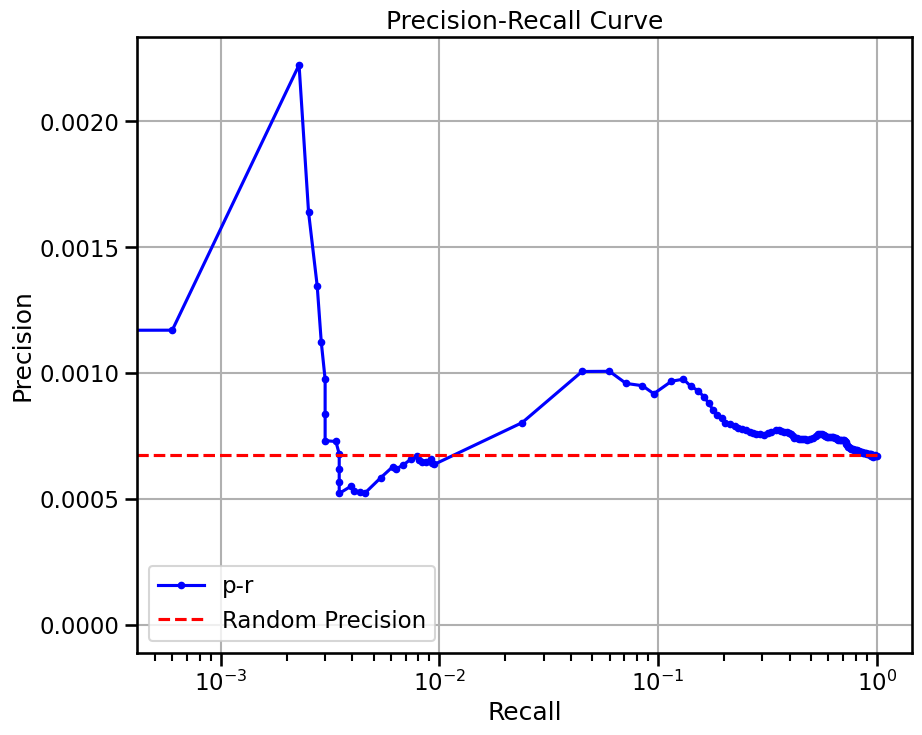

base enrichment


Top central genes: []


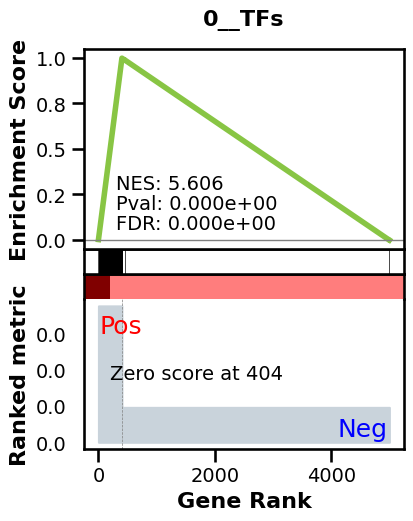

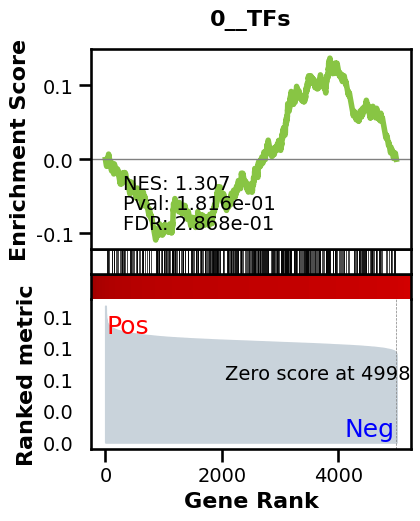

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3520 genes
intersection pct: 0.7041408281656332
precision:  0.0016901718073593073 
recall:  0.23994718521185932 
random precision: 0.0006725664574130047



  0%|          | 0/128 [00:00<?, ?it/s]


  5%|▍         | 6/128 [00:00<00:02, 59.72it/s]


  9%|▉         | 12/128 [00:00<00:01, 59.72it/s]


 14%|█▍        | 18/128 [00:00<00:01, 59.73it/s]


 20%|█▉        | 25/128 [00:00<00:01, 59.93it/s]


 24%|██▍       | 31/128 [00:00<00:01, 59.82it/s]


 30%|██▉       | 38/128 [00:00<00:01, 59.92it/s]


 35%|███▌      | 45/128 [00:00<00:01, 60.06it/s]


 41%|████      | 52/128 [00:00<00:01, 60.06it/s]


 46%|████▌     | 59/128 [00:00<00:01, 60.01it/s]


 52%|█████▏    | 66/128 [00:01<00:01, 60.23it/s]


 57%|█████▋    | 73/128 [00:01<00:00, 60.29it/s]


 62%|██████▎   | 80/128 [00:01<00:00, 60.10it/s]


 68%|██████▊   | 87/128 [00:01<00:00, 60.29it/s]


 73%|███████▎  | 94/128 [00:01<00:00, 60.31it/s]


 79%|███████▉  | 101/128 [00:01<00:00, 60.04it/s]


 84%|████████▍ | 108/128 [00:01<00:00, 60.23it/s]


 90%|████████▉ | 115/128 [00:01<00:00, 60.34it/s]


 95%|█████████▌| 122/128 [00:02<00:00, 60.20it/s]


100%|██████████| 128/128 [00:02<00:00, 60.11it/s]

Average Precision (AP):  0.0011229413428230437
Area Under Precision-Recall Curve (AUPRC):  0.0010001551476084315
EPR: 3.401892236811512


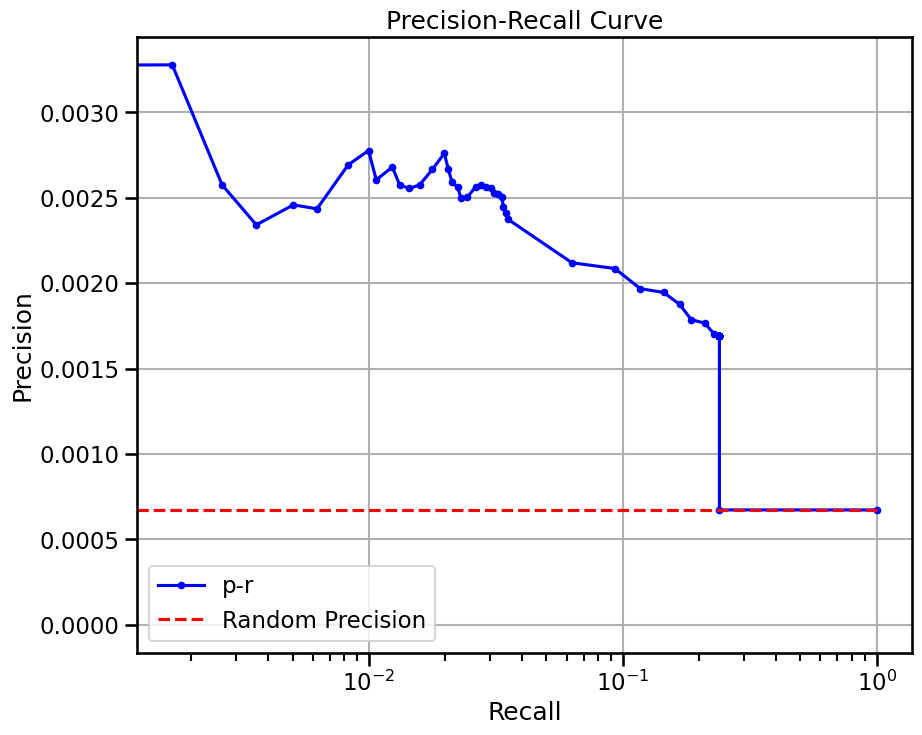


  0%|          | 0/205 [00:00<?, ?it/s]


  0%|          | 1/205 [00:00<02:17,  1.48it/s]


  1%|          | 2/205 [00:01<02:17,  1.48it/s]


  1%|▏         | 3/205 [00:02<02:15,  1.49it/s]


  2%|▏         | 4/205 [00:02<02:15,  1.48it/s]


  2%|▏         | 5/205 [00:03<02:14,  1.48it/s]


  3%|▎         | 6/205 [00:04<02:14,  1.48it/s]


  3%|▎         | 7/205 [00:04<02:14,  1.48it/s]


  4%|▍         | 8/205 [00:05<02:13,  1.48it/s]


  4%|▍         | 9/205 [00:06<02:12,  1.48it/s]


  5%|▍         | 10/205 [00:06<02:12,  1.48it/s]


  5%|▌         | 11/205 [00:07<02:10,  1.48it/s]


  6%|▌         | 12/205 [00:08<02:09,  1.49it/s]


  6%|▋         | 13/205 [00:08<02:09,  1.48it/s]


  7%|▋         | 14/205 [00:09<02:08,  1.48it/s]


  7%|▋         | 15/205 [00:10<02:08,  1.48it/s]


  8%|▊         | 16/205 [00:10<02:07,  1.48it/s]


  8%|▊         | 17/205 [00:11<02:06,  1.49it/s]


  9%|▉         | 18/205 [00:12<02:06,  1.48it/s]


  9%|▉         | 19/205 [00:12<02:05,  1.49it/s]


 10%|▉         | 20/205 [00:13<02:04,  1.49it/s]


 10%|█         | 21/205 [00:14<02:04,  1.48it/s]


 11%|█         | 22/205 [00:14<02:03,  1.49it/s]


 11%|█         | 23/205 [00:15<02:02,  1.48it/s]


 12%|█▏        | 24/205 [00:16<02:01,  1.48it/s]


 12%|█▏        | 25/205 [00:16<02:01,  1.48it/s]


 13%|█▎        | 26/205 [00:17<02:01,  1.48it/s]


 13%|█▎        | 27/205 [00:18<02:00,  1.47it/s]


 14%|█▎        | 28/205 [00:18<02:00,  1.47it/s]


 14%|█▍        | 29/205 [00:19<01:59,  1.47it/s]


 15%|█▍        | 30/205 [00:20<01:59,  1.47it/s]


 15%|█▌        | 31/205 [00:20<01:58,  1.47it/s]


 16%|█▌        | 32/205 [00:21<01:57,  1.47it/s]


 16%|█▌        | 33/205 [00:22<01:57,  1.47it/s]


 17%|█▋        | 34/205 [00:22<01:56,  1.47it/s]


 17%|█▋        | 35/205 [00:23<01:55,  1.47it/s]


 18%|█▊        | 36/205 [00:24<01:55,  1.46it/s]


 18%|█▊        | 37/205 [00:25<01:54,  1.46it/s]


 19%|█▊        | 38/205 [00:25<01:54,  1.46it/s]


 19%|█▉        | 39/205 [00:26<01:53,  1.47it/s]


 20%|█▉        | 40/205 [00:27<01:52,  1.47it/s]


 20%|██        | 41/205 [00:27<01:51,  1.47it/s]


 20%|██        | 42/205 [00:28<01:50,  1.47it/s]


 21%|██        | 43/205 [00:29<01:49,  1.48it/s]


 21%|██▏       | 44/205 [00:29<01:48,  1.48it/s]


 22%|██▏       | 45/205 [00:30<01:48,  1.47it/s]


 22%|██▏       | 46/205 [00:31<01:47,  1.48it/s]


 23%|██▎       | 47/205 [00:31<01:47,  1.47it/s]


 23%|██▎       | 48/205 [00:32<01:46,  1.47it/s]


 24%|██▍       | 49/205 [00:33<01:46,  1.47it/s]


 24%|██▍       | 50/205 [00:33<01:45,  1.47it/s]


 25%|██▍       | 51/205 [00:34<01:44,  1.48it/s]


 25%|██▌       | 52/205 [00:35<01:44,  1.47it/s]


 26%|██▌       | 53/205 [00:35<01:43,  1.47it/s]


 26%|██▋       | 54/205 [00:36<01:42,  1.47it/s]


 27%|██▋       | 55/205 [00:37<01:42,  1.46it/s]


 27%|██▋       | 56/205 [00:37<01:41,  1.46it/s]


 28%|██▊       | 57/205 [00:38<01:41,  1.46it/s]


 28%|██▊       | 58/205 [00:39<01:40,  1.46it/s]


 29%|██▉       | 59/205 [00:40<01:40,  1.45it/s]


 29%|██▉       | 60/205 [00:40<01:39,  1.45it/s]


 30%|██▉       | 61/205 [00:41<01:39,  1.45it/s]


 30%|███       | 62/205 [00:42<01:38,  1.46it/s]


 31%|███       | 63/205 [00:42<01:37,  1.46it/s]


 31%|███       | 64/205 [00:43<01:36,  1.46it/s]


 32%|███▏      | 65/205 [00:44<01:36,  1.46it/s]


 32%|███▏      | 66/205 [00:44<01:35,  1.46it/s]


 33%|███▎      | 67/205 [00:45<01:34,  1.46it/s]


 33%|███▎      | 68/205 [00:46<01:33,  1.46it/s]


 34%|███▎      | 69/205 [00:46<01:33,  1.46it/s]


 34%|███▍      | 70/205 [00:47<01:32,  1.46it/s]


 35%|███▍      | 71/205 [00:48<01:31,  1.46it/s]


 35%|███▌      | 72/205 [00:48<01:31,  1.45it/s]


 36%|███▌      | 73/205 [00:49<01:30,  1.46it/s]


 36%|███▌      | 74/205 [00:50<01:29,  1.46it/s]


 37%|███▋      | 75/205 [00:51<01:29,  1.46it/s]


 37%|███▋      | 76/205 [00:51<01:28,  1.46it/s]


 38%|███▊      | 77/205 [00:52<01:27,  1.46it/s]


 38%|███▊      | 78/205 [00:53<01:27,  1.46it/s]


 39%|███▊      | 79/205 [00:53<01:26,  1.46it/s]


 39%|███▉      | 80/205 [00:54<01:25,  1.46it/s]


 40%|███▉      | 81/205 [00:55<01:24,  1.46it/s]


 40%|████      | 82/205 [00:55<01:23,  1.47it/s]


 40%|████      | 83/205 [00:56<01:23,  1.46it/s]


 41%|████      | 84/205 [00:57<01:22,  1.47it/s]


 41%|████▏     | 85/205 [00:57<01:21,  1.47it/s]


 42%|████▏     | 86/205 [00:58<01:21,  1.46it/s]


 42%|████▏     | 87/205 [00:59<01:20,  1.47it/s]


 43%|████▎     | 88/205 [00:59<01:19,  1.46it/s]


 43%|████▎     | 89/205 [01:00<01:19,  1.46it/s]


 44%|████▍     | 90/205 [01:01<01:18,  1.46it/s]


 44%|████▍     | 91/205 [01:01<01:17,  1.46it/s]


 45%|████▍     | 92/205 [01:02<01:17,  1.46it/s]


 45%|████▌     | 93/205 [01:03<01:16,  1.47it/s]


 46%|████▌     | 94/205 [01:03<01:15,  1.47it/s]


 46%|████▋     | 95/205 [01:04<01:15,  1.46it/s]


 47%|████▋     | 96/205 [01:05<01:14,  1.46it/s]


 47%|████▋     | 97/205 [01:06<01:13,  1.46it/s]


 48%|████▊     | 98/205 [01:06<01:13,  1.46it/s]


 48%|████▊     | 99/205 [01:07<01:12,  1.46it/s]


 49%|████▉     | 100/205 [01:08<01:11,  1.46it/s]


 49%|████▉     | 101/205 [01:08<01:10,  1.47it/s]


 50%|████▉     | 102/205 [01:09<01:10,  1.46it/s]


 50%|█████     | 103/205 [01:10<01:09,  1.46it/s]


 51%|█████     | 104/205 [01:10<01:09,  1.46it/s]


 51%|█████     | 105/205 [01:11<01:08,  1.46it/s]


 52%|█████▏    | 106/205 [01:12<01:08,  1.46it/s]


 52%|█████▏    | 107/205 [01:12<01:07,  1.46it/s]


 53%|█████▎    | 108/205 [01:13<01:06,  1.45it/s]


 53%|█████▎    | 109/205 [01:14<01:05,  1.46it/s]


 54%|█████▎    | 110/205 [01:14<01:04,  1.46it/s]


 54%|█████▍    | 111/205 [01:15<01:04,  1.47it/s]


 55%|█████▍    | 112/205 [01:16<01:03,  1.47it/s]


 55%|█████▌    | 113/205 [01:17<01:02,  1.46it/s]


 56%|█████▌    | 114/205 [01:17<01:02,  1.47it/s]


 56%|█████▌    | 115/205 [01:18<01:01,  1.47it/s]


 57%|█████▋    | 116/205 [01:19<01:00,  1.46it/s]


 57%|█████▋    | 117/205 [01:19<01:00,  1.46it/s]


 58%|█████▊    | 118/205 [01:20<00:59,  1.46it/s]


 58%|█████▊    | 119/205 [01:21<00:59,  1.46it/s]


 59%|█████▊    | 120/205 [01:21<00:58,  1.46it/s]


 59%|█████▉    | 121/205 [01:22<00:57,  1.45it/s]


 60%|█████▉    | 122/205 [01:23<00:57,  1.45it/s]


 60%|██████    | 123/205 [01:23<00:56,  1.45it/s]


 60%|██████    | 124/205 [01:24<00:55,  1.45it/s]


 61%|██████    | 125/205 [01:25<00:55,  1.45it/s]


 61%|██████▏   | 126/205 [01:25<00:54,  1.45it/s]


 62%|██████▏   | 127/205 [01:26<00:53,  1.45it/s]


 62%|██████▏   | 128/205 [01:27<00:52,  1.45it/s]


 63%|██████▎   | 129/205 [01:27<00:52,  1.45it/s]


 63%|██████▎   | 130/205 [01:28<00:51,  1.45it/s]


 64%|██████▍   | 131/205 [01:29<00:50,  1.46it/s]


 64%|██████▍   | 132/205 [01:30<00:49,  1.46it/s]


 65%|██████▍   | 133/205 [01:30<00:49,  1.46it/s]


 65%|██████▌   | 134/205 [01:31<00:48,  1.46it/s]


 66%|██████▌   | 135/205 [01:32<00:48,  1.46it/s]


 66%|██████▋   | 136/205 [01:32<00:47,  1.46it/s]


 67%|██████▋   | 137/205 [01:33<00:46,  1.46it/s]


 67%|██████▋   | 138/205 [01:34<00:46,  1.45it/s]


 68%|██████▊   | 139/205 [01:34<00:45,  1.45it/s]


 68%|██████▊   | 140/205 [01:35<00:44,  1.45it/s]


 69%|██████▉   | 141/205 [01:36<00:44,  1.45it/s]


 69%|██████▉   | 142/205 [01:36<00:43,  1.44it/s]


 70%|██████▉   | 143/205 [01:37<00:42,  1.45it/s]


 70%|███████   | 144/205 [01:38<00:42,  1.45it/s]


 71%|███████   | 145/205 [01:39<00:41,  1.45it/s]


 71%|███████   | 146/205 [01:39<00:40,  1.45it/s]


 72%|███████▏  | 147/205 [01:40<00:39,  1.45it/s]


 72%|███████▏  | 148/205 [01:41<00:39,  1.45it/s]


 73%|███████▎  | 149/205 [01:41<00:38,  1.45it/s]


 73%|███████▎  | 150/205 [01:42<00:37,  1.45it/s]


 74%|███████▎  | 151/205 [01:43<00:37,  1.45it/s]


 74%|███████▍  | 152/205 [01:43<00:36,  1.45it/s]


 75%|███████▍  | 153/205 [01:44<00:35,  1.45it/s]


 75%|███████▌  | 154/205 [01:45<00:35,  1.45it/s]


 76%|███████▌  | 155/205 [01:45<00:34,  1.46it/s]


 76%|███████▌  | 156/205 [01:46<00:33,  1.46it/s]


 77%|███████▋  | 157/205 [01:47<00:32,  1.46it/s]


 77%|███████▋  | 158/205 [01:47<00:32,  1.46it/s]


 78%|███████▊  | 159/205 [01:48<00:31,  1.46it/s]


 78%|███████▊  | 160/205 [01:49<00:30,  1.46it/s]


 79%|███████▊  | 161/205 [01:49<00:29,  1.47it/s]


 79%|███████▉  | 162/205 [01:50<00:29,  1.46it/s]


 80%|███████▉  | 163/205 [01:51<00:28,  1.46it/s]


 80%|████████  | 164/205 [01:52<00:28,  1.46it/s]


 80%|████████  | 165/205 [01:52<00:27,  1.46it/s]


 81%|████████  | 166/205 [01:53<00:26,  1.46it/s]


 81%|████████▏ | 167/205 [01:54<00:25,  1.46it/s]


 82%|████████▏ | 168/205 [01:54<00:25,  1.47it/s]


 82%|████████▏ | 169/205 [01:55<00:24,  1.46it/s]


 83%|████████▎ | 170/205 [01:56<00:23,  1.46it/s]


 83%|████████▎ | 171/205 [01:56<00:23,  1.46it/s]


 84%|████████▍ | 172/205 [01:57<00:22,  1.47it/s]


 84%|████████▍ | 173/205 [01:58<00:21,  1.46it/s]


 85%|████████▍ | 174/205 [01:58<00:21,  1.46it/s]


 85%|████████▌ | 175/205 [01:59<00:20,  1.46it/s]


 86%|████████▌ | 176/205 [02:00<00:19,  1.46it/s]


 86%|████████▋ | 177/205 [02:00<00:19,  1.47it/s]


 87%|████████▋ | 178/205 [02:01<00:18,  1.46it/s]


 87%|████████▋ | 179/205 [02:02<00:17,  1.47it/s]


 88%|████████▊ | 180/205 [02:02<00:17,  1.46it/s]


 88%|████████▊ | 181/205 [02:03<00:16,  1.46it/s]


 89%|████████▉ | 182/205 [02:04<00:15,  1.46it/s]


 89%|████████▉ | 183/205 [02:05<00:15,  1.46it/s]


 90%|████████▉ | 184/205 [02:05<00:14,  1.46it/s]


 90%|█████████ | 185/205 [02:06<00:13,  1.45it/s]


 91%|█████████ | 186/205 [02:07<00:13,  1.45it/s]


 91%|█████████ | 187/205 [02:07<00:12,  1.45it/s]


 92%|█████████▏| 188/205 [02:08<00:11,  1.45it/s]


 92%|█████████▏| 189/205 [02:09<00:11,  1.45it/s]


 93%|█████████▎| 190/205 [02:09<00:10,  1.45it/s]


 93%|█████████▎| 191/205 [02:10<00:09,  1.46it/s]


 94%|█████████▎| 192/205 [02:11<00:08,  1.46it/s]


 94%|█████████▍| 193/205 [02:11<00:08,  1.46it/s]


 95%|█████████▍| 194/205 [02:12<00:07,  1.46it/s]


 95%|█████████▌| 195/205 [02:13<00:06,  1.46it/s]


 96%|█████████▌| 196/205 [02:13<00:06,  1.47it/s]


 96%|█████████▌| 197/205 [02:14<00:05,  1.46it/s]


 97%|█████████▋| 198/205 [02:15<00:04,  1.47it/s]


 97%|█████████▋| 199/205 [02:15<00:04,  1.46it/s]


 98%|█████████▊| 200/205 [02:16<00:03,  1.46it/s]


 98%|█████████▊| 201/205 [02:17<00:02,  1.47it/s]


 99%|█████████▊| 202/205 [02:18<00:02,  1.46it/s]


 99%|█████████▉| 203/205 [02:18<00:01,  1.46it/s]


100%|█████████▉| 204/205 [02:19<00:00,  1.46it/s]


100%|██████████| 205/205 [02:19<00:00,  1.56it/s]


100%|██████████| 205/205 [02:19<00:00,  1.46it/s]

base enrichment


Top central genes: []
The DataFrame contains only the same values.


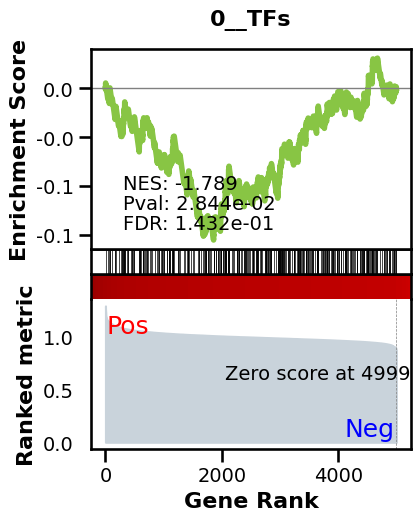

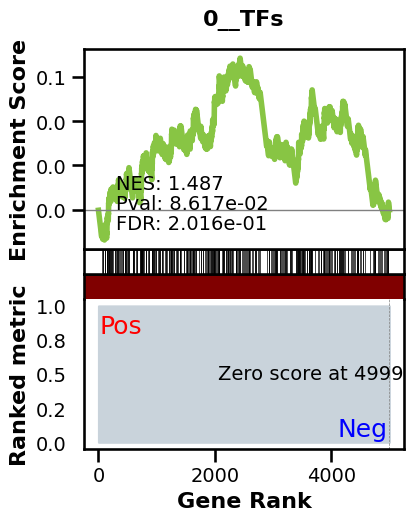

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3522 genes
intersection pct: 0.7044
precision:  0.0007680287225167932 
recall:  1.0 
random precision: 0.0007682468505265962



  0%|          | 0/128 [00:00<?, ?it/s]


  5%|▍         | 6/128 [00:00<00:02, 59.48it/s]


  9%|▉         | 12/128 [00:00<00:01, 59.44it/s]


 14%|█▍        | 18/128 [00:00<00:01, 59.55it/s]


 19%|█▉        | 24/128 [00:00<00:01, 59.18it/s]


 23%|██▎       | 30/128 [00:00<00:01, 59.04it/s]


 28%|██▊       | 36/128 [00:00<00:01, 58.96it/s]


 33%|███▎      | 42/128 [00:00<00:01, 59.16it/s]


 38%|███▊      | 48/128 [00:00<00:01, 59.34it/s]


 42%|████▏     | 54/128 [00:00<00:01, 59.10it/s]


 47%|████▋     | 60/128 [00:01<00:01, 58.58it/s]


 52%|█████▏    | 66/128 [00:01<00:01, 58.71it/s]


 56%|█████▋    | 72/128 [00:01<00:00, 58.85it/s]


 61%|██████    | 78/128 [00:01<00:00, 58.50it/s]


 66%|██████▌   | 84/128 [00:01<00:00, 58.63it/s]


 70%|███████   | 90/128 [00:01<00:00, 57.85it/s]


 75%|███████▌  | 96/128 [00:01<00:00, 58.35it/s]


 80%|███████▉  | 102/128 [00:01<00:00, 58.45it/s]


 84%|████████▍ | 108/128 [00:01<00:00, 58.70it/s]


 89%|████████▉ | 114/128 [00:01<00:00, 58.62it/s]


 94%|█████████▍| 120/128 [00:02<00:00, 58.52it/s]


 98%|█████████▊| 126/128 [00:02<00:00, 58.50it/s]


100%|██████████| 128/128 [00:02<00:00, 58.71it/s]

Average Precision (AP):  0.0008254871297179183
Area Under Precision-Recall Curve (AUPRC):  0.000825122183937951
EPR: 1.9154953675954216


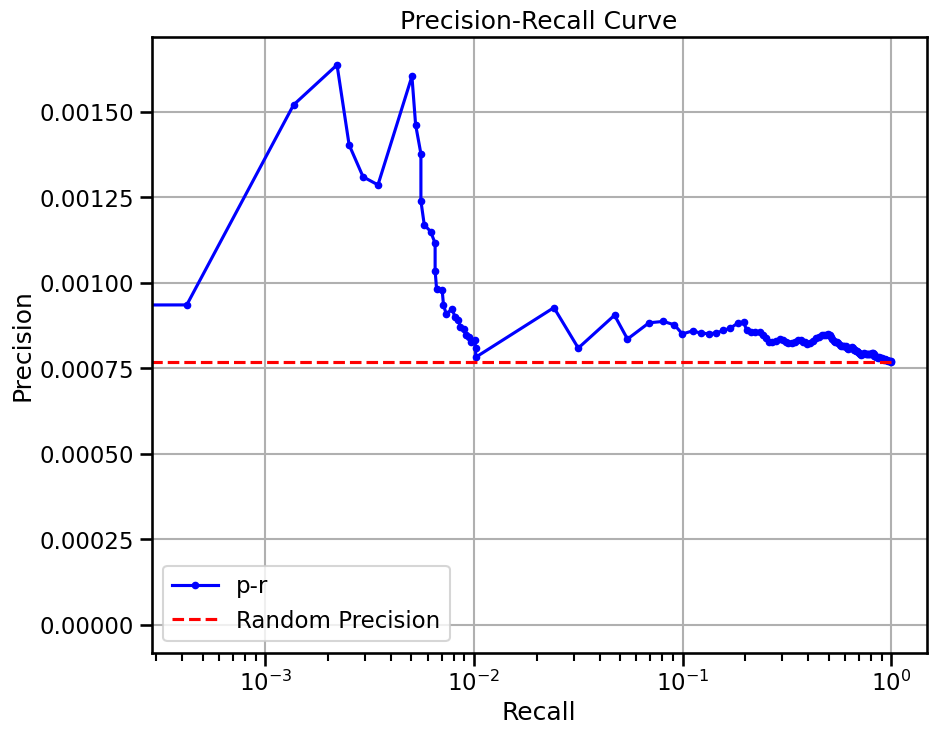

base enrichment


Top central genes: []


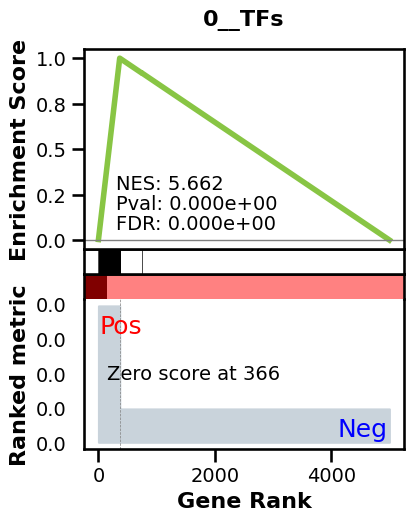

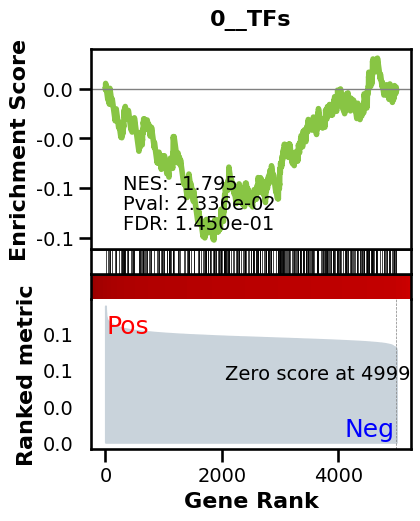

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3522 genes
intersection pct: 0.7044
precision:  0.002834563694870339 
recall:  0.31436968615513805 
random precision: 0.0007682468505265962



  0%|          | 0/128 [00:00<?, ?it/s]


  5%|▍         | 6/128 [00:00<00:02, 58.44it/s]


  9%|▉         | 12/128 [00:00<00:01, 58.60it/s]


 14%|█▍        | 18/128 [00:00<00:01, 58.25it/s]


 19%|█▉        | 24/128 [00:00<00:01, 57.88it/s]


 23%|██▎       | 30/128 [00:00<00:01, 57.86it/s]


 28%|██▊       | 36/128 [00:00<00:01, 57.85it/s]


 33%|███▎      | 42/128 [00:00<00:01, 57.77it/s]


 38%|███▊      | 48/128 [00:00<00:01, 57.62it/s]


 42%|████▏     | 54/128 [00:00<00:01, 57.79it/s]


 47%|████▋     | 60/128 [00:01<00:01, 57.99it/s]


 52%|█████▏    | 66/128 [00:01<00:01, 57.83it/s]


 56%|█████▋    | 72/128 [00:01<00:00, 57.94it/s]


 61%|██████    | 78/128 [00:01<00:00, 57.79it/s]


 66%|██████▌   | 84/128 [00:01<00:00, 57.79it/s]


 70%|███████   | 90/128 [00:01<00:00, 57.75it/s]


 75%|███████▌  | 96/128 [00:01<00:00, 57.96it/s]


 80%|███████▉  | 102/128 [00:01<00:00, 57.75it/s]


 84%|████████▍ | 108/128 [00:01<00:00, 58.04it/s]


 89%|████████▉ | 114/128 [00:01<00:00, 58.00it/s]


 94%|█████████▍| 120/128 [00:02<00:00, 57.83it/s]


 98%|█████████▊| 126/128 [00:02<00:00, 57.57it/s]


100%|██████████| 128/128 [00:02<00:00, 57.85it/s]

Average Precision (AP):  0.001711703437521717
Area Under Precision-Recall Curve (AUPRC):  0.0014717817144594561
EPR: 4.671546978863012


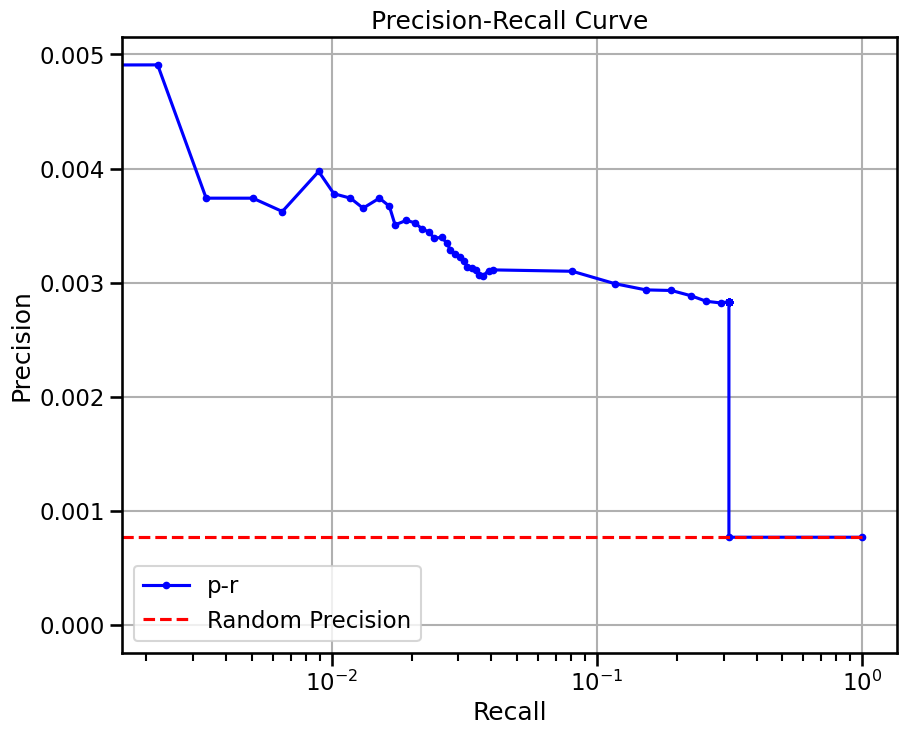


  0%|          | 0/205 [00:00<?, ?it/s]


  0%|          | 1/205 [00:00<02:17,  1.49it/s]


  1%|          | 2/205 [00:01<02:18,  1.46it/s]


  1%|▏         | 3/205 [00:02<02:17,  1.47it/s]


  2%|▏         | 4/205 [00:02<02:16,  1.47it/s]


  2%|▏         | 5/205 [00:03<02:15,  1.47it/s]


  3%|▎         | 6/205 [00:04<02:14,  1.47it/s]


  3%|▎         | 7/205 [00:04<02:14,  1.48it/s]


  4%|▍         | 8/205 [00:05<02:13,  1.48it/s]


  4%|▍         | 9/205 [00:06<02:12,  1.48it/s]


  5%|▍         | 10/205 [00:06<02:12,  1.48it/s]


  5%|▌         | 11/205 [00:07<02:11,  1.48it/s]


  6%|▌         | 12/205 [00:08<02:10,  1.47it/s]


  6%|▋         | 13/205 [00:08<02:10,  1.47it/s]


  7%|▋         | 14/205 [00:09<02:09,  1.47it/s]


  7%|▋         | 15/205 [00:10<02:09,  1.47it/s]


  8%|▊         | 16/205 [00:10<02:08,  1.47it/s]


  8%|▊         | 17/205 [00:11<02:07,  1.47it/s]


  9%|▉         | 18/205 [00:12<02:07,  1.47it/s]


  9%|▉         | 19/205 [00:12<02:06,  1.47it/s]


 10%|▉         | 20/205 [00:13<02:05,  1.47it/s]


 10%|█         | 21/205 [00:14<02:05,  1.47it/s]


 11%|█         | 22/205 [00:14<02:04,  1.47it/s]


 11%|█         | 23/205 [00:15<02:03,  1.47it/s]


 12%|█▏        | 24/205 [00:16<02:03,  1.47it/s]


 12%|█▏        | 25/205 [00:16<02:02,  1.47it/s]


 13%|█▎        | 26/205 [00:17<02:01,  1.47it/s]


 13%|█▎        | 27/205 [00:18<02:01,  1.47it/s]


 14%|█▎        | 28/205 [00:19<02:00,  1.47it/s]


 14%|█▍        | 29/205 [00:19<01:59,  1.47it/s]


 15%|█▍        | 30/205 [00:20<01:59,  1.47it/s]


 15%|█▌        | 31/205 [00:21<01:58,  1.47it/s]


 16%|█▌        | 32/205 [00:21<01:57,  1.47it/s]


 16%|█▌        | 33/205 [00:22<01:57,  1.47it/s]


 17%|█▋        | 34/205 [00:23<01:56,  1.47it/s]


 17%|█▋        | 35/205 [00:23<01:55,  1.47it/s]


 18%|█▊        | 36/205 [00:24<01:55,  1.47it/s]


 18%|█▊        | 37/205 [00:25<01:54,  1.47it/s]


 19%|█▊        | 38/205 [00:25<01:53,  1.47it/s]


 19%|█▉        | 39/205 [00:26<01:53,  1.47it/s]


 20%|█▉        | 40/205 [00:27<01:52,  1.47it/s]


 20%|██        | 41/205 [00:27<01:51,  1.46it/s]


 20%|██        | 42/205 [00:28<01:51,  1.46it/s]


 21%|██        | 43/205 [00:29<01:50,  1.46it/s]


 21%|██▏       | 44/205 [00:29<01:50,  1.46it/s]


 22%|██▏       | 45/205 [00:30<01:49,  1.46it/s]


 22%|██▏       | 46/205 [00:31<01:48,  1.46it/s]


 23%|██▎       | 47/205 [00:32<01:48,  1.46it/s]


 23%|██▎       | 48/205 [00:32<01:47,  1.46it/s]


 24%|██▍       | 49/205 [00:33<01:46,  1.46it/s]


 24%|██▍       | 50/205 [00:34<01:46,  1.46it/s]


 25%|██▍       | 51/205 [00:34<01:45,  1.46it/s]


 25%|██▌       | 52/205 [00:35<01:44,  1.46it/s]


 26%|██▌       | 53/205 [00:36<01:43,  1.46it/s]


 26%|██▋       | 54/205 [00:36<01:43,  1.46it/s]


 27%|██▋       | 55/205 [00:37<01:42,  1.46it/s]


 27%|██▋       | 56/205 [00:38<01:42,  1.46it/s]


 28%|██▊       | 57/205 [00:38<01:41,  1.46it/s]


 28%|██▊       | 58/205 [00:39<01:40,  1.46it/s]


 29%|██▉       | 59/205 [00:40<01:39,  1.46it/s]


 29%|██▉       | 60/205 [00:40<01:39,  1.46it/s]


 30%|██▉       | 61/205 [00:41<01:38,  1.46it/s]


 30%|███       | 62/205 [00:42<01:38,  1.46it/s]


 31%|███       | 63/205 [00:42<01:37,  1.46it/s]


 31%|███       | 64/205 [00:43<01:36,  1.46it/s]


 32%|███▏      | 65/205 [00:44<01:36,  1.46it/s]


 32%|███▏      | 66/205 [00:45<01:35,  1.46it/s]


 33%|███▎      | 67/205 [00:45<01:34,  1.46it/s]


 33%|███▎      | 68/205 [00:46<01:33,  1.46it/s]


 34%|███▎      | 69/205 [00:47<01:33,  1.46it/s]


 34%|███▍      | 70/205 [00:47<01:32,  1.46it/s]


 35%|███▍      | 71/205 [00:48<01:32,  1.46it/s]


 35%|███▌      | 72/205 [00:49<01:31,  1.46it/s]


 36%|███▌      | 73/205 [00:49<01:30,  1.46it/s]


 36%|███▌      | 74/205 [00:50<01:29,  1.46it/s]


 37%|███▋      | 75/205 [00:51<01:29,  1.46it/s]


 37%|███▋      | 76/205 [00:51<01:28,  1.46it/s]


 38%|███▊      | 77/205 [00:52<01:27,  1.46it/s]


 38%|███▊      | 78/205 [00:53<01:27,  1.46it/s]


 39%|███▊      | 79/205 [00:53<01:26,  1.46it/s]


 39%|███▉      | 80/205 [00:54<01:25,  1.45it/s]


 40%|███▉      | 81/205 [00:55<01:25,  1.46it/s]


 40%|████      | 82/205 [00:56<01:24,  1.46it/s]


 40%|████      | 83/205 [00:56<01:23,  1.46it/s]


 41%|████      | 84/205 [00:57<01:23,  1.46it/s]


 41%|████▏     | 85/205 [00:58<01:22,  1.46it/s]


 42%|████▏     | 86/205 [00:58<01:22,  1.45it/s]


 42%|████▏     | 87/205 [00:59<01:21,  1.45it/s]


 43%|████▎     | 88/205 [01:00<01:20,  1.45it/s]


 43%|████▎     | 89/205 [01:00<01:19,  1.45it/s]


 44%|████▍     | 90/205 [01:01<01:19,  1.45it/s]


 44%|████▍     | 91/205 [01:02<01:18,  1.45it/s]


 45%|████▍     | 92/205 [01:02<01:17,  1.45it/s]


 45%|████▌     | 93/205 [01:03<01:16,  1.45it/s]


 46%|████▌     | 94/205 [01:04<01:16,  1.45it/s]


 46%|████▋     | 95/205 [01:04<01:15,  1.45it/s]


 47%|████▋     | 96/205 [01:05<01:14,  1.46it/s]


 47%|████▋     | 97/205 [01:06<01:14,  1.46it/s]


 48%|████▊     | 98/205 [01:07<01:13,  1.46it/s]


 48%|████▊     | 99/205 [01:07<01:12,  1.46it/s]


 49%|████▉     | 100/205 [01:08<01:12,  1.45it/s]


 49%|████▉     | 101/205 [01:09<01:11,  1.45it/s]


 50%|████▉     | 102/205 [01:09<01:10,  1.45it/s]


 50%|█████     | 103/205 [01:10<01:10,  1.45it/s]


 51%|█████     | 104/205 [01:11<01:09,  1.45it/s]


 51%|█████     | 105/205 [01:11<01:08,  1.45it/s]


 52%|█████▏    | 106/205 [01:12<01:08,  1.45it/s]


 52%|█████▏    | 107/205 [01:13<01:07,  1.45it/s]


 53%|█████▎    | 108/205 [01:13<01:06,  1.45it/s]


 53%|█████▎    | 109/205 [01:14<01:06,  1.45it/s]


 54%|█████▎    | 110/205 [01:15<01:05,  1.45it/s]


 54%|█████▍    | 111/205 [01:15<01:04,  1.45it/s]


 55%|█████▍    | 112/205 [01:16<01:03,  1.45it/s]


 55%|█████▌    | 113/205 [01:17<01:03,  1.45it/s]


 56%|█████▌    | 114/205 [01:18<01:02,  1.45it/s]


 56%|█████▌    | 115/205 [01:18<01:01,  1.45it/s]


 57%|█████▋    | 116/205 [01:19<01:01,  1.45it/s]


 57%|█████▋    | 117/205 [01:20<01:00,  1.45it/s]


 58%|█████▊    | 118/205 [01:20<00:59,  1.45it/s]


 58%|█████▊    | 119/205 [01:21<00:59,  1.45it/s]


 59%|█████▊    | 120/205 [01:22<00:58,  1.45it/s]


 59%|█████▉    | 121/205 [01:22<00:57,  1.45it/s]


 60%|█████▉    | 122/205 [01:23<00:57,  1.45it/s]


 60%|██████    | 123/205 [01:24<00:56,  1.45it/s]


 60%|██████    | 124/205 [01:24<00:55,  1.45it/s]


 61%|██████    | 125/205 [01:25<00:55,  1.45it/s]


 61%|██████▏   | 126/205 [01:26<00:54,  1.45it/s]


 62%|██████▏   | 127/205 [01:26<00:53,  1.45it/s]


 62%|██████▏   | 128/205 [01:27<00:52,  1.45it/s]


 63%|██████▎   | 129/205 [01:28<00:52,  1.45it/s]


 63%|██████▎   | 130/205 [01:29<00:51,  1.45it/s]


 64%|██████▍   | 131/205 [01:29<00:50,  1.45it/s]


 64%|██████▍   | 132/205 [01:30<00:50,  1.45it/s]


 65%|██████▍   | 133/205 [01:31<00:49,  1.45it/s]


 65%|██████▌   | 134/205 [01:31<00:48,  1.45it/s]


 66%|██████▌   | 135/205 [01:32<00:48,  1.45it/s]


 66%|██████▋   | 136/205 [01:33<00:47,  1.45it/s]


 67%|██████▋   | 137/205 [01:33<00:46,  1.45it/s]


 67%|██████▋   | 138/205 [01:34<00:46,  1.45it/s]


 68%|██████▊   | 139/205 [01:35<00:45,  1.45it/s]


 68%|██████▊   | 140/205 [01:35<00:44,  1.45it/s]


 69%|██████▉   | 141/205 [01:36<00:44,  1.45it/s]


 69%|██████▉   | 142/205 [01:37<00:43,  1.45it/s]


 70%|██████▉   | 143/205 [01:37<00:42,  1.45it/s]


 70%|███████   | 144/205 [01:38<00:41,  1.45it/s]


 71%|███████   | 145/205 [01:39<00:41,  1.45it/s]


 71%|███████   | 146/205 [01:40<00:40,  1.45it/s]


 72%|███████▏  | 147/205 [01:40<00:39,  1.45it/s]


 72%|███████▏  | 148/205 [01:41<00:39,  1.45it/s]


 73%|███████▎  | 149/205 [01:42<00:38,  1.45it/s]


 73%|███████▎  | 150/205 [01:42<00:37,  1.45it/s]


 74%|███████▎  | 151/205 [01:43<00:37,  1.45it/s]


 74%|███████▍  | 152/205 [01:44<00:36,  1.45it/s]


 75%|███████▍  | 153/205 [01:44<00:35,  1.45it/s]


 75%|███████▌  | 154/205 [01:45<00:35,  1.45it/s]


 76%|███████▌  | 155/205 [01:46<00:34,  1.45it/s]


 76%|███████▌  | 156/205 [01:46<00:33,  1.45it/s]


 77%|███████▋  | 157/205 [01:47<00:33,  1.45it/s]


 77%|███████▋  | 158/205 [01:48<00:32,  1.45it/s]


 78%|███████▊  | 159/205 [01:48<00:31,  1.45it/s]


 78%|███████▊  | 160/205 [01:49<00:30,  1.45it/s]


 79%|███████▊  | 161/205 [01:50<00:30,  1.45it/s]


 79%|███████▉  | 162/205 [01:51<00:29,  1.45it/s]


 80%|███████▉  | 163/205 [01:51<00:28,  1.45it/s]


 80%|████████  | 164/205 [01:52<00:28,  1.45it/s]


 80%|████████  | 165/205 [01:53<00:27,  1.45it/s]


 81%|████████  | 166/205 [01:53<00:26,  1.45it/s]


 81%|████████▏ | 167/205 [01:54<00:26,  1.45it/s]


 82%|████████▏ | 168/205 [01:55<00:25,  1.45it/s]


 82%|████████▏ | 169/205 [01:55<00:24,  1.45it/s]


 83%|████████▎ | 170/205 [01:56<00:24,  1.45it/s]


 83%|████████▎ | 171/205 [01:57<00:23,  1.45it/s]


 84%|████████▍ | 172/205 [01:57<00:22,  1.45it/s]


 84%|████████▍ | 173/205 [01:58<00:22,  1.45it/s]


 85%|████████▍ | 174/205 [01:59<00:21,  1.45it/s]


 85%|████████▌ | 175/205 [01:59<00:20,  1.45it/s]


 86%|████████▌ | 176/205 [02:00<00:19,  1.45it/s]


 86%|████████▋ | 177/205 [02:01<00:19,  1.45it/s]


 87%|████████▋ | 178/205 [02:02<00:18,  1.45it/s]


 87%|████████▋ | 179/205 [02:02<00:17,  1.45it/s]


 88%|████████▊ | 180/205 [02:03<00:17,  1.45it/s]


 88%|████████▊ | 181/205 [02:04<00:16,  1.45it/s]


 89%|████████▉ | 182/205 [02:04<00:15,  1.45it/s]


 89%|████████▉ | 183/205 [02:05<00:15,  1.45it/s]


 90%|████████▉ | 184/205 [02:06<00:14,  1.45it/s]


 90%|█████████ | 185/205 [02:06<00:13,  1.45it/s]


 91%|█████████ | 186/205 [02:07<00:13,  1.45it/s]


 91%|█████████ | 187/205 [02:08<00:12,  1.45it/s]


 92%|█████████▏| 188/205 [02:08<00:11,  1.45it/s]


 92%|█████████▏| 189/205 [02:09<00:11,  1.45it/s]


 93%|█████████▎| 190/205 [02:10<00:10,  1.45it/s]


 93%|█████████▎| 191/205 [02:11<00:09,  1.45it/s]


 94%|█████████▎| 192/205 [02:11<00:08,  1.45it/s]


 94%|█████████▍| 193/205 [02:12<00:08,  1.45it/s]


 95%|█████████▍| 194/205 [02:13<00:07,  1.45it/s]


 95%|█████████▌| 195/205 [02:13<00:06,  1.45it/s]


 96%|█████████▌| 196/205 [02:14<00:06,  1.45it/s]


 96%|█████████▌| 197/205 [02:15<00:05,  1.45it/s]


 97%|█████████▋| 198/205 [02:15<00:04,  1.45it/s]


 97%|█████████▋| 199/205 [02:16<00:04,  1.45it/s]


 98%|█████████▊| 200/205 [02:17<00:03,  1.45it/s]


 98%|█████████▊| 201/205 [02:17<00:02,  1.45it/s]


 99%|█████████▊| 202/205 [02:18<00:02,  1.45it/s]


 99%|█████████▉| 203/205 [02:19<00:01,  1.45it/s]


100%|█████████▉| 204/205 [02:19<00:00,  1.45it/s]


100%|██████████| 205/205 [02:20<00:00,  1.55it/s]


100%|██████████| 205/205 [02:20<00:00,  1.46it/s]

base enrichment


Top central genes: []
The DataFrame contains only the same values.


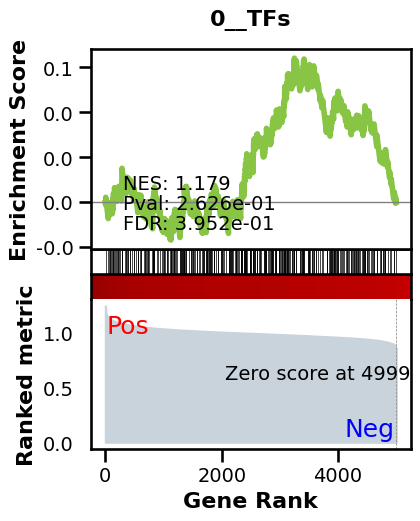

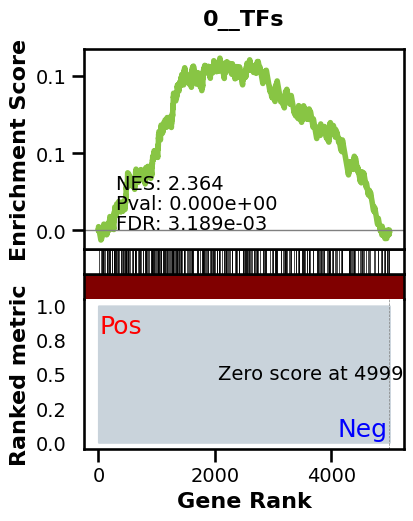

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3550 genes
intersection pct: 0.71
precision:  0.0010244792699861138 
recall:  1.0 
random precision: 0.0010247679370106238



  0%|          | 0/128 [00:00<?, ?it/s]


  5%|▍         | 6/128 [00:00<00:02, 56.19it/s]


  9%|▉         | 12/128 [00:00<00:02, 55.52it/s]


 14%|█▍        | 18/128 [00:00<00:01, 55.41it/s]


 19%|█▉        | 24/128 [00:00<00:01, 55.20it/s]


 23%|██▎       | 30/128 [00:00<00:01, 54.82it/s]


 28%|██▊       | 36/128 [00:00<00:01, 54.89it/s]


 33%|███▎      | 42/128 [00:00<00:01, 54.93it/s]


 38%|███▊      | 48/128 [00:00<00:01, 55.11it/s]


 42%|████▏     | 54/128 [00:00<00:01, 55.21it/s]


 47%|████▋     | 60/128 [00:01<00:01, 54.68it/s]


 52%|█████▏    | 66/128 [00:01<00:01, 54.70it/s]


 56%|█████▋    | 72/128 [00:01<00:01, 55.17it/s]


 61%|██████    | 78/128 [00:01<00:00, 55.31it/s]


 66%|██████▌   | 84/128 [00:01<00:00, 54.86it/s]


 70%|███████   | 90/128 [00:01<00:00, 54.83it/s]


 75%|███████▌  | 96/128 [00:01<00:00, 55.14it/s]


 80%|███████▉  | 102/128 [00:01<00:00, 55.16it/s]


 84%|████████▍ | 108/128 [00:01<00:00, 55.46it/s]


 89%|████████▉ | 114/128 [00:02<00:00, 55.54it/s]


 94%|█████████▍| 120/128 [00:02<00:00, 55.34it/s]


 98%|█████████▊| 126/128 [00:02<00:00, 55.15it/s]


100%|██████████| 128/128 [00:02<00:00, 55.13it/s]

Average Precision (AP):  0.001152606155328705
Area Under Precision-Recall Curve (AUPRC):  0.0011516831794382495
EPR: 0.5285583157555493


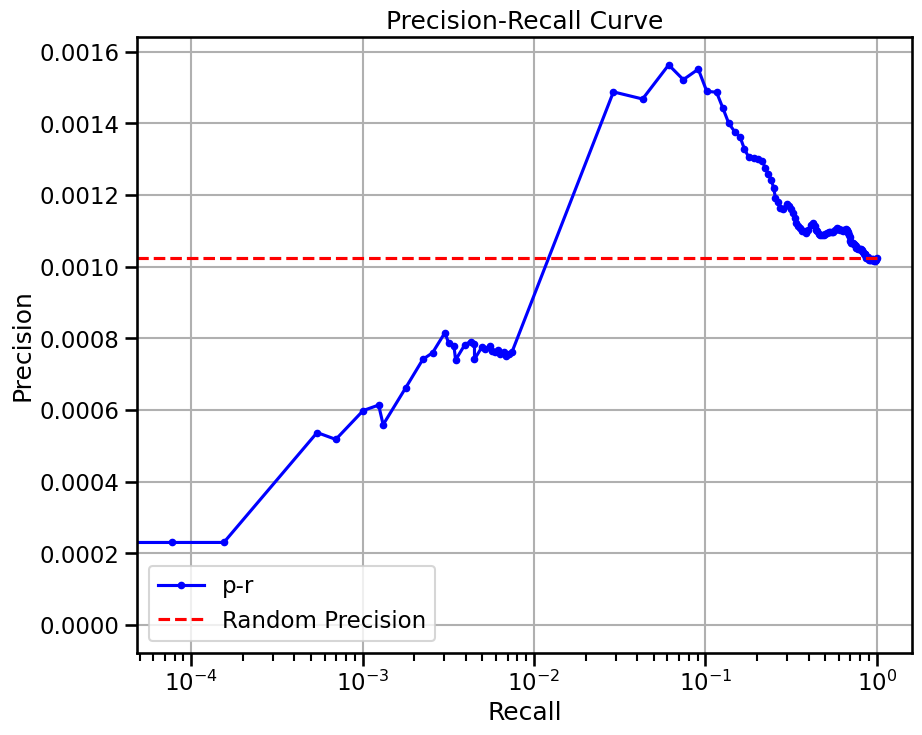

base enrichment


Top central genes: []


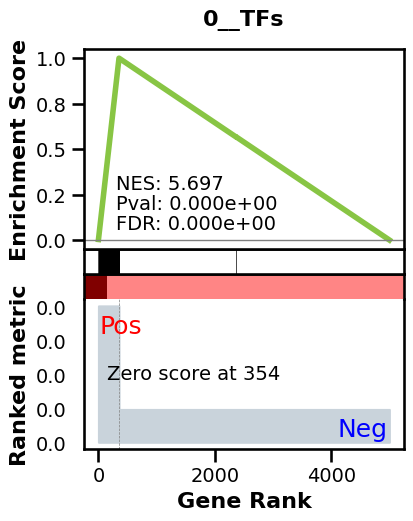

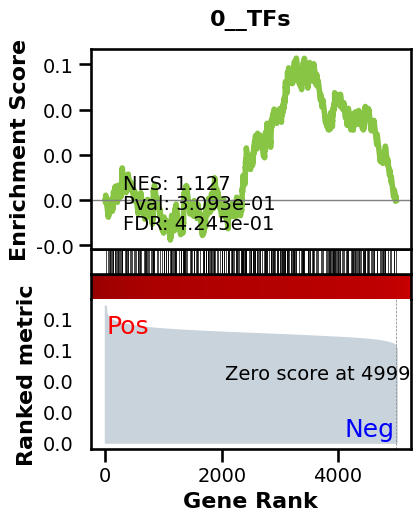

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3550 genes
intersection pct: 0.71
precision:  0.003774647887323944 
recall:  0.3165517775540237 
random precision: 0.0010247679370106238



  0%|          | 0/128 [00:00<?, ?it/s]


  5%|▍         | 6/128 [00:00<00:02, 55.36it/s]


  9%|▉         | 12/128 [00:00<00:02, 54.96it/s]


 14%|█▍        | 18/128 [00:00<00:01, 55.02it/s]


 19%|█▉        | 24/128 [00:00<00:01, 55.39it/s]


 23%|██▎       | 30/128 [00:00<00:01, 55.50it/s]


 28%|██▊       | 36/128 [00:00<00:01, 55.37it/s]


 33%|███▎      | 42/128 [00:00<00:01, 54.77it/s]


 38%|███▊      | 48/128 [00:00<00:01, 55.12it/s]


 42%|████▏     | 54/128 [00:00<00:01, 55.37it/s]


 47%|████▋     | 60/128 [00:01<00:01, 55.44it/s]


 52%|█████▏    | 66/128 [00:01<00:01, 54.88it/s]


 56%|█████▋    | 72/128 [00:01<00:01, 55.04it/s]


 61%|██████    | 78/128 [00:01<00:00, 55.10it/s]


 66%|██████▌   | 84/128 [00:01<00:00, 55.10it/s]


 70%|███████   | 90/128 [00:01<00:00, 55.20it/s]


 75%|███████▌  | 96/128 [00:01<00:00, 55.20it/s]


 80%|███████▉  | 102/128 [00:01<00:00, 55.53it/s]


 84%|████████▍ | 108/128 [00:01<00:00, 55.54it/s]


 89%|████████▉ | 114/128 [00:02<00:00, 55.64it/s]


 94%|█████████▍| 120/128 [00:02<00:00, 55.70it/s]


 98%|█████████▊| 126/128 [00:02<00:00, 56.01it/s]


100%|██████████| 128/128 [00:02<00:00, 55.37it/s]

Average Precision (AP):  0.002313963705003292
Area Under Precision-Recall Curve (AUPRC):  0.0020114985673581297
EPR: 4.1840435728353205


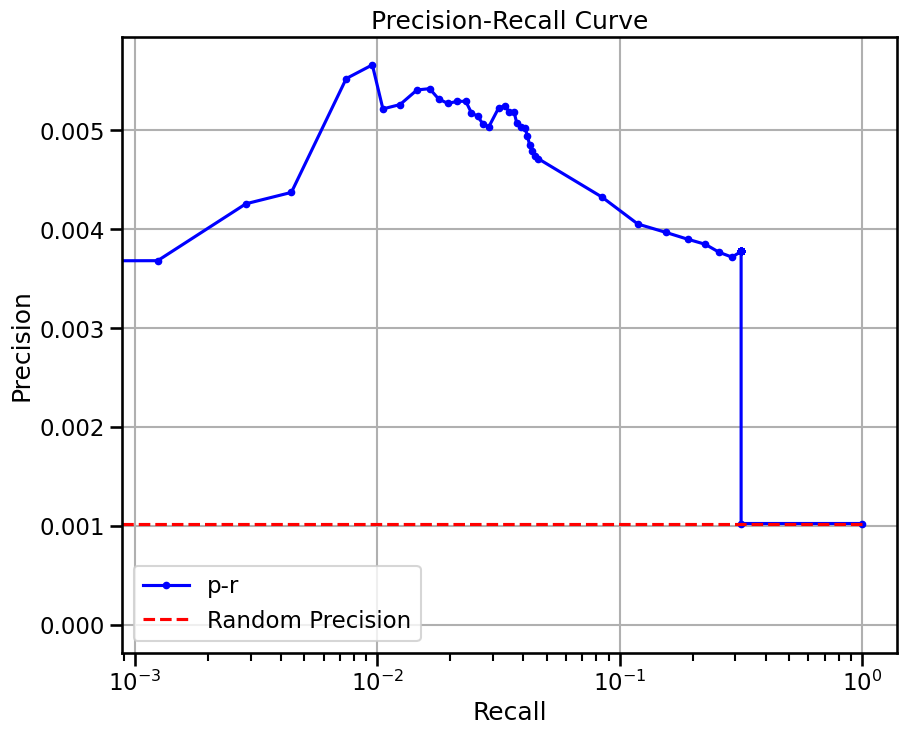


  0%|          | 0/99 [00:00<?, ?it/s]


  1%|          | 1/99 [00:00<01:04,  1.51it/s]


  2%|▏         | 2/99 [00:01<01:05,  1.49it/s]


  3%|▎         | 3/99 [00:02<01:04,  1.49it/s]


  4%|▍         | 4/99 [00:02<01:03,  1.50it/s]


  5%|▌         | 5/99 [00:03<01:02,  1.50it/s]


  6%|▌         | 6/99 [00:04<01:02,  1.50it/s]


  7%|▋         | 7/99 [00:04<01:01,  1.50it/s]


  8%|▊         | 8/99 [00:05<01:00,  1.50it/s]


  9%|▉         | 9/99 [00:06<01:00,  1.50it/s]


 10%|█         | 10/99 [00:06<00:59,  1.50it/s]


 11%|█         | 11/99 [00:07<00:58,  1.50it/s]


 12%|█▏        | 12/99 [00:08<00:58,  1.50it/s]


 13%|█▎        | 13/99 [00:08<00:57,  1.50it/s]


 14%|█▍        | 14/99 [00:09<00:56,  1.50it/s]


 15%|█▌        | 15/99 [00:10<00:56,  1.50it/s]


 16%|█▌        | 16/99 [00:10<00:55,  1.50it/s]


 17%|█▋        | 17/99 [00:11<00:55,  1.48it/s]


 18%|█▊        | 18/99 [00:12<00:54,  1.49it/s]


 19%|█▉        | 19/99 [00:12<00:53,  1.49it/s]


 20%|██        | 20/99 [00:13<00:53,  1.49it/s]


 21%|██        | 21/99 [00:14<00:52,  1.49it/s]


 22%|██▏       | 22/99 [00:14<00:51,  1.48it/s]


 23%|██▎       | 23/99 [00:15<00:51,  1.49it/s]


 24%|██▍       | 24/99 [00:16<00:50,  1.49it/s]


 25%|██▌       | 25/99 [00:16<00:49,  1.49it/s]


 26%|██▋       | 26/99 [00:17<00:49,  1.49it/s]


 27%|██▋       | 27/99 [00:18<00:48,  1.49it/s]


 28%|██▊       | 28/99 [00:18<00:47,  1.49it/s]


 29%|██▉       | 29/99 [00:19<00:46,  1.49it/s]


 30%|███       | 30/99 [00:20<00:46,  1.49it/s]


 31%|███▏      | 31/99 [00:20<00:45,  1.49it/s]


 32%|███▏      | 32/99 [00:21<00:45,  1.49it/s]


 33%|███▎      | 33/99 [00:22<00:44,  1.49it/s]


 34%|███▍      | 34/99 [00:22<00:43,  1.49it/s]


 35%|███▌      | 35/99 [00:23<00:43,  1.49it/s]


 36%|███▋      | 36/99 [00:24<00:42,  1.49it/s]


 37%|███▋      | 37/99 [00:24<00:41,  1.49it/s]


 38%|███▊      | 38/99 [00:25<00:41,  1.49it/s]


 39%|███▉      | 39/99 [00:26<00:40,  1.49it/s]


 40%|████      | 40/99 [00:26<00:39,  1.49it/s]


 41%|████▏     | 41/99 [00:27<00:39,  1.49it/s]


 42%|████▏     | 42/99 [00:28<00:38,  1.49it/s]


 43%|████▎     | 43/99 [00:28<00:37,  1.49it/s]


 44%|████▍     | 44/99 [00:29<00:37,  1.49it/s]


 45%|████▌     | 45/99 [00:30<00:36,  1.48it/s]


 46%|████▋     | 46/99 [00:30<00:35,  1.48it/s]


 47%|████▋     | 47/99 [00:31<00:35,  1.48it/s]


 48%|████▊     | 48/99 [00:32<00:34,  1.48it/s]


 49%|████▉     | 49/99 [00:32<00:33,  1.48it/s]


 51%|█████     | 50/99 [00:33<00:33,  1.48it/s]


 52%|█████▏    | 51/99 [00:34<00:32,  1.48it/s]


 53%|█████▎    | 52/99 [00:34<00:31,  1.48it/s]


 54%|█████▎    | 53/99 [00:35<00:31,  1.48it/s]


 55%|█████▍    | 54/99 [00:36<00:30,  1.48it/s]


 56%|█████▌    | 55/99 [00:36<00:29,  1.48it/s]


 57%|█████▋    | 56/99 [00:37<00:29,  1.48it/s]


 58%|█████▊    | 57/99 [00:38<00:28,  1.48it/s]


 59%|█████▊    | 58/99 [00:38<00:27,  1.48it/s]


 60%|█████▉    | 59/99 [00:39<00:26,  1.48it/s]


 61%|██████    | 60/99 [00:40<00:26,  1.48it/s]


 62%|██████▏   | 61/99 [00:40<00:25,  1.48it/s]


 63%|██████▎   | 62/99 [00:41<00:24,  1.48it/s]


 64%|██████▎   | 63/99 [00:42<00:24,  1.48it/s]


 65%|██████▍   | 64/99 [00:43<00:23,  1.48it/s]


 66%|██████▌   | 65/99 [00:43<00:22,  1.48it/s]


 67%|██████▋   | 66/99 [00:44<00:22,  1.48it/s]


 68%|██████▊   | 67/99 [00:45<00:21,  1.48it/s]


 69%|██████▊   | 68/99 [00:45<00:20,  1.48it/s]


 70%|██████▉   | 69/99 [00:46<00:20,  1.48it/s]


 71%|███████   | 70/99 [00:47<00:19,  1.48it/s]


 72%|███████▏  | 71/99 [00:47<00:18,  1.48it/s]


 73%|███████▎  | 72/99 [00:48<00:18,  1.48it/s]


 74%|███████▎  | 73/99 [00:49<00:17,  1.48it/s]


 75%|███████▍  | 74/99 [00:49<00:16,  1.48it/s]


 76%|███████▌  | 75/99 [00:50<00:16,  1.48it/s]


 77%|███████▋  | 76/99 [00:51<00:15,  1.48it/s]


 78%|███████▊  | 77/99 [00:51<00:14,  1.48it/s]


 79%|███████▉  | 78/99 [00:52<00:14,  1.48it/s]


 80%|███████▉  | 79/99 [00:53<00:13,  1.48it/s]


 81%|████████  | 80/99 [00:53<00:12,  1.48it/s]


 82%|████████▏ | 81/99 [00:54<00:12,  1.48it/s]


 83%|████████▎ | 82/99 [00:55<00:11,  1.48it/s]


 84%|████████▍ | 83/99 [00:55<00:10,  1.48it/s]


 85%|████████▍ | 84/99 [00:56<00:10,  1.48it/s]


 86%|████████▌ | 85/99 [00:57<00:09,  1.48it/s]


 87%|████████▋ | 86/99 [00:57<00:08,  1.48it/s]


 88%|████████▊ | 87/99 [00:58<00:08,  1.48it/s]


 89%|████████▉ | 88/99 [00:59<00:07,  1.48it/s]


 90%|████████▉ | 89/99 [00:59<00:06,  1.48it/s]


 91%|█████████ | 90/99 [01:00<00:06,  1.48it/s]


 92%|█████████▏| 91/99 [01:01<00:05,  1.48it/s]


 93%|█████████▎| 92/99 [01:01<00:04,  1.48it/s]


 94%|█████████▍| 93/99 [01:02<00:04,  1.48it/s]


 95%|█████████▍| 94/99 [01:03<00:03,  1.48it/s]


 96%|█████████▌| 95/99 [01:04<00:02,  1.48it/s]


 97%|█████████▋| 96/99 [01:04<00:02,  1.48it/s]


 98%|█████████▊| 97/99 [01:05<00:01,  1.48it/s]


 99%|█████████▉| 98/99 [01:06<00:00,  1.47it/s]


100%|██████████| 99/99 [01:06<00:00,  1.68it/s]


100%|██████████| 99/99 [01:06<00:00,  1.49it/s]

base enrichment


Top central genes: []
The DataFrame contains only the same values.


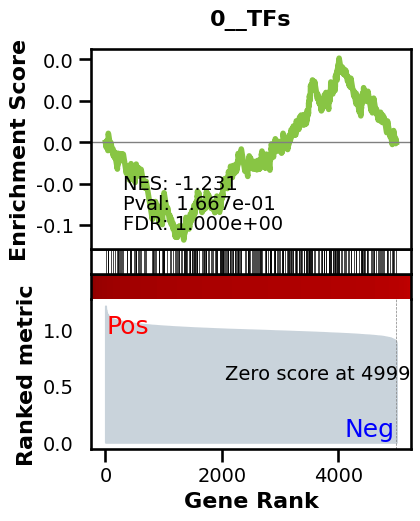

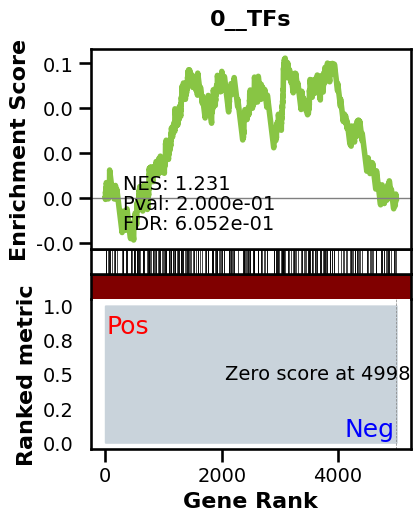

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3676 genes
intersection pct: 0.7352
precision:  0.000953231915752681 
recall:  1.0 
random precision: 0.0009534912985868993



  0%|          | 0/128 [00:00<?, ?it/s]


  5%|▍         | 6/128 [00:00<00:02, 51.43it/s]


  9%|▉         | 12/128 [00:00<00:02, 50.59it/s]


 14%|█▍        | 18/128 [00:00<00:02, 50.20it/s]


 19%|█▉        | 24/128 [00:00<00:02, 49.96it/s]


 23%|██▎       | 30/128 [00:00<00:01, 50.18it/s]


 28%|██▊       | 36/128 [00:00<00:01, 49.91it/s]


 33%|███▎      | 42/128 [00:00<00:01, 50.21it/s]


 38%|███▊      | 48/128 [00:00<00:01, 50.13it/s]


 42%|████▏     | 54/128 [00:01<00:01, 50.21it/s]


 47%|████▋     | 60/128 [00:01<00:01, 50.15it/s]


 52%|█████▏    | 66/128 [00:01<00:01, 49.95it/s]


 55%|█████▌    | 71/128 [00:01<00:01, 49.54it/s]


 60%|██████    | 77/128 [00:01<00:01, 49.69it/s]


 64%|██████▍   | 82/128 [00:01<00:00, 49.41it/s]


 68%|██████▊   | 87/128 [00:01<00:00, 49.43it/s]


 72%|███████▏  | 92/128 [00:01<00:00, 49.35it/s]


 76%|███████▌  | 97/128 [00:01<00:00, 49.49it/s]


 80%|███████▉  | 102/128 [00:02<00:00, 49.43it/s]


 84%|████████▍ | 108/128 [00:02<00:00, 49.93it/s]


 88%|████████▊ | 113/128 [00:02<00:00, 49.63it/s]


 92%|█████████▏| 118/128 [00:02<00:00, 49.68it/s]


 96%|█████████▌| 123/128 [00:02<00:00, 49.69it/s]


100%|██████████| 128/128 [00:02<00:00, 49.66it/s]


100%|██████████| 128/128 [00:02<00:00, 49.81it/s]

Average Precision (AP):  0.0011034725237879666
Area Under Precision-Recall Curve (AUPRC):  0.0010996868359439992
EPR: 0.8139160355411694


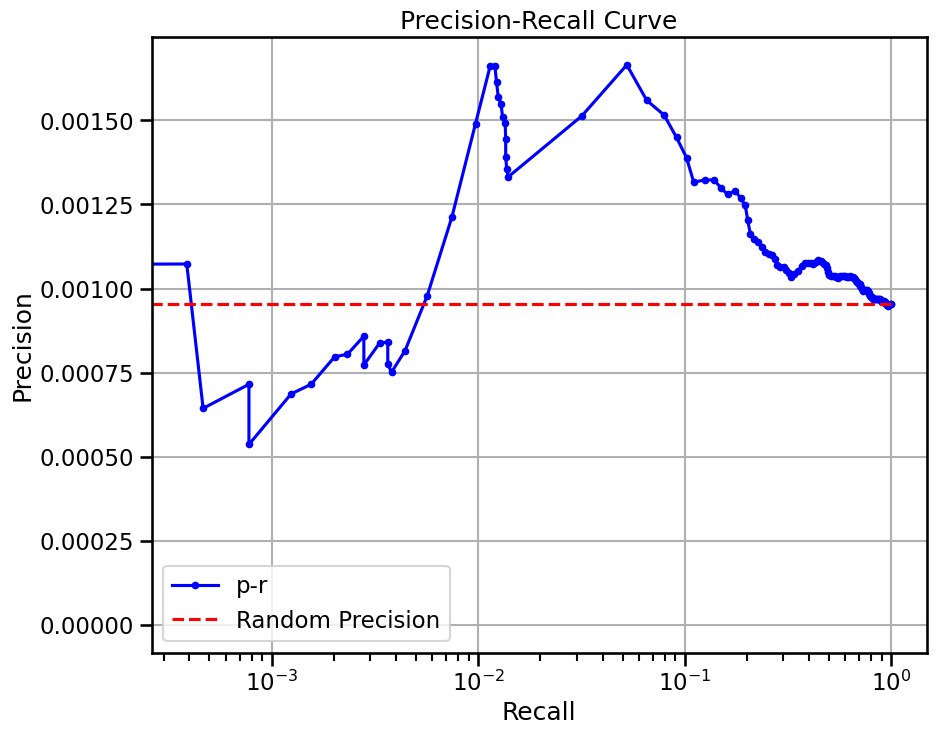

base enrichment


Top central genes: []


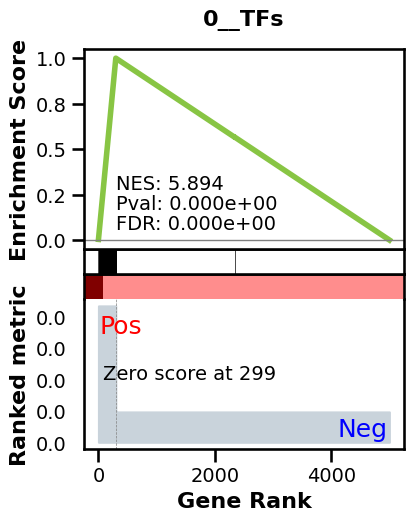

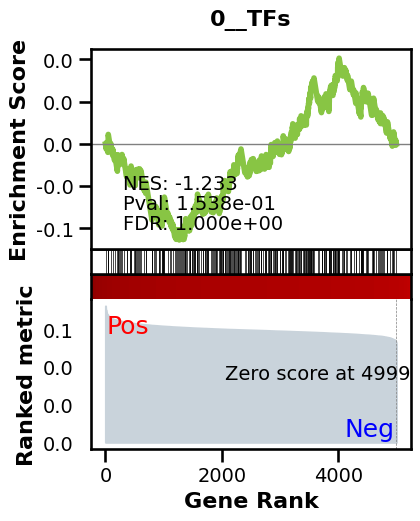

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3676 genes
intersection pct: 0.7352
precision:  0.0031289255990017686 
recall:  0.23127086406334912 
random precision: 0.0009534912985868993



  0%|          | 0/128 [00:00<?, ?it/s]


  5%|▍         | 6/128 [00:00<00:02, 51.40it/s]


  9%|▉         | 12/128 [00:00<00:02, 51.71it/s]


 14%|█▍        | 18/128 [00:00<00:02, 51.81it/s]


 19%|█▉        | 24/128 [00:00<00:02, 51.73it/s]


 23%|██▎       | 30/128 [00:00<00:01, 51.50it/s]


 28%|██▊       | 36/128 [00:00<00:01, 51.61it/s]


 33%|███▎      | 42/128 [00:00<00:01, 51.25it/s]


 38%|███▊      | 48/128 [00:00<00:01, 51.19it/s]


 42%|████▏     | 54/128 [00:01<00:01, 51.38it/s]


 47%|████▋     | 60/128 [00:01<00:01, 51.19it/s]


 52%|█████▏    | 66/128 [00:01<00:01, 51.32it/s]


 56%|█████▋    | 72/128 [00:01<00:01, 51.27it/s]


 61%|██████    | 78/128 [00:01<00:00, 51.26it/s]


 66%|██████▌   | 84/128 [00:01<00:00, 51.12it/s]


 70%|███████   | 90/128 [00:01<00:00, 50.94it/s]


 75%|███████▌  | 96/128 [00:01<00:00, 50.94it/s]


 80%|███████▉  | 102/128 [00:01<00:00, 51.10it/s]


 84%|████████▍ | 108/128 [00:02<00:00, 51.23it/s]


 89%|████████▉ | 114/128 [00:02<00:00, 51.15it/s]


 94%|█████████▍| 120/128 [00:02<00:00, 51.40it/s]


 98%|█████████▊| 126/128 [00:02<00:00, 51.33it/s]


100%|██████████| 128/128 [00:02<00:00, 51.26it/s]

Average Precision (AP):  0.0017382628509461891
Area Under Precision-Recall Curve (AUPRC):  0.0015453964225994865
EPR: 5.0873223260330676


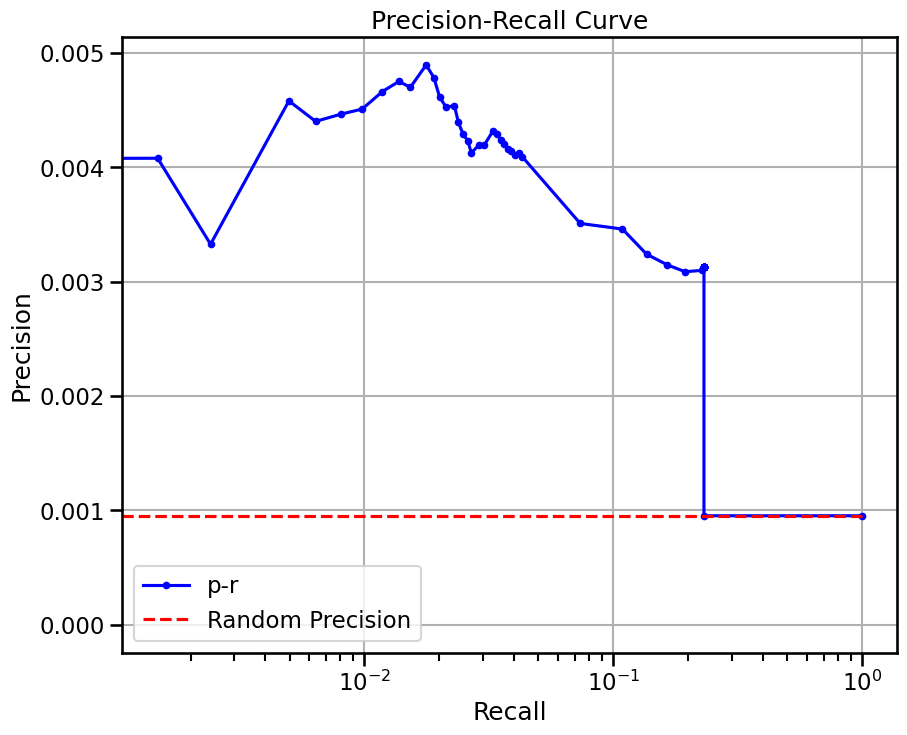


  0%|          | 0/47 [00:00<?, ?it/s]


  2%|▏         | 1/47 [00:00<00:30,  1.49it/s]


  4%|▍         | 2/47 [00:01<00:30,  1.48it/s]


  6%|▋         | 3/47 [00:02<00:29,  1.49it/s]


  9%|▊         | 4/47 [00:02<00:28,  1.49it/s]


 11%|█         | 5/47 [00:03<00:28,  1.49it/s]


 13%|█▎        | 6/47 [00:04<00:27,  1.49it/s]


 15%|█▍        | 7/47 [00:04<00:26,  1.49it/s]


 17%|█▋        | 8/47 [00:05<00:26,  1.49it/s]


 19%|█▉        | 9/47 [00:06<00:25,  1.48it/s]


 21%|██▏       | 10/47 [00:06<00:24,  1.48it/s]


 23%|██▎       | 11/47 [00:07<00:24,  1.49it/s]


 26%|██▌       | 12/47 [00:08<00:23,  1.49it/s]


 28%|██▊       | 13/47 [00:08<00:22,  1.49it/s]


 30%|██▉       | 14/47 [00:09<00:22,  1.49it/s]


 32%|███▏      | 15/47 [00:10<00:21,  1.49it/s]


 34%|███▍      | 16/47 [00:10<00:20,  1.49it/s]


 36%|███▌      | 17/47 [00:11<00:20,  1.48it/s]


 38%|███▊      | 18/47 [00:12<00:19,  1.48it/s]


 40%|████      | 19/47 [00:12<00:18,  1.48it/s]


 43%|████▎     | 20/47 [00:13<00:18,  1.49it/s]


 45%|████▍     | 21/47 [00:14<00:17,  1.49it/s]


 47%|████▋     | 22/47 [00:14<00:16,  1.49it/s]


 49%|████▉     | 23/47 [00:15<00:16,  1.49it/s]


 51%|█████     | 24/47 [00:16<00:15,  1.49it/s]


 53%|█████▎    | 25/47 [00:16<00:14,  1.49it/s]


 55%|█████▌    | 26/47 [00:17<00:14,  1.49it/s]


 57%|█████▋    | 27/47 [00:18<00:13,  1.49it/s]


 60%|█████▉    | 28/47 [00:18<00:12,  1.49it/s]


 62%|██████▏   | 29/47 [00:19<00:12,  1.49it/s]


 64%|██████▍   | 30/47 [00:20<00:11,  1.49it/s]


 66%|██████▌   | 31/47 [00:20<00:10,  1.48it/s]


 68%|██████▊   | 32/47 [00:21<00:10,  1.47it/s]


 70%|███████   | 33/47 [00:22<00:09,  1.48it/s]


 72%|███████▏  | 34/47 [00:22<00:08,  1.48it/s]


 74%|███████▍  | 35/47 [00:23<00:08,  1.48it/s]


 77%|███████▋  | 36/47 [00:24<00:07,  1.48it/s]


 79%|███████▊  | 37/47 [00:24<00:06,  1.48it/s]


 81%|████████  | 38/47 [00:25<00:06,  1.48it/s]


 83%|████████▎ | 39/47 [00:26<00:05,  1.48it/s]


 85%|████████▌ | 40/47 [00:26<00:04,  1.48it/s]


 87%|████████▋ | 41/47 [00:27<00:04,  1.48it/s]


 89%|████████▉ | 42/47 [00:28<00:03,  1.48it/s]


 91%|█████████▏| 43/47 [00:28<00:02,  1.48it/s]


 94%|█████████▎| 44/47 [00:29<00:02,  1.48it/s]


 96%|█████████▌| 45/47 [00:30<00:01,  1.48it/s]


 98%|█████████▊| 46/47 [00:30<00:00,  1.48it/s]


100%|██████████| 47/47 [00:31<00:00,  1.80it/s]


100%|██████████| 47/47 [00:31<00:00,  1.50it/s]

base enrichment


Top central genes: []
The DataFrame contains only the same values.


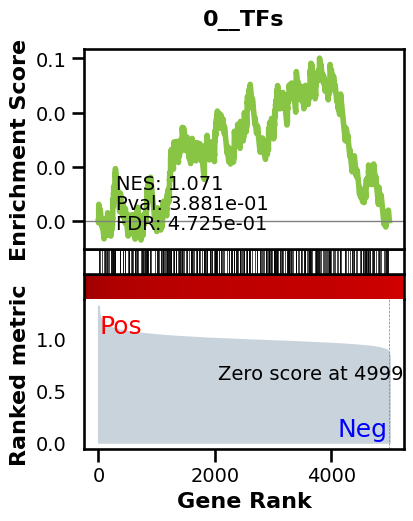

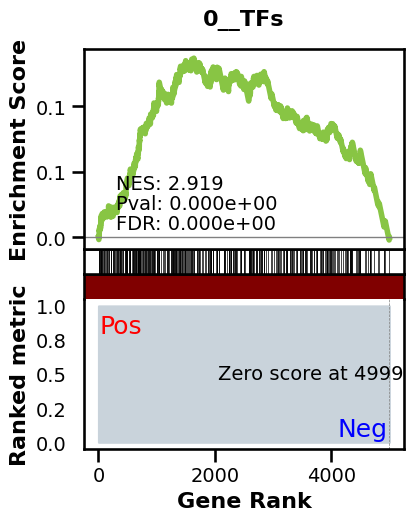

_________________________________________
TF specific enrichment


found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3645 genes
intersection pct: 0.729
precision:  0.001431579422739307 
recall:  1.0 
random precision: 0.0014319722820759532



  0%|          | 0/128 [00:00<?, ?it/s]


  5%|▍         | 6/128 [00:00<00:02, 51.88it/s]


  9%|▉         | 12/128 [00:00<00:02, 51.83it/s]


 14%|█▍        | 18/128 [00:00<00:02, 51.91it/s]


 19%|█▉        | 24/128 [00:00<00:01, 52.02it/s]


 23%|██▎       | 30/128 [00:00<00:01, 51.96it/s]


 28%|██▊       | 36/128 [00:00<00:01, 51.96it/s]


 33%|███▎      | 42/128 [00:00<00:01, 51.63it/s]


 38%|███▊      | 48/128 [00:00<00:01, 51.53it/s]


 42%|████▏     | 54/128 [00:01<00:01, 51.39it/s]


 47%|████▋     | 60/128 [00:01<00:01, 51.54it/s]


 52%|█████▏    | 66/128 [00:01<00:01, 51.74it/s]


 56%|█████▋    | 72/128 [00:01<00:01, 51.83it/s]


 61%|██████    | 78/128 [00:01<00:00, 51.70it/s]


 66%|██████▌   | 84/128 [00:01<00:00, 51.76it/s]


 70%|███████   | 90/128 [00:01<00:00, 51.90it/s]


 75%|███████▌  | 96/128 [00:01<00:00, 51.69it/s]


 80%|███████▉  | 102/128 [00:01<00:00, 51.63it/s]


 84%|████████▍ | 108/128 [00:02<00:00, 51.73it/s]


 89%|████████▉ | 114/128 [00:02<00:00, 51.76it/s]


 94%|█████████▍| 120/128 [00:02<00:00, 51.90it/s]


 98%|█████████▊| 126/128 [00:02<00:00, 51.77it/s]


100%|██████████| 128/128 [00:02<00:00, 51.72it/s]

Average Precision (AP):  0.0016673190998639802
Area Under Precision-Recall Curve (AUPRC):  0.0016667722043794172


EPR: 0.6234985721642275


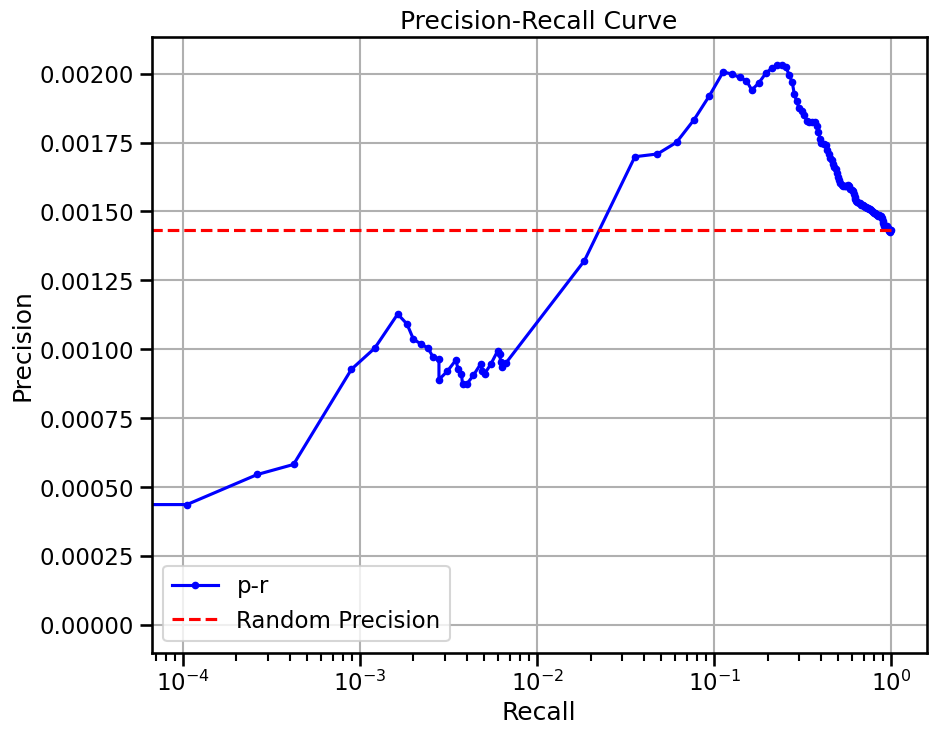

base enrichment


Top central genes: []


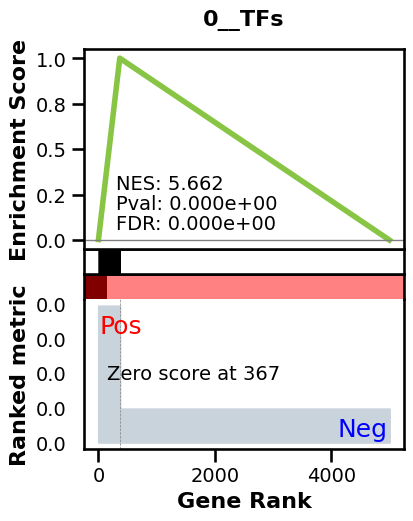

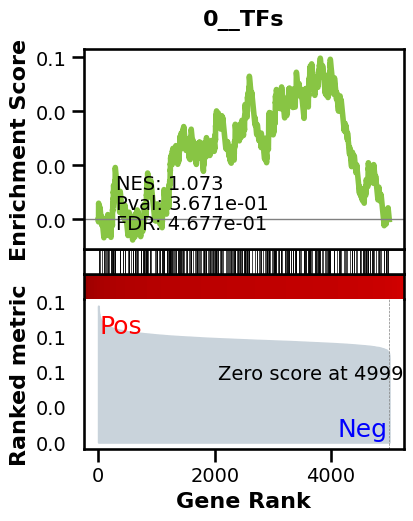

_________________________________________
TF specific enrichment


found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3645 genes
intersection pct: 0.729
precision:  0.00664551720623272 
recall:  0.4113564668769716 
random precision: 0.0014319722820759532



  0%|          | 0/128 [00:00<?, ?it/s]


  5%|▍         | 6/128 [00:00<00:02, 51.68it/s]


  9%|▉         | 12/128 [00:00<00:02, 51.30it/s]


 14%|█▍        | 18/128 [00:00<00:02, 50.95it/s]


 19%|█▉        | 24/128 [00:00<00:02, 51.13it/s]


 23%|██▎       | 30/128 [00:00<00:01, 50.83it/s]


 28%|██▊       | 36/128 [00:00<00:01, 51.10it/s]


 33%|███▎      | 42/128 [00:00<00:01, 50.89it/s]


 38%|███▊      | 48/128 [00:00<00:01, 51.19it/s]


 42%|████▏     | 54/128 [00:01<00:01, 51.11it/s]


 47%|████▋     | 60/128 [00:01<00:01, 51.00it/s]


 52%|█████▏    | 66/128 [00:01<00:01, 51.00it/s]


 56%|█████▋    | 72/128 [00:01<00:01, 50.99it/s]


 61%|██████    | 78/128 [00:01<00:00, 51.04it/s]


 66%|██████▌   | 84/128 [00:01<00:00, 50.86it/s]


 70%|███████   | 90/128 [00:01<00:00, 51.05it/s]


 75%|███████▌  | 96/128 [00:01<00:00, 50.85it/s]


 80%|███████▉  | 102/128 [00:02<00:00, 50.74it/s]


 84%|████████▍ | 108/128 [00:02<00:00, 50.67it/s]


 89%|████████▉ | 114/128 [00:02<00:00, 50.92it/s]


 94%|█████████▍| 120/128 [00:02<00:00, 51.15it/s]


 98%|█████████▊| 126/128 [00:02<00:00, 51.23it/s]


100%|██████████| 128/128 [00:02<00:00, 50.99it/s]

Average Precision (AP):  0.0048206532216212026
Area Under Precision-Recall Curve (AUPRC):  0.004243792386865472
EPR: 5.617129687034624


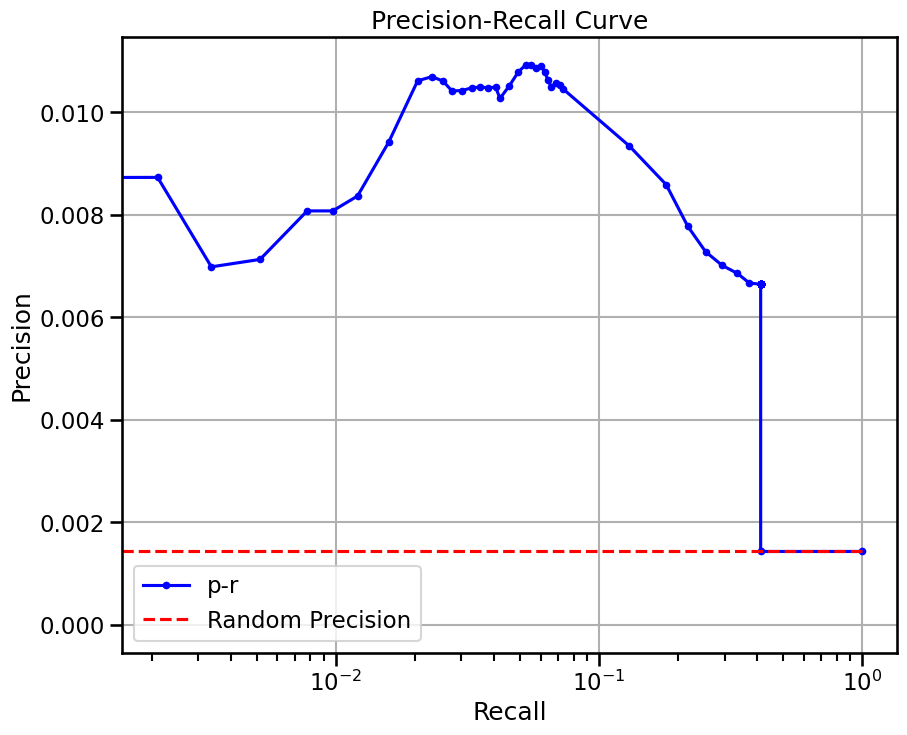


  0%|          | 0/46 [00:00<?, ?it/s]


  2%|▏         | 1/46 [00:00<00:30,  1.49it/s]


  4%|▍         | 2/46 [00:01<00:29,  1.48it/s]


  7%|▋         | 3/46 [00:02<00:28,  1.49it/s]


  9%|▊         | 4/46 [00:02<00:28,  1.49it/s]


 11%|█         | 5/46 [00:03<00:27,  1.50it/s]


 13%|█▎        | 6/46 [00:04<00:26,  1.50it/s]


 15%|█▌        | 7/46 [00:04<00:26,  1.50it/s]


 17%|█▋        | 8/46 [00:05<00:25,  1.50it/s]


 20%|█▉        | 9/46 [00:06<00:24,  1.50it/s]


 22%|██▏       | 10/46 [00:06<00:24,  1.50it/s]


 24%|██▍       | 11/46 [00:07<00:23,  1.50it/s]


 26%|██▌       | 12/46 [00:08<00:22,  1.50it/s]


 28%|██▊       | 13/46 [00:08<00:22,  1.50it/s]


 30%|███       | 14/46 [00:09<00:21,  1.50it/s]


 33%|███▎      | 15/46 [00:10<00:20,  1.49it/s]


 35%|███▍      | 16/46 [00:10<00:20,  1.49it/s]


 37%|███▋      | 17/46 [00:11<00:19,  1.49it/s]


 39%|███▉      | 18/46 [00:12<00:18,  1.49it/s]


 41%|████▏     | 19/46 [00:12<00:18,  1.49it/s]


 43%|████▎     | 20/46 [00:13<00:17,  1.49it/s]


 46%|████▌     | 21/46 [00:14<00:16,  1.49it/s]


 48%|████▊     | 22/46 [00:14<00:16,  1.49it/s]


 50%|█████     | 23/46 [00:15<00:15,  1.49it/s]


 52%|█████▏    | 24/46 [00:16<00:14,  1.49it/s]


 54%|█████▍    | 25/46 [00:16<00:14,  1.49it/s]


 57%|█████▋    | 26/46 [00:17<00:13,  1.49it/s]


 59%|█████▊    | 27/46 [00:18<00:12,  1.49it/s]


 61%|██████    | 28/46 [00:18<00:12,  1.49it/s]


 63%|██████▎   | 29/46 [00:19<00:11,  1.49it/s]


 65%|██████▌   | 30/46 [00:20<00:10,  1.49it/s]


 67%|██████▋   | 31/46 [00:20<00:10,  1.49it/s]


 70%|██████▉   | 32/46 [00:21<00:09,  1.49it/s]


 72%|███████▏  | 33/46 [00:22<00:08,  1.49it/s]


 74%|███████▍  | 34/46 [00:22<00:08,  1.49it/s]


 76%|███████▌  | 35/46 [00:23<00:07,  1.49it/s]


 78%|███████▊  | 36/46 [00:24<00:06,  1.49it/s]


 80%|████████  | 37/46 [00:24<00:06,  1.49it/s]


 83%|████████▎ | 38/46 [00:25<00:05,  1.49it/s]


 85%|████████▍ | 39/46 [00:26<00:04,  1.48it/s]


 87%|████████▋ | 40/46 [00:26<00:04,  1.49it/s]


 89%|████████▉ | 41/46 [00:27<00:03,  1.48it/s]


 91%|█████████▏| 42/46 [00:28<00:02,  1.48it/s]


 93%|█████████▎| 43/46 [00:28<00:02,  1.48it/s]


 96%|█████████▌| 44/46 [00:29<00:01,  1.48it/s]


 98%|█████████▊| 45/46 [00:30<00:00,  1.48it/s]


100%|██████████| 46/46 [00:30<00:00,  1.48it/s]


100%|██████████| 46/46 [00:30<00:00,  1.49it/s]

base enrichment


Top central genes: []
The DataFrame contains only the same values.


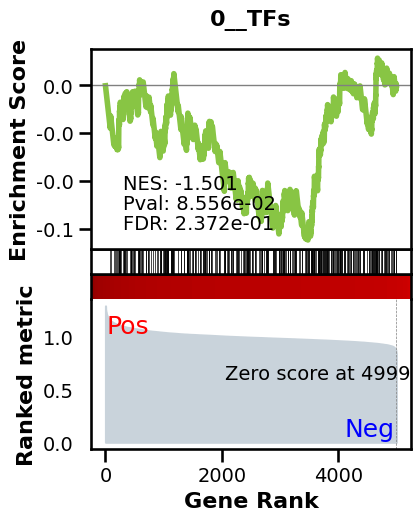

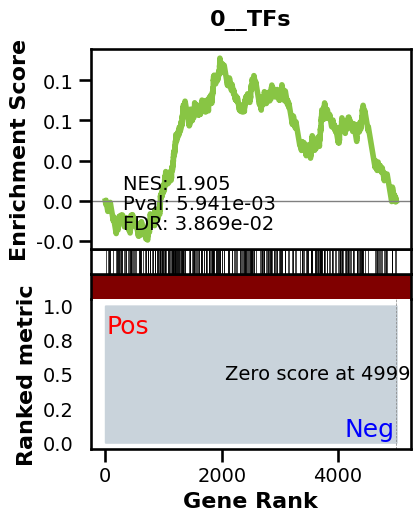

_________________________________________
TF specific enrichment


found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3764 genes
intersection pct: 0.7528
precision:  0.0018323374527516683 
recall:  1.0 
random precision: 0.0018328243880301035



  0%|          | 0/128 [00:00<?, ?it/s]


  4%|▍         | 5/128 [00:00<00:02, 46.43it/s]


  8%|▊         | 10/128 [00:00<00:02, 46.24it/s]


 12%|█▏        | 15/128 [00:00<00:02, 46.41it/s]


 16%|█▌        | 20/128 [00:00<00:02, 46.05it/s]


 20%|█▉        | 25/128 [00:00<00:02, 45.98it/s]


 23%|██▎       | 30/128 [00:00<00:02, 46.16it/s]


 27%|██▋       | 35/128 [00:00<00:02, 46.07it/s]


 31%|███▏      | 40/128 [00:00<00:01, 46.17it/s]


 35%|███▌      | 45/128 [00:00<00:01, 46.24it/s]


 39%|███▉      | 50/128 [00:01<00:01, 46.27it/s]


 43%|████▎     | 55/128 [00:01<00:01, 46.33it/s]


 47%|████▋     | 60/128 [00:01<00:01, 46.50it/s]


 51%|█████     | 65/128 [00:01<00:01, 46.41it/s]


 55%|█████▍    | 70/128 [00:01<00:01, 46.49it/s]


 59%|█████▊    | 75/128 [00:01<00:01, 46.54it/s]


 62%|██████▎   | 80/128 [00:01<00:01, 46.25it/s]


 66%|██████▋   | 85/128 [00:01<00:00, 46.40it/s]


 70%|███████   | 90/128 [00:01<00:00, 46.51it/s]


 74%|███████▍  | 95/128 [00:02<00:00, 46.31it/s]


 78%|███████▊  | 100/128 [00:02<00:00, 46.42it/s]


 82%|████████▏ | 105/128 [00:02<00:00, 46.29it/s]


 86%|████████▌ | 110/128 [00:02<00:00, 46.41it/s]


 90%|████████▉ | 115/128 [00:02<00:00, 46.60it/s]


 94%|█████████▍| 120/128 [00:02<00:00, 46.32it/s]


 98%|█████████▊| 125/128 [00:02<00:00, 46.31it/s]


100%|██████████| 128/128 [00:02<00:00, 46.30it/s]

Average Precision (AP):  0.0022221870285967847
Area Under Precision-Recall Curve (AUPRC):  0.0022218812829089235
EPR: 1.1988515685165522


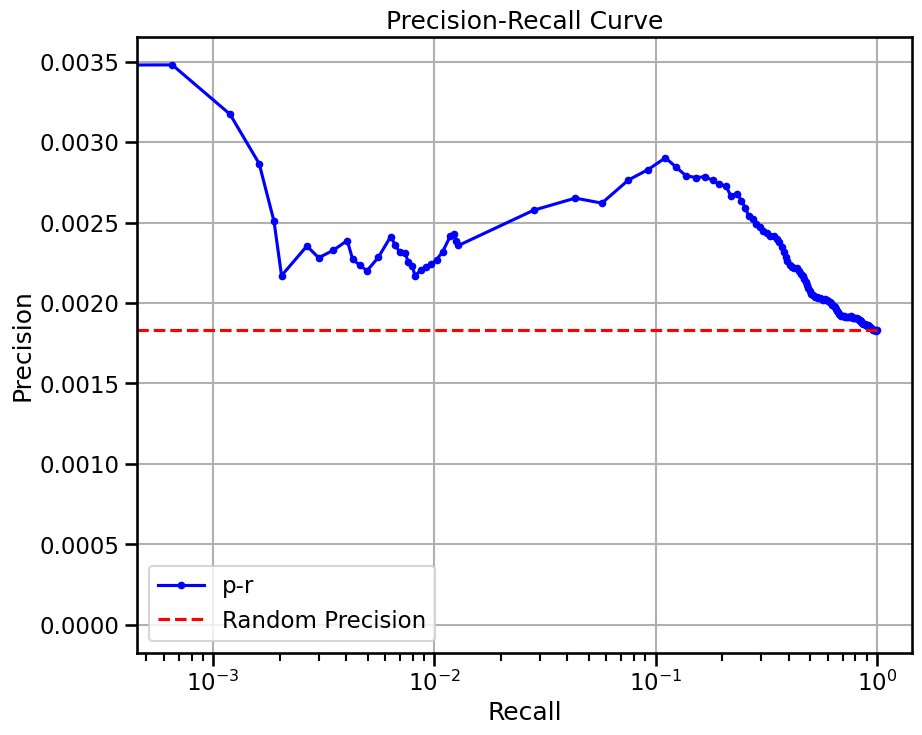

base enrichment


Top central genes: []


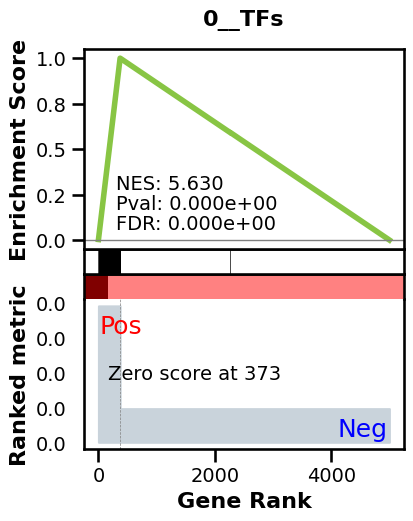

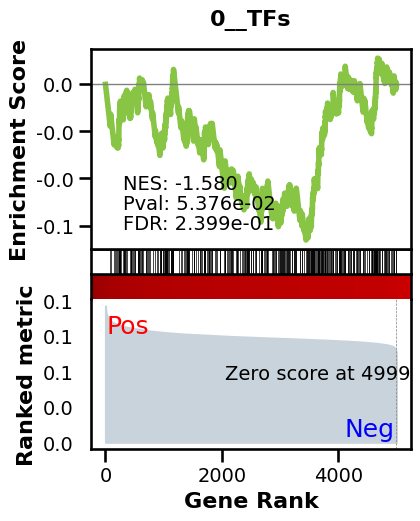

_________________________________________
TF specific enrichment


found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3764 genes
intersection pct: 0.7528
precision:  0.009202009467684283 
recall:  0.4549691833590139 
random precision: 0.0018328243880301035



  0%|          | 0/128 [00:00<?, ?it/s]


  4%|▍         | 5/128 [00:00<00:02, 47.17it/s]


  8%|▊         | 10/128 [00:00<00:02, 46.84it/s]


 12%|█▏        | 15/128 [00:00<00:02, 47.04it/s]


 16%|█▌        | 20/128 [00:00<00:02, 47.08it/s]


 20%|█▉        | 25/128 [00:00<00:02, 47.35it/s]


 23%|██▎       | 30/128 [00:00<00:02, 47.21it/s]


 27%|██▋       | 35/128 [00:00<00:01, 47.22it/s]


 31%|███▏      | 40/128 [00:00<00:01, 47.30it/s]


 35%|███▌      | 45/128 [00:00<00:01, 46.95it/s]


 39%|███▉      | 50/128 [00:01<00:01, 47.05it/s]


 43%|████▎     | 55/128 [00:01<00:01, 47.08it/s]


 47%|████▋     | 60/128 [00:01<00:01, 46.91it/s]


 51%|█████     | 65/128 [00:01<00:01, 46.86it/s]


 55%|█████▍    | 70/128 [00:01<00:01, 46.74it/s]


 59%|█████▊    | 75/128 [00:01<00:01, 46.75it/s]


 62%|██████▎   | 80/128 [00:01<00:01, 46.48it/s]


 66%|██████▋   | 85/128 [00:01<00:00, 46.78it/s]


 70%|███████   | 90/128 [00:01<00:00, 47.03it/s]


 74%|███████▍  | 95/128 [00:02<00:00, 47.07it/s]


 78%|███████▊  | 100/128 [00:02<00:00, 47.26it/s]


 82%|████████▏ | 105/128 [00:02<00:00, 47.04it/s]


 86%|████████▌ | 110/128 [00:02<00:00, 47.00it/s]


 90%|████████▉ | 115/128 [00:02<00:00, 47.05it/s]


 94%|█████████▍| 120/128 [00:02<00:00, 47.22it/s]


 98%|█████████▊| 125/128 [00:02<00:00, 47.24it/s]


100%|██████████| 128/128 [00:02<00:00, 47.03it/s]

Average Precision (AP):  0.007109951207181448
Area Under Precision-Recall Curve (AUPRC):  0.006430670597924137
EPR: 9.019739985716402


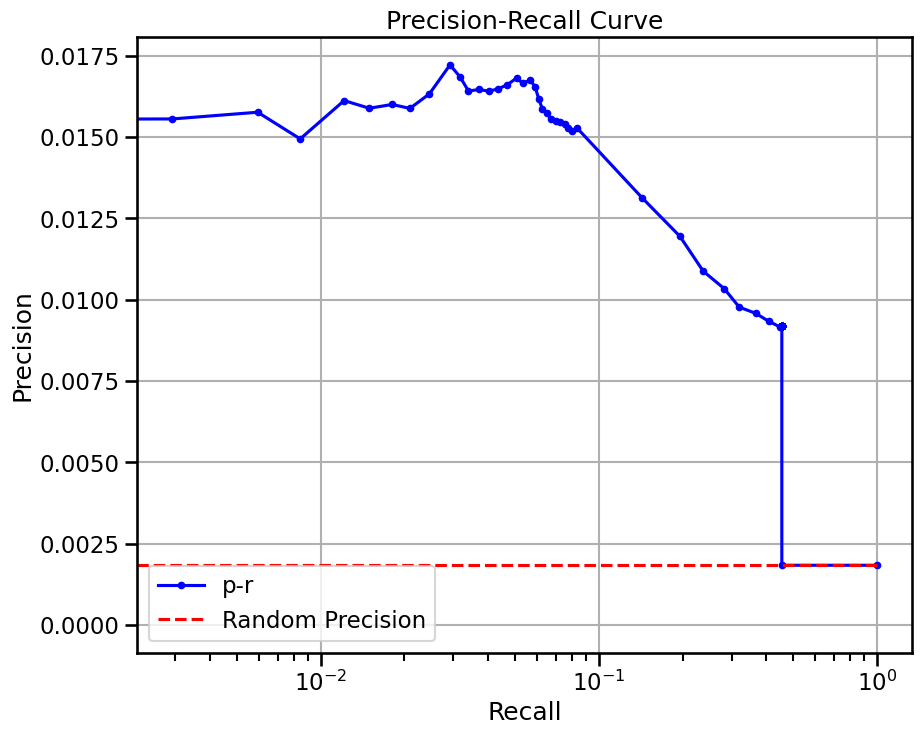

In [6]:
sc.tl.rank_genes_groups(
    adata, groupby="cell_type"
)
adata.var['ensembl_id'] = adata.var.index
metrics = {}
for celltype in CELLTYPES:
    to_use = adata.uns["rank_genes_groups"]["names"][celltype].tolist()
    to_use = [i for i in to_use if i in genes]
    to_use = to_use[:NUM_GENES]
    subadata = adata[adata.obs.cell_type == celltype]
    subadata = subadata[subadata.X.sum(1) > 500][:MAXCELLS, adata.var.index.isin(to_use)]
    print(celltype, subadata.shape)
    subadata.var = subadata.var.set_index('feature_name')
    grn = generate_grn(model, vocab, subadata, batch_size = 5, num_attn_layers = 11)
    metrics["scGPT_"+celltype] = BenGRN(grn).scprint_benchmark()
    grn.varp['GRN'][~grn.var.isTF,:]=0
    metrics['scGPT_tf_'+celltype] = BenGRN(grn).scprint_benchmark()
    gc.collect()
    torch.cuda.empty_cache()


In [7]:
metrics

{'scGPT_retinal rod cell': {'TF_enr': False,
  'significant_enriched_TFtargets': 0.0,
  'precision': 0.0007864897886925406,
  'recall': 1.0,
  'rand_precision': 0.0007878319214377497,
  'auprc': 0.0010305593982646356,
  'ap': 0.0010480997366085684,
  'epr': 0.0},
 'scGPT_tf_retinal rod cell': {'enriched_terms_Central': ['0__TFs'],
  'TF_enr': True,
  'significant_enriched_TFtargets': 0.0,
  'precision': 0.005719153078607934,
  'recall': 0.5202952029520295,
  'rand_precision': 0.0007878319214377497,
  'auprc': 0.005335114997087407,
  'ap': 0.005584191097343096,
  'epr': 9.492461408769918},
 'scGPT_Mueller cell': {'enriched_terms_Regulators': ['celltype.gmt__Hepatic stellate cells',
   'celltype.gmt__Mesangial cells',
   'celltype.gmt__Pulmonary alveolar type I cells',
   'celltype.gmt__Retinal progenitor cells',
   'celltype.gmt__Granulocytes',
   'celltype.gmt__Myofibroblasts',
   'celltype.gmt__Muller cells',
   'celltype.gmt__Pancreatic stellate cells',
   'celltype.gmt__Ductal cells

In [ ]:
False
False
True
True
True
True
False
False
True
True
False
True
True
True
False
False
False
False
False
False

In [8]:
import pandas as pd

In [9]:
res = []
for k, v in metrics.items():
    res.append([k.split('_')[-1], v['epr'], v['auprc'], v['rand_precision'], v['significant_enriched_TFtargets'], v.get('TF_enr', False), 'tf_' in k])

df = pd.DataFrame(res, columns=['name','EPR', 'AUPRC', 'RAND', 'TF_targ', 'TF_enr', 'TF_only'])
df

name       EPR     AUPRC      RAND  TF_targ  TF_enr  \
0         retinal rod cell  0.000000  0.001031  0.000788      0.0   False   
1         retinal rod cell  9.492461  0.005335  0.000788      0.0    True   
2             Mueller cell  1.243361  0.001536  0.001375      0.0    True   
3             Mueller cell  5.395052  0.003977  0.001375      0.0    True   
4            amacrine cell  1.378360  0.000933  0.000820      0.0   False   
5            amacrine cell  4.502569  0.001506  0.000820      0.0    True   
6          ON-bipolar cell  3.036501  0.000777  0.000698      0.0    True   
7          ON-bipolar cell  4.666506  0.001141  0.000698      0.0    True   
8         rod bipolar cell  3.401892  0.000766  0.000673      0.0    True   
9         rod bipolar cell  3.401892  0.001000  0.000673      0.0    True   
10       retinal cone cell  1.915495  0.000825  0.000768      0.0   False   
11       retinal cone cell  4.671547  0.001472  0.000768      0.0    True   
12  retina horizontal cell  0.528558  0.001152  0.001025      0.0    True   
13  retina horizontal cell  4.184044  0.002011  0.001025      0.0    True   
14   retinal ganglion cell  0.813916  0.001100  0.000953      0.0   False   
15   retinal ganglion cell  5.087322  0.001545  0.000953      0.0    True   
16               astrocyte  0.623499  0.001667  0.001432      0.0    True   
17               astrocyte  5.617130  0.004244  0.001432      0.0    True   
18         microglial cell  1.198852  0.002222  0.001833      0.0    True   
19         microglial cell  9.019740  0.006431  0.001833      0.0    True   

    TF_only  
0     False  
1      True  
2     False  
3      True  
4     False  
5      True  
6     False  
7      True  
8     False  
9      True  
10    False  
11     True  
12    False  
13     True  
14    False  
15     True  
16    False  
17     True  
18    False  
19     True